# Exective summary of Work Package 2

## Objectives

In this WP, you will work on a given training dataset. Your goal is to develop a fault detection model using the classification algorithms learnt in the class, in order to achieve best F1 score.

## Tasks

- Task 1: Develop a fault detection model using the unsupervised learning algorithms learnt in the class, in order to achieve best F1 score.
- Task 2: With the help of the supporting script, develop a cross-validation scheme to test the performance of the developed classification algorithms.
- Task 3: Develop a fault detection model using the classification algorithms learnt in the class, in order to achieve best F1 score.

## Deliverables

- A Jupyter notebook reporting the process and results of the above tasks

# Before starting, please:
- Fetch the most up-to-date version of the github repository.
- Create a new branch with your name, based on the "main" branch and switch to your own branch.
- Copy this notebook to the work space of your group, and rename it to TD_WP_2_Your name.ipynb
- After finishing this task, push your changes to the github repository of your group.

# Task 1: Unsupervised learning approaches

## Implement the statistical testing approach for fault detection

In this exercise, we interpret the statistical testing approach for fault detection. The basic idea of statistical testing approach is that we fit a multi-dimensitional distribution to the observation data under normal working condition. Then, when a new data point arrives, we design a hypothesis test to see whether the new data point is consistent with the distribution. If the new data point is consistent with the distribution, we can conclude that the fault is not due to the faulty component.

The benefit of this approach is that, to design the detection algrothim, we do not need failed data. Also, the computational time is short as all we need is just to compute the pdf and compare it to a threshold.

In this exercise, you need to:
- Fit a multi-dimensitional distribution to the training dataset (all normal samples).
- Design a fault detection algorithm based on the fitted distribution to detect faulty components.

The following block defines a few functions that you can use.

In [13]:
import numpy as np
from numpy import quantile, where, random

import pandas as pd
import random

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import multivariate_normal

from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import LocalOutlierFactor

from imblearn.over_sampling import SMOTE

from itertools import combinations

from sklearn.pipeline import Pipeline

import warnings

def estimateGaussian(X):
    '''Given X, this function estimates the parameter of a multivariate Gaussian distribution.'''
    mu = np.mean(X, axis=0)
    sigma2 = np.var(X, axis=0)
    return mu, sigma2

def classify(X, distribution, log_epsilon):
    '''Given X, this function classifies each sample in X based on the multivariate Gaussian distribution. 
       The decision rule is: if the log pdf is less than log_epsilon, we predict 1, as the sample is unlikely to be from the distribution, which represents normal operation.
    '''
    p = distribution.logpdf(X)
    predictions = (p < log_epsilon).astype(int)
    
    return predictions


Let us use the dataset `20240105_164214` as training dataset, as all the samples in this dataset are normal operation. We will use the dataset `20240325_155003` as testing dataset. Let us try to predict the state of motor 1. For this, we first extract the position, temperature and voltage of motor 1 as features (you can change the features if you want). 

In [14]:
import sys

sys.path.insert(0, 'C:/Users/gioca/GitHub/projects/maintenance_industry_4_2024/supporting_scripts/WP_2_20240516/')
from utility import read_all_test_data_from_path
from utility import read_all_csvs_one_test

# Specify path to the dictionary.
base_dictionary = 'C:/Users/gioca/GitHub/projects/maintenance_industry_4_2024/dataset/training_data/'
dictionary_name = '20240105_164214'
path = base_dictionary + dictionary_name

# Read the data.
df_data = read_all_csvs_one_test(path, dictionary_name)

# Get the features
X_train = df_data[['data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage']]

# We do the same to get the test dataset.
dictionary_name = '20240325_155003'
path = base_dictionary + dictionary_name

# Read the data.
df_data = read_all_csvs_one_test(path, dictionary_name)

# Get the features
X_test = df_data[['data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage']]
y_test = df_data['data_motor_1_label']

Please design your algorithm below:

In [15]:
# First, we need to fit a MVN distribution to the normal samples.
# Put your code here.

mu, sigma2 = estimateGaussian(X_train)

# Construct a multivariate Gaussian distribution to represent normal operation.
distribution = multivariate_normal(mean=mu, cov=np.diag(sigma2))

# Now, let's try to predict the labels of the test set X_test.
# Put your code here.

y_pred = classify(X_test, distribution, -50)

# Calculate accuracy of the prediction.
accuracy = accuracy_score(y_test, y_pred)

# In this block of code we simply used the functions pre-defined to predict the label of the test dataset, without any attempt of improving the results.

**Discussions:**
- Can you please try to improve the performance of this approach?
    - For example, by normalizating the data?
    - By smoothing the data?
    - By reducing feature number?
    - etc.
- The parameter log_epsilon defines the threshold we use for making classification. What happens if you change it?
- Could you discuss how we should get the best value for this parameter?

In [17]:
# Initially, we don't want to modify the value of epsilon, in order to understand if each of the changes we make directly impact the precision of the model.
# First of all, we eliminate the outliers.

X_train_copy = X_train.copy()
X_train_copy['indice'] = X_train.reset_index().index
model = LocalOutlierFactor(n_neighbors=20)

X_test_copy = X_test.copy()
X_test_copy['indice'] = X_test.reset_index().index

def removeoutliers (ds, feature):

    x = pd.DataFrame(ds, columns=['indice',feature])
    model.fit_predict(x)
    lof = model.negative_outlier_factor_ 
    df_out = pd.DataFrame({'indice': x['indice'], 'lof': lof })

    return df_out

features = ['data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage']
for j in features:
     outliers = removeoutliers(X_train_copy, j)
     thresh1 = np.quantile(outliers.lof, 1/3000)
     index = where(outliers.lof<=thresh1)
     final_index = np.ravel(outliers['indice'].iloc[0] + index)
     X_train_copy = X_train_copy[~X_train_copy['indice'].isin(final_index)]

X_train_copy = X_train_copy.drop(columns='indice')

for j in features:
     outliers = removeoutliers(X_test_copy, j)
     thresh1 = np.quantile(outliers.lof, 1/3000)
     index = where(outliers.lof<=thresh1)
     final_index = np.ravel(outliers['indice'].iloc[0] + index)
     X_test_copy = X_test_copy[~X_test_copy['indice'].isin(final_index)]

X_test_copy = X_test_copy.drop(columns='indice')

mu, sigma2 = estimateGaussian(X_train_copy)
distribution = multivariate_normal(mean=mu, cov=np.diag(sigma2))
y_pred = classify(X_test_copy, distribution, -50)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Results without outliers: ")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

# This first change didn't affect the result of the accuracy. At this point, the second step is to standardize the data.

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_copy = pd.DataFrame(scaler.fit_transform(X_train_copy), columns=X_train_copy.columns, index=X_train_copy.index)
mu, sigma2 = estimateGaussian(X_train_copy)
distribution = multivariate_normal(mean=mu, cov=np.diag(sigma2))
X_test_copy = pd.DataFrame(scaler.fit_transform(X_test_copy), columns=X_test_copy.columns, index=X_test_copy.index)
y_pred = classify(X_test_copy, distribution, -50)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Results with standardization: ")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

# The standardization doesn't affect at all the accuracy of the prediction. At this point, we tried to smooth the data.

for i in features:
     X_train_copy[i] = X_train_copy[i].rolling(window=25, center=True).mean()
X_train_copy = X_train_copy.dropna(axis=0)
for i in features:
     X_test_copy[i] = X_test_copy[i].rolling(window=25, center=True).mean()
X_test_copy = X_test_copy.dropna(axis=0)

mu, sigma2 = estimateGaussian(X_train_copy)
distribution = multivariate_normal(mean=mu, cov=np.diag(sigma2))
y_pred = classify(X_test, distribution, -50)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Results with smoothing: ")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

# The smoothing didn't affect at all the accuracy of the prediction. At this point, we tested the impact of the different combinations of features.

all_combinations = []
for r in [1, 2, 3]:
    combinations_of_covariates = list(combinations(features, r))
    all_combinations.extend(combinations_of_covariates)

for combo in all_combinations:
     covariates = list(combo)
     X_prova = X_train_copy[covariates]

     epsilon_values = np.linspace(-500000000, 100000000, num=10000)
     accuracy_results = []
     epsilon_list = []
     for epsilon in epsilon_values:
         mu, sigma2 = estimateGaussian(X_prova)
         distribution = multivariate_normal(mean=mu, cov=np.diag(sigma2))
         y_pred = classify(X_test[covariates], distribution, epsilon)
         accuracy = accuracy_score(y_test, y_pred)
         accuracy_results.append(accuracy)
         epsilon_list.append(epsilon)

     print(combo) 
     max_accuracy = np.max(accuracy_results)  
     print(f"The maximum accuracy is {max_accuracy}")
     plt.figure(figsize=(10, 10))
     plt.scatter(epsilon_list, accuracy_results)
     plt.xlabel('Epsilon')
     plt.ylabel('Accuracy')
     plt.title('Accuracy vs. Epsilon')
     plt.grid(True)
     plt.show()


# It looks like the accuracy doesn't depend on the number of features, which is actually very strange.
# Therefore, we tried to vary the value of epsilon in order to understand which is the optimal one. To do this, we plotted the value of accuracy depending on epsilon.

# It's visible that, changing the value of epsilon, the accuracy changes a lot. Anyway, identifying the correct value of epsilon may be very difficult, since they vary a lot.

ValueError: Found input variables with inconsistent numbers of samples: [6652, 6643]

## Local outiler factor (LOF)

The local outlier factor (LOF) algorithm computes the local density deviation of a given data point with respect to its neighbors. It considers as outliers the samples that have a substantially lower density than their neighbors. You can easiliy implement LOF in scikit-learn ([tutorial](https://www.datatechnotes.com/2020/04/anomaly-detection-with-local-outlier-factor-in-python.html)).

Please implement local outlier factor (LOF) algorithm on the dataset of `20240325_155003`. You can try first to detect the failure of motor 1 using this model. Please calculate the accuracy score of your prediction.

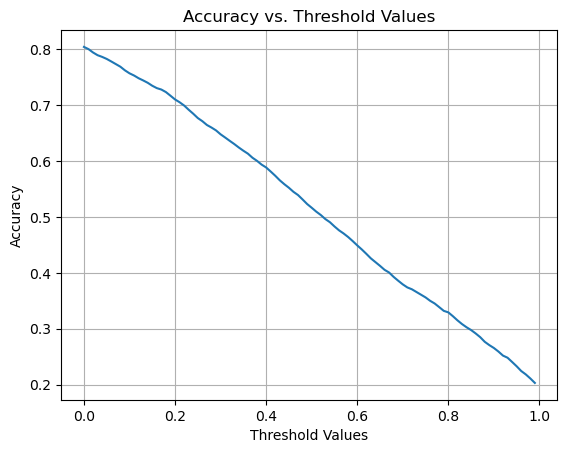

Max Accuracy Value 0.8042984713182988
Best Threshold Value: 0.0


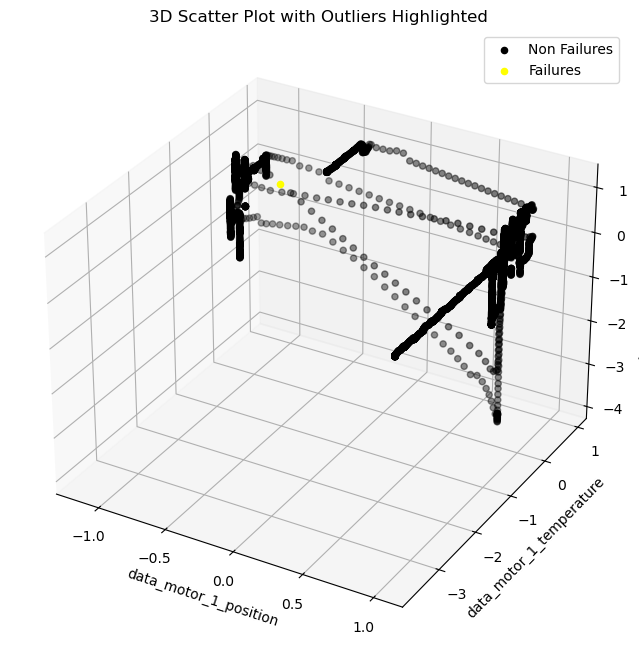

In [13]:
from sklearn.neighbors import LocalOutlierFactor
from mpl_toolkits.mplot3d import Axes3D
from numpy import quantile, where

dictionary_name = '20240325_155003'
df_lof = read_all_csvs_one_test(path, dictionary_name)
X_lof = df_lof[['data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage']]
X_lof_copy = X_lof.copy()
scaler = StandardScaler()
X_lof_copy = pd.DataFrame(scaler.fit_transform(X_lof_copy), columns=X_lof_copy.columns)
X_lof_copy['indice'] = X_lof.reset_index().index

y_lof = df_lof[['data_motor_1_label']]
y_lof = pd.DataFrame(y_test, columns=['data_motor_1_label'])
y_lof_copy = y_lof.copy()
y_lof_copy['indice'] = y_lof.reset_index().index

model = LocalOutlierFactor(n_neighbors=20)

# Since we already used the LOF technique in order to remove the outliers, we don't want the algorithm to confuse
# the outliers with the failures, so we started by removing the outliers with the LOF.

features = ['data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage']
for j in features:
     outliers = removeoutliers(X_lof_copy, j)
     thresh1 = np.quantile(outliers.lof, 1/1000)
     index = where(outliers.lof<=thresh1)
     final_index = np.ravel(outliers['indice'].iloc[0] + index)
     X_lof_copy = X_lof_copy[~X_lof_copy['indice'].isin(final_index)]
     y_lof_copy = y_lof_copy[~y_lof_copy['indice'].isin(final_index)]

# After standardizing and removing the otuliers, we'll also smooth the data

for i in features:
     X_lof_copy[i] = X_lof_copy[i].rolling(window=25, center=True).mean()
X_lof_copy = X_lof_copy.dropna(axis=0)
remaining_indices = X_lof_copy.index
y_lof_copy = y_lof_copy[y_lof_copy.index.isin(remaining_indices)]

X_lof_copy = X_lof_copy.drop(columns='indice')
y_lof_copy = y_lof_copy.drop(columns='indice')

model = LocalOutlierFactor(n_neighbors=20) 
model.fit_predict(X_lof_copy)
lof = model.negative_outlier_factor_ 

true_labels = y_lof_copy['data_motor_1_label']
total_predictions = len(y_lof_copy)

# Thresh values to examinate
thresh_values = np.arange(0.00, 1, 0.01)

# List to memorize the accuracies calculated for each thresh value
accuracies = []

for i in thresh_values:
    # Calcola gli outliers
    thresh = quantile(lof, i)
    index = where(lof <= thresh)
    index_array = index[0]
    
    # Calcola true positives e true negatives
    true_positives = sum(true_labels.iloc[index_array] == 1)
    true_negatives = sum(true_labels.iloc[~true_labels.index.isin(index_array)] == 0)
    
    # Calcola l'accuratezza
    accuracy = (true_negatives + true_positives) / total_predictions
    
    # Aggiungi l'accuratezza alla lista
    accuracies.append(accuracy)

plt.plot(thresh_values, accuracies)
plt.xlabel('Threshold Values')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Threshold Values')
plt.grid(True)
plt.show()

max_accuracy_index = np.argmax(accuracies)
max_accuracy = max(accuracies)
best_thresh_value = thresh_values[max_accuracy_index]
print("Max Accuracy Value", max_accuracy)
print("Best Threshold Value:", best_thresh_value)

best_thresh = quantile(lof, best_thresh_value)
index = where(lof <= best_thresh)
index_array = index[0]

# Creazione dello scatter plot con il thresh migliore
fig = plt.figure(figsize=(10, 8))  # Regola la dimensione come desiderato
ax = fig.add_subplot(111, projection='3d')

# Scatter plot di tutti i punti dati eccetto gli outlier
non_failures = X_lof_copy.drop(X_lof_copy.index[index_array])
ax.scatter(non_failures.iloc[:, 0], non_failures.iloc[:, 1], non_failures.iloc[:, 2], color='black', label='Non Failures')

# Scatter plot degli outlier
failures = X_lof_copy.iloc[index_array]
ax.scatter(failures.iloc[:, 0], failures.iloc[:, 1], failures.iloc[:, 2], color='yellow', label='Failures')

ax.set_xlabel(X_lof_copy.columns[0])
ax.set_ylabel(X_lof_copy.columns[1])
ax.set_zlabel(X_lof_copy.columns[2])
ax.set_title('3D Scatter Plot with Outliers Highlighted')
ax.legend()

plt.show()

# Task 2 Develop a cross validation pipeline to evaluate the performance of the model.

The idea of cross validation is to split the data into k subsets and use one of them as the test set and the rest as the training set. The performance of the model is evaluated only on the test dataset, while the model is trained on the training dataset. By doing this, we ensure that the evaluation of the model is independent from the training of the model. Therefore, we can detect if the model is overfitted.

## k-fold cross validation

Here, we use motor 1 as an example to develop a pipeline for cross validation. Below, you have a script that read the data, extract features and get the labels.

1. Use sk-learn to split the data into training and testing sets, using a k-fold cross validation with k=5. (Hint: This is a routine task which can be answered easily by language models like chatgpt. You can try prompt like this: `Generate a code in python to split the data X and y into training and testing sets, using a k-fold cross validation with k=5.`)
2. Then, train a basic logistic regression model, without hyper-parameter tuning on the training set, and use the testing set to evaluate the performance of the model (calculate accuracy, precision, recall, and F1 score). 
3. Finally, train a logistic regression model, but use the entire dataset X and y as training data. Then, use the trained model to predict the labels of the same dataset (X). Compare the results with the previous step, and discuss why we should use cross validation to evaluate the performance of the model.

In [15]:
# Data Reading

df = read_all_test_data_from_path(base_dictionary, is_plot=False)

In [16]:
# Importing Functions

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from utility import run_cv_one_motor

## Sub Task 3

In [17]:
# Subfunction for data preprocessing.

%matplotlib inline

def compensate_seq_bias(df: pd.DataFrame):
    ''' # Description
    Adjust for the sequence-to-sequence bias.
    '''
    # Tranform the features relative to the first data point.
    df['temperature'] = df['temperature'] - df['temperature'].iloc[0]
    df['voltage'] = df['voltage'] - df['voltage'].iloc[0]
    df['position'] = df['position'] - df['position'].iloc[0]

def remove_outliers(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    df['temperature'] = df['temperature'].ffill()        

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 9000, np.nan)
    df['voltage'] = df['voltage'].ffill()        

    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].ffill()

# Subfunction for data preprocessing.
def pre_processing(df: pd.DataFrame):
    ''' ### Description
    Preprocess the data:
    - remove outliers
    - Adjust for the sequence-to-sequence bias.
    - add new features about the difference between the current and previous n data point.
    '''     
    # Start processing.
    remove_outliers(df)
    compensate_seq_bias(df)

# Ignore warnings.
warnings.filterwarnings('ignore')

Model for motor 1:

 New run:

training performance, accuracy is: 0.9875478927203065
training performance, precision is: 1.0
training performance, recall: 0.7719298245614035
training performance, F1: 0.8712871287128713



 New run:

testing performance, accuracy is: 0.19873722188815393
testing performance, precision is: 0.19194385108330791
testing performance, recall: 0.9736842105263158
testing performance, F1: 0.32067295437165433




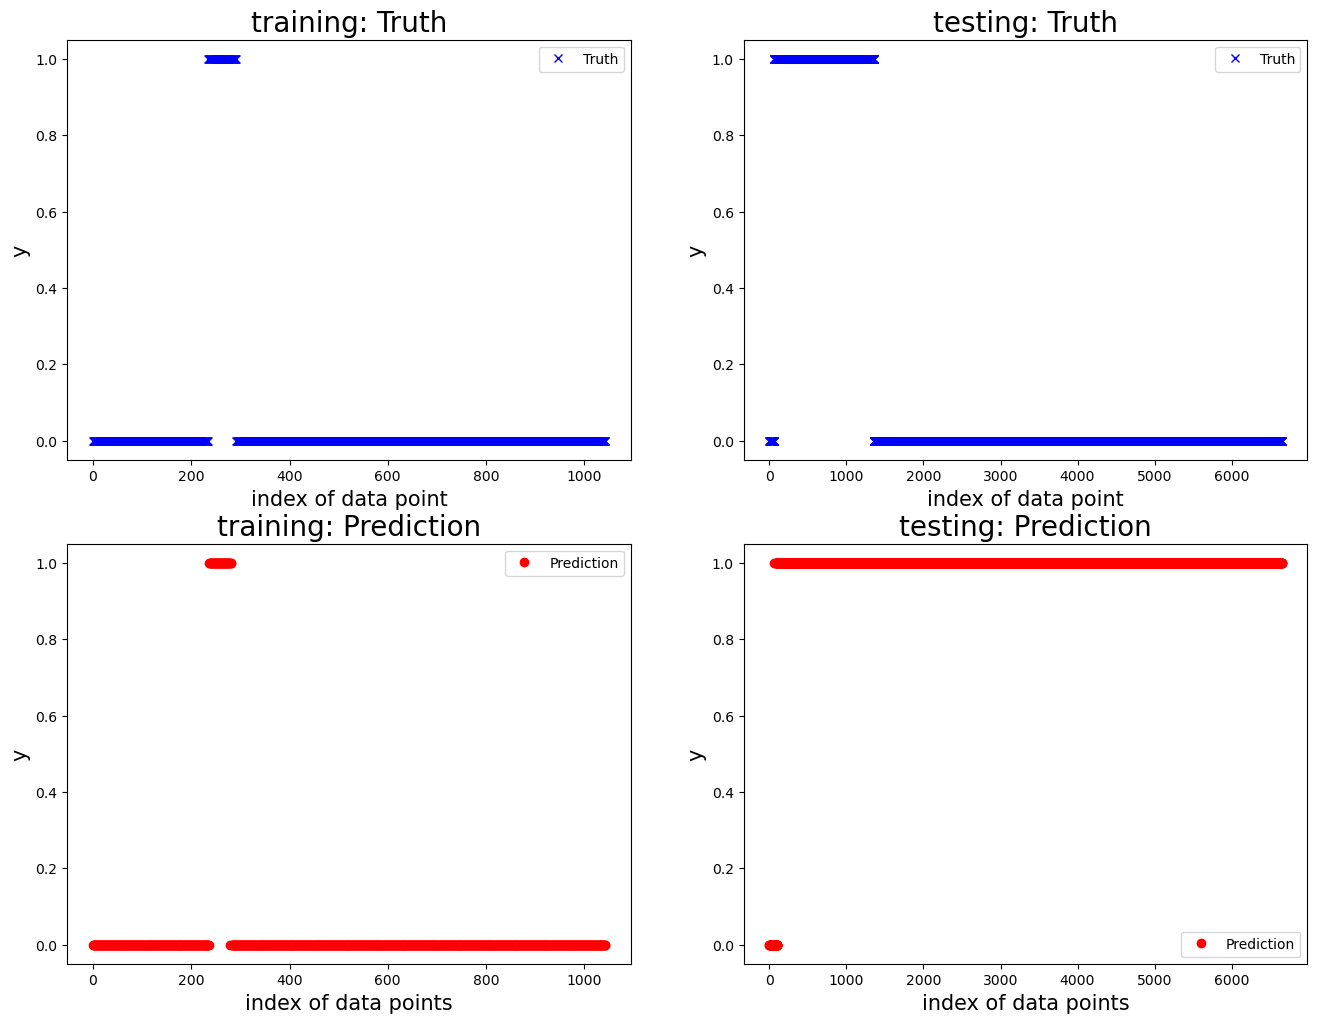


 New run:

training performance, accuracy is: 0.8758268190018039
training performance, precision is: 0.8922558922558923
training performance, recall: 0.4102167182662539
training performance, F1: 0.5620360551431601



 New run:

testing performance, accuracy is: 0.05459770114942529
testing performance, precision is: 0.05459770114942529
testing performance, recall: 1.0
testing performance, F1: 0.10354223433242507




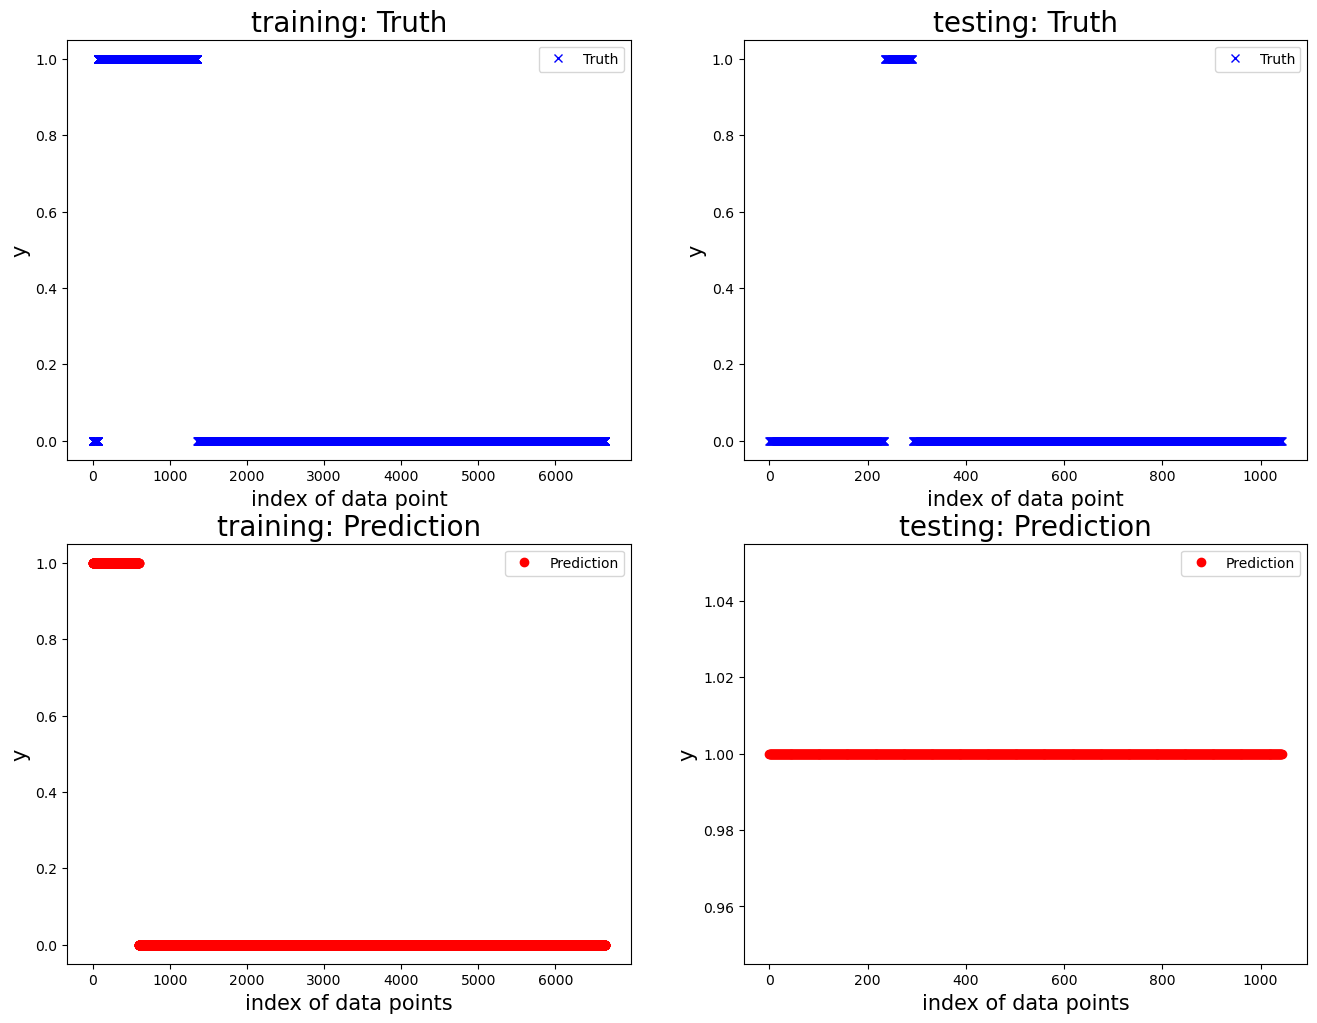

   Accuracy  Precision    Recall  F1 score
0  0.198737   0.191944  0.973684  0.320673
1  0.054598   0.054598  1.000000  0.103542


Mean performance metric and standard error:
Accuracy: 0.1267 +- 0.1019
Precision: 0.1233 +- 0.0971
Recall: 0.9868 +- 0.0186
F1 score: 0.2121 +- 0.1535




In [18]:
# Specify the test conditions you would like to include in the test.

df_data_new = read_all_test_data_from_path(base_dictionary, pre_processing, is_plot=False)

# Define the classification model.
# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('mdl', LogisticRegression(class_weight=None))    # Step 2: Linear Regression
]

# Create the pipeline
pipeline = Pipeline(steps)

df_data_new_r = df_data_new[df_data_new['test_condition'].isin(['20240426_140055', '20240325_155003'])]
n_cv = 2

feature_list_motor_1 = ['data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage']

all_result = run_cv_one_motor(motor_idx=1, df_data=df_data_new_r, mdl=pipeline, feature_list=feature_list_motor_1, n_fold=n_cv)

In [19]:
# Test with cross-validation on 155003

dictionary_name = '20240325_155003'
path = base_dictionary + dictionary_name

model = LocalOutlierFactor(n_neighbors=20)
def ro (feature):

    x = pd.DataFrame(ds, columns=['indice',feature])
    model.fit_predict(x)
    lof = model.negative_outlier_factor_ 
    df_out = pd.DataFrame({'indice': x['indice'], 'lof': lof })

    return df_out

features = ['data_motor_1_position', 'data_motor_2_position','data_motor_3_position',
            'data_motor_4_position','data_motor_5_position','data_motor_6_position',
            'data_motor_1_temperature', 'data_motor_2_temperature','data_motor_3_temperature',
            'data_motor_4_temperature','data_motor_5_temperature','data_motor_6_temperature',
            'data_motor_1_voltage', 'data_motor_2_voltage','data_motor_3_voltage',
            'data_motor_4_voltage','data_motor_5_voltage','data_motor_6_voltage']

ds = read_all_csvs_one_test(path, dictionary_name)
ds['indice'] = ds.reset_index().index

for j in range(len(features)):
    outliers = ro(features[j])
    thresh1 = np.quantile(outliers.lof, 1/3000)
    index = where(outliers.lof<=thresh1)
    final_index = np.ravel(outliers['indice'].iloc[0] + index)
    ds = ds[~ds['indice'].isin(final_index)]

# Dividi il dataset in base al valore di y
ds_class_0 = ds[ds['data_motor_1_label'] == 0]
ds_class_1 = ds[ds['data_motor_1_label'] == 1]

# Extract the features for motor 1: You should replace the features with the ones you have selected in WP1.
X = ds[['data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage']]
# Get the label
y = ds['data_motor_1_label']
frequenza_assoluta = np.bincount(y)

# Definisci il validatore KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Inizializza il modello di regressione logistica
model = LogisticRegression(penalty='l2', tol=0.0001, C=1.0, fit_intercept=True, 
                           intercept_scaling=1, class_weight=None, random_state=None, 
                           solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, 
                           warm_start=False, n_jobs=None, l1_ratio=None)

# Liste per memorizzare i punteggi di ogni fold
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Dividi i dati in set di addestramento/test utilizzando l'oggetto KFold
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Addestra il modello sui dati di addestramento
    model.fit(X_train, y_train)
    
    # Previsioni sul set di test
    y_pred = model.predict(X_test)
    
    # Calcola i punteggi e aggiungili alle liste
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

mean_accuracy = np.mean(accuracies)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)
mean_f1_score = np.mean(f1_scores)

print(f'Media Accuracy: {mean_accuracy}')
print(f'Media Precision: {mean_precision}')
print(f'Media Recall: {mean_recall}')
print(f'Media F1 Score: {mean_f1_score}')

Media Accuracy: 0.8767796999563491
Media Precision: 0.900461333746738
Media Recall: 0.4098784831587546
Media F1 Score: 0.562180382669681


## Whole Dataset

In [20]:
# Outlier Removal

df['indice'] = df.reset_index().index
model = LocalOutlierFactor(n_neighbors=20)

# We started defining a function that takes as input the test condition and the feature under analysis and gives as output a dataframe with  
# the index of the initial dataframe associated with the Local Outlier Factor of a specific point. This analysis is done for each activity done
# and for each feature, because all of these may have data with very different scales.

def ro (experiment, feature):

    ds = df.loc[df['test_condition'] == experiment]
    x = pd.DataFrame(ds, columns=['indice',feature])
    model.fit_predict(x)
    lof = model.negative_outlier_factor_ 
    df_out = pd.DataFrame({'indice': x['indice'], 'lof': lof })

    return df_out

datasets = ['20240105_164214', '20240105_165300', '20240105_165972',
           '20240320_152031', '20240320_153841', '20240320_155664', '20240321_122650',
           '20240325_135213', '20240325_152902', '20240325_155003',
           '20240425_093699', '20240425_094425', '20240426_140055',
           '20240426_141190', '20240426_141532', '20240426_141602',
           '20240426_141726', '20240426_141938', '20240426_141980']

features = ['data_motor_1_position', 'data_motor_2_position','data_motor_3_position',
            'data_motor_4_position','data_motor_5_position','data_motor_6_position',
            'data_motor_1_temperature', 'data_motor_2_temperature','data_motor_3_temperature',
            'data_motor_4_temperature','data_motor_5_temperature','data_motor_6_temperature',
            'data_motor_1_voltage', 'data_motor_2_voltage','data_motor_3_voltage',
            'data_motor_4_voltage','data_motor_5_voltage','data_motor_6_voltage']

voltage_columns = ['data_motor_1_voltage', 'data_motor_2_voltage', 'data_motor_3_voltage',
                    'data_motor_4_voltage', 'data_motor_5_voltage', 'data_motor_6_voltage']

# We decided not to modify the original dataframe

df_data = df.copy()

# We applied the function cycling on the activities and the features.
# Inside the cycles we removed from the copied dataframe those data which aren't part of the 1/3000 quantile of the LOF distribution.

for i in range(len(datasets)):
    for j in range(len(features)):
        outliers = ro(datasets[i], features[j])
        thresh1 = np.quantile(outliers.lof, 1/3000)
        index = where(outliers.lof<=thresh1)
        final_index = np.ravel(outliers['indice'].iloc[0] + index)
        df_data = df_data[~df_data['indice'].isin(final_index)]

# After this, we've seen that there are still some outliers in a bunch of activities, all of them related to the voltage data.
# In particular, we noticed that all these data were below the average of their distribution.
# So we decided to adopt a different approach to remove these data: ordering them from the highest to the lowest 
# and keeping the 99,5% first values.

critical_datasets = ['20240105_165300', '20240320_153841', '20240321_122650', '20240325_152902', '20240325_155003']

for i in range (len(critical_datasets)):
    for j in range(len(voltage_columns)):
        ds = df_data.loc[df_data['test_condition'] == critical_datasets[i]]
        x = pd.DataFrame(ds, columns=['indice',voltage_columns[j]])
        ds_sorted = ds.sort_values(by=[voltage_columns[j]], ascending=False)
        len_99 = int(len(ds_sorted) * 0.995)
        removed = ds_sorted.iloc[len_99:]
        removed_indices = removed['indice'].unique()
        df_data = df_data[~df_data['indice'].isin(removed_indices)]

In [21]:
# Modello 1: Cross-Validato Bilanciato (Rimozione)

# Dividi il dataset in base al valore di y
df_class_0 = df_data[df_data['data_motor_1_label'] == 0]
df_class_1 = df_data[df_data['data_motor_1_label'] == 1]

# Riduci casualmente il numero di istanze in df_class_0 di metà
df_class_0_reduced = df_class_0.sample(frac=0.045, random_state=42)

# Unisci i due gruppi per ottenere un nuovo dataset bilanciato
df_balanced = pd.concat([df_class_0_reduced, df_class_1])

# Extract the features for motor 1: You should replace the features with the ones you have selected in WP1.
X = df_balanced[['data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage']]
# Get the label
y = df_balanced['data_motor_1_label']
frequenza_assoluta = np.bincount(y)

# Definisci il validatore KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Inizializza il modello di regressione logistica
model = LogisticRegression(penalty='l2', tol=0.0001, C=1.0, fit_intercept=True, 
                           intercept_scaling=1, class_weight=None, random_state=None, 
                           solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, 
                           warm_start=False, n_jobs=None, l1_ratio=None)

# Liste per memorizzare i punteggi di ogni fold
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Dividi i dati in set di addestramento/test utilizzando l'oggetto KFold
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Addestra il modello sui dati di addestramento
    model.fit(X_train, y_train)
    
    # Previsioni sul set di test
    y_pred = model.predict(X_test)
    frequenza_assoluta = np.bincount(y_pred)
    print(frequenza_assoluta)
    
    # Calcola i punteggi e aggiungili alle liste
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

mean_accuracy = np.mean(accuracies)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)
mean_f1_score = np.mean(f1_scores)

print(f'Media Accuracy: {mean_accuracy}')
print(f'Media Precision: {mean_precision}')
print(f'Media Recall: {mean_recall}')
print(f'Media F1 Score: {mean_f1_score}')

[311 288]
[319 280]
[311 288]
[305 294]
[290 309]
Media Accuracy: 0.8717863105175292
Media Precision: 0.8224854974352199
Media Recall: 0.9065527816169835
Media F1 Score: 0.8622674147473077


In [22]:
# Modello 2: Cross-Validato Bilanciato (Classes)

# Extract the features for motor 1: You should replace the features with the ones you have selected in WP1.
X = df_data[['data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage']]
# Get the label
y = df_data['data_motor_1_label']
frequenza_assoluta = np.bincount(y)

# Definisci il validatore KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Inizializza il modello di regressione logistica
model = LogisticRegression(penalty='l2', tol=0.0001, C=1.0, fit_intercept=True, 
                           intercept_scaling=1, class_weight='balanced', random_state=None, 
                           solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, 
                           warm_start=False, n_jobs=None, l1_ratio=None)

# Liste per memorizzare i punteggi di ogni fold
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Dividi i dati in set di addestramento/test utilizzando l'oggetto KFold
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Addestra il modello sui dati di addestramento
    model.fit(X_train, y_train)
    
    # Previsioni sul set di test
    y_pred = model.predict(X_test)
    frequenza_assoluta = np.bincount(y_pred)
    print(frequenza_assoluta)
    # Calcola i punteggi e aggiungili alle liste
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    
    # Here you would train/test your model on the folds
    # model.fit(X_train, y_train)
    # model.predict(X_test)

# Calcola la media dei punteggi
mean_accuracy = np.mean(accuracies)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)
mean_f1_score = np.mean(f1_scores)

print(f'Media Accuracy: {mean_accuracy}')
print(f'Media Precision: {mean_precision}')
print(f'Media Recall: {mean_recall}')
print(f'Media F1 Score: {mean_f1_score}')

[6078 1617]
[6037 1658]
[6009 1685]
[6082 1612]
[6055 1639]
Media Accuracy: 0.818309375186322
Media Precision: 0.15495518841784797
Media Recall: 0.9615583871748352
Media F1 Score: 0.2668952269939824


In [23]:
# Modello 3: Cross-Validato Bilanciato (Duplicazione)

# Extract the features for motor 1: You should replace the features with the ones you have selected in WP1.
X_old = df_data[['data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage']]
# Get the label
y_old = df_data['data_motor_1_label']
frequenza_assoluta = np.bincount(y_old)

# Inizializza SMOTE
smote = SMOTE(random_state=42)

# Applica SMOTE per aumentare il numero di esempi della classe minoritaria (y=1)
X, y = smote.fit_resample(X_old, y_old)

# Crea un nuovo DataFrame dai dati aumentati
df_data_smote = pd.DataFrame(X, columns=['data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage'])
df_data_smote['y'] = y

# Extract the features for motor 1: You should replace the features with the ones you have selected in WP1.
X = df_data_smote[['data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage']]
# Get the label
y = df_data_smote['y']
frequenza_assoluta = np.bincount(y)
print(frequenza_assoluta)

# Definisci il validatore KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Inizializza il modello di regressione logistica
model = LogisticRegression(penalty='l2', tol=0.0001, C=1.0, fit_intercept=True, 
                           intercept_scaling=1, class_weight=None, random_state=None, 
                           solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, 
                           warm_start=False, n_jobs=None, l1_ratio=None)

# Liste per memorizzare i punteggi di ogni fold
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Dividi i dati in set di addestramento/test utilizzando l'oggetto KFold
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Addestra il modello sui dati di addestramento
    model.fit(X_train, y_train)
    
    # Previsioni sul set di test
    y_pred = model.predict(X_test)
    frequenza_assoluta = np.bincount(y_pred)
    print(frequenza_assoluta)
    # Calcola i punteggi e aggiungili alle liste
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    
    # Here you would train/test your model on the folds
    # model.fit(X_train, y_train)
    # model.predict(X_test)

# Calcola la media dei punteggi
mean_accuracy = np.mean(accuracies)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)
mean_f1_score = np.mean(f1_scores)

print(f'Media Accuracy: {mean_accuracy}')
print(f'Media Precision: {mean_precision}')
print(f'Media Recall: {mean_recall}')
print(f'Media F1 Score: {mean_f1_score}')

[37149 37149]
[6316 8544]
[6308 8552]
[6280 8580]
[6240 8619]
[6378 8481]
Media Accuracy: 0.8877628052731115
Media Precision: 0.8367391603517655
Media Recall: 0.9635130403890801
Media F1 Score: 0.895656165238535


In [24]:
# Modello 4: Non Cross-Validato Bilanciato

# Dividi il dataset in base al valore di y
df_class_0 = df_data[df_data['data_motor_1_label'] == 0]
df_class_1 = df_data[df_data['data_motor_1_label'] == 1]

# Riduci casualmente il numero di istanze in df_class_0 di metà
df_class_0_reduced = df_class_0.sample(frac=0.045, random_state=42)

# Unisci i due gruppi per ottenere un nuovo dataset bilanciato
df_balanced = pd.concat([df_class_0_reduced, df_class_1])

# Extract the features for motor 1: You should replace the features with the ones you have selected in WP1.
X = df_balanced[['data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage']]

# Get the label
y = df_balanced['data_motor_1_label']
frequenza_assoluta = np.bincount(y)
frequenza_assoluta

# Inizializza il modello di regressione logistica
model = LogisticRegression(penalty=None, tol=0.0001, C=1.0, fit_intercept=True, 
                           intercept_scaling=1, class_weight=None, random_state=None, 
                           solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, 
                           warm_start=False, n_jobs=None, l1_ratio=None)

# Liste per memorizzare i punteggi di ogni fold
accuracies = 0
precisions = 0
recalls = 0
f1_scores = 0

# Addestra il modello sui dati di addestramento
model.fit(X, y)
    
# Previsioni sul set di test
y_pred = model.predict(X)
frequenza_assoluta = np.bincount(y_pred)
print(frequenza_assoluta)

# Calcola i punteggi e aggiungili alle liste
accuracies=(accuracy_score(y, y_pred))
precisions=(precision_score(y, y_pred))
recalls=(recall_score(y, y_pred))
f1_scores=(f1_score(y, y_pred))

print(accuracies)
print(precisions)
print(recalls)
print(f1_scores)

[1536 1459]
0.8697829716193656
0.8197395476353667
0.9040060468631897
0.8598130841121495


In [26]:
# Modello 5: Cross-Validato Non Bilanciato 

X = df_data[['data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage']]
y = df_data['data_motor_1_label']

model = LogisticRegression(penalty='l2', tol=0.0001, C=1.0, fit_intercept=True, 
                           intercept_scaling=1, class_weight=None, random_state=None, 
                           solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, 
                           warm_start=False, n_jobs=None, l1_ratio=None)

accuracies = 0
precisions = 0
recalls = 0
f1_scores = 0

model.fit(X, y)

y_pred = model.predict(X)
frequenza_assoluta = np.bincount(y_pred)
print(frequenza_assoluta)

accuracies = (accuracy_score(y, y_pred))
precisions = (precision_score(y, y_pred))
recalls = (recall_score(y, y_pred))
f1_scores = (f1_score(y, y_pred))

[38470     2]


In [27]:
# Modello 6: Cross-Validato Non Bilanciato su divisioni casuali

# Dividi il dataset in base al valore di y
df_class_0 = df_data[df_data['data_motor_1_label'] == 0]
df_class_1 = df_data[df_data['data_motor_1_label'] == 1]

# Riduci casualmente il numero di istanze in df_class_0 di metà
df_class_0_reduced = df_class_0.sample(frac=0.045, random_state=42)

# Unisci i due gruppi per ottenere un nuovo dataset bilanciato
df_balanced = pd.concat([df_class_0_reduced, df_class_1])

def split_dataset_into_subsets(dataset, num_subsets=5):
    # Estrai gli indici casuali per le righe del dataset
    indices = np.random.permutation(len(dataset))
    
    # Calcola la dimensione di ciascun subset
    subset_size = len(dataset) // num_subsets
    
    # Calcola gli indici per iniziare e terminare ciascun subset
    subset_indices = [(i * subset_size, (i + 1) * subset_size) for i in range(num_subsets)]
    
    # Se il numero di righe non è divisibile per il numero di subset, aggiungi l'indice finale del dataset all'ultimo subset
    if len(dataset) % num_subsets != 0:
        subset_indices[-1] = (subset_indices[-1][0], len(dataset))
    
    # Dividi il dataset in base agli indici calcolati
    subsets = [dataset.iloc[indices[start:end]] for start, end in subset_indices]
    
    return subsets

# Dividi il dataset in 5 subset
subsets = split_dataset_into_subsets(df_balanced, 5)

# Inizializza il modello di regressione logistica
model = LogisticRegression(penalty=None, tol=0.0001, C=1.0, fit_intercept=True, 
                           intercept_scaling=1, class_weight=None, random_state=None, 
                           solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, 
                           warm_start=False, n_jobs=None, l1_ratio=None)

trained_models = []

for i, subset in enumerate(subsets):
    print(f"Subset {i+1}:")

    # Estrai le features (X) e i target (y) dal subset
    X_subset = subset[['data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage']]
    y_subset = subset['data_motor_1_label']
    
    frequenza = np.bincount(y_subset)
    print(frequenza)

    # Addestra il modello sul subset corrente
    model.fit(X_subset, y_subset)
    y_pred_subset = model.predict(X_subset)
    
    # Aggiungi il modello addestrato alla lista
    trained_models.append(model)

    frequenza_assoluta = np.bincount(y_pred_subset)
    print(frequenza_assoluta)

    # Calcola i punteggi e aggiungili alle liste
    accuracies=(accuracy_score(y_subset, y_pred_subset))
    precisions=(precision_score(y_subset, y_pred_subset))
    recalls=(recall_score(y_subset, y_pred_subset))
    f1_scores=(f1_score(y_subset, y_pred_subset))

    print("Accuracy:", accuracies)
    print("Precision:", precisions)
    print("Recall:", recalls)
    print("F1:", f1_scores)
    print("")

Subset 1:
[338 261]
[317 282]
Accuracy: 0.8614357262103506
Precision: 0.8156028368794326
Recall: 0.8812260536398467
F1: 0.8471454880294659

Subset 2:
[314 285]
[285 314]
Accuracy: 0.9382303839732888
Precision: 0.8949044585987261
Recall: 0.9859649122807017
F1: 0.9382303839732888

Subset 3:
[342 257]
[320 279]
Accuracy: 0.8797996661101837
Precision: 0.8315412186379928
Recall: 0.9027237354085603
F1: 0.8656716417910447

Subset 4:
[339 260]
[322 277]
Accuracy: 0.8380634390651085
Precision: 0.7942238267148014
Recall: 0.8461538461538461
F1: 0.819366852886406

Subset 5:
[339 260]
[306 293]
Accuracy: 0.8514190317195326
Precision: 0.7918088737201365
Recall: 0.8923076923076924
F1: 0.8390596745027125



Write your discussions here:


# Task 3: Develop classification-based fault detection models

In this task, you are supposed to experiment different classification-based fault detection models to get best F1 score. Please use the 5-fold cross-validation to calculate the best F1 score. You are free to try different models, whether they are discussed in the class or not. To simply your work, you can use the models existed in [scikit-learn](https://scikit-learn.org/stable/supervised_learning.html).

Please report all the models you tried, how to you tune their hyperparameters, and the corresponding F1 score. Please note that if you would like to tune the hyperparameter, you can use the `GridSearchCv` function in scikit-learn, but you should use it only on the training dataset.

## Whole Dataset

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import LinearSVC

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

In [9]:
# Data Reading

df = read_all_test_data_from_path(base_dictionary, is_plot=False)

In [5]:
# Outlier Removal

model = LocalOutlierFactor(n_neighbors=20)

df['indice'] = df.reset_index().index

# We started defining a function that takes as input the test condition and the feature under analysis and gives as output a dataframe with  
# the index of the initial dataframe associated with the Local Outlier Factor of a specific point. This analysis is done for each activity done
# and for each feature, because all of these may have data with very different scales.

def ro (experiment, feature):

    ds = df.loc[df['test_condition'] == experiment]
    x = pd.DataFrame(ds, columns=['indice',feature])
    model.fit_predict(x)
    lof = model.negative_outlier_factor_ 
    df_out = pd.DataFrame({'indice': x['indice'], 'lof': lof })

    return df_out

datasets = ['20240105_164214', '20240105_165300', '20240105_165972',
           '20240320_152031', '20240320_153841', '20240320_155664', '20240321_122650',
           '20240325_135213', '20240325_152902', '20240325_155003',
           '20240425_093699', '20240425_094425', '20240426_140055',
           '20240426_141190', '20240426_141532', '20240426_141602',
           '20240426_141726', '20240426_141938', '20240426_141980']

features = ['data_motor_1_position', 'data_motor_2_position','data_motor_3_position',
            'data_motor_4_position','data_motor_5_position','data_motor_6_position',
            'data_motor_1_temperature', 'data_motor_2_temperature','data_motor_3_temperature',
            'data_motor_4_temperature','data_motor_5_temperature','data_motor_6_temperature',
            'data_motor_1_voltage', 'data_motor_2_voltage','data_motor_3_voltage',
            'data_motor_4_voltage','data_motor_5_voltage','data_motor_6_voltage']

voltage_columns = ['data_motor_1_voltage', 'data_motor_2_voltage', 'data_motor_3_voltage',
                    'data_motor_4_voltage', 'data_motor_5_voltage', 'data_motor_6_voltage']

# We decided not to modify the original dataframe

df_data = df.copy()

# We applied the function cycling on the activities and the features.
# Inside the cycles we removed from the copied dataframe those data which aren't part of the 1/3000 quantile of the LOF distribution.

for i in range(len(datasets)):
    for j in range(len(features)):
        outliers = ro(datasets[i], features[j])
        thresh1 = np.quantile(outliers.lof, 1/3000)
        index = where(outliers.lof<=thresh1)
        final_index = np.ravel(outliers['indice'].iloc[0] + index)
        df_data = df_data[~df_data['indice'].isin(final_index)]

# After this, we've seen that there are still some outliers in a bunch of activities, all of them related to the voltage data.
# In particular, we noticed that all these data were below the average of their distribution.
# So we decided to adopt a different approach to remove these data: ordering them from the highest to the lowest 
# and keeping the 99,5% first values.

critical_datasets = ['20240105_165300', '20240320_153841', '20240321_122650', '20240325_152902', '20240325_155003']

for i in range (len(critical_datasets)):
    for j in range(len(voltage_columns)):
        ds = df_data.loc[df_data['test_condition'] == critical_datasets[i]]
        x = pd.DataFrame(ds, columns=['indice',voltage_columns[j]])
        ds_sorted = ds.sort_values(by=[voltage_columns[j]], ascending=False)
        len_99 = int(len(ds_sorted) * 0.995)
        removed = ds_sorted.iloc[len_99:]
        removed_indices = removed['indice'].unique()
        df_data = df_data[~df_data['indice'].isin(removed_indices)]

# Standardization

scaler = StandardScaler()
columns_to_standardize = ['data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                          'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                          'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                          'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                          'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                          'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage',
                          ]

# Standardizzare le colonne selezionate
df_data[columns_to_standardize] = scaler.fit_transform(df_data[columns_to_standardize])

In [31]:
# Over Sampling

# Extract the features for motor 1: You should replace the features with the ones you have selected in WP1.
X_old = df_data[['data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage']]
# Get the label
y_old = df_data['data_motor_1_label']
frequenza_assoluta = np.bincount(y_old)

# Inizializza SMOTE
smote = SMOTE(random_state=42)

# Applica SMOTE per aumentare il numero di esempi della classe minoritaria (y=1)
X, y = smote.fit_resample(X_old, y_old)

# Crea un nuovo DataFrame dai dati aumentati
df_data_smote = pd.DataFrame(X, columns=['data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage'])
df_data_smote['y'] = y

# Extract the features for motor 1: You should replace the features with the ones you have selected in WP1.
X = df_data_smote[['data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage']]

# Get the label
y = df_data_smote['y']

# KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

frequenza_assoluta = np.bincount(y)
print(frequenza_assoluta)

[37149 37149]


Dati iniziali


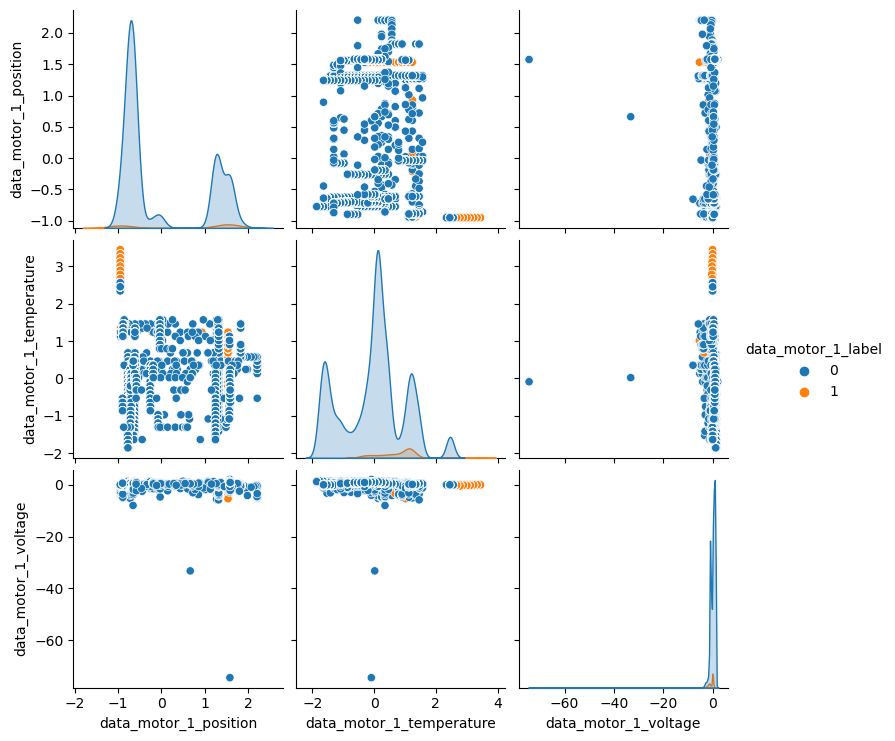

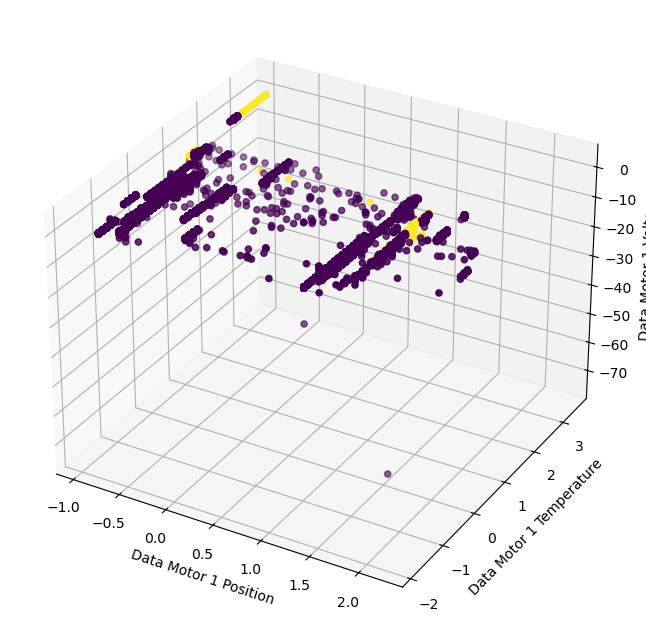

Dati dopo over sampling


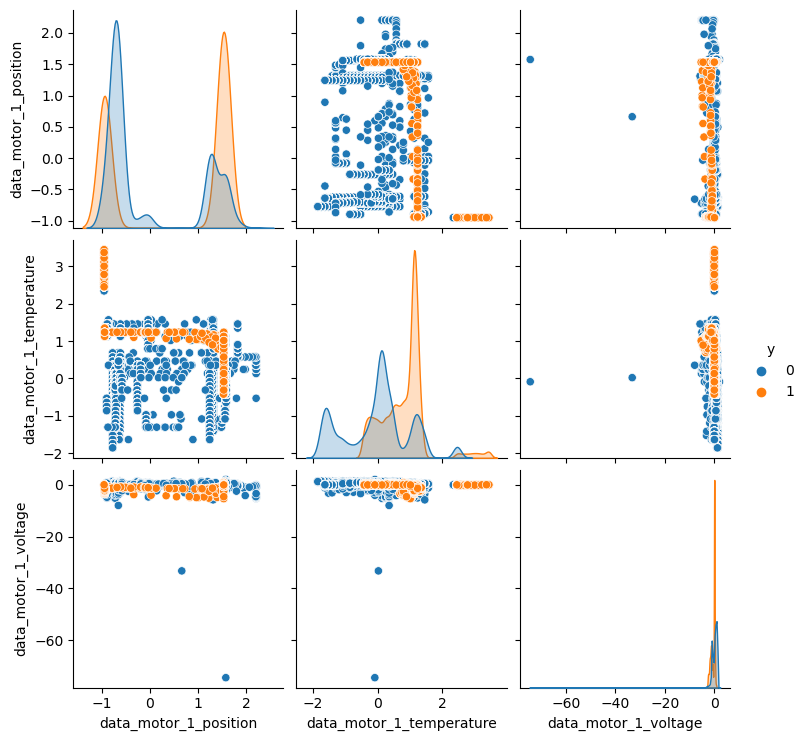

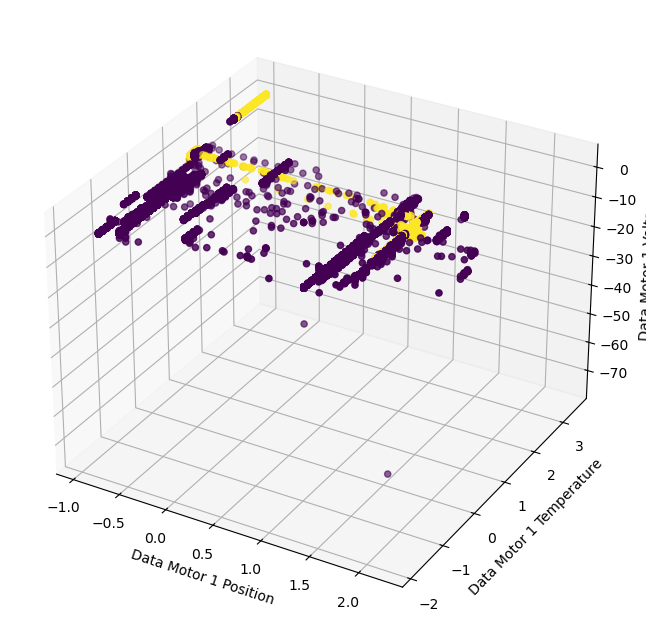

In [33]:
# Data Visualization

import seaborn as sns
import warnings

print("Dati iniziali")

warnings.filterwarnings("ignore")
sns.pairplot(df_data, hue='data_motor_1_label', vars=['data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage'])

from mpl_toolkits.mplot3d import Axes3D

# Crea una figura e un'istanza di Axes3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Traccia lo scatterplot tridimensionale
ax.scatter(df_data['data_motor_1_position'], df_data['data_motor_1_temperature'], df_data['data_motor_1_voltage'], c=df_data['data_motor_1_label'])

# Etichette degli assi
ax.set_xlabel('Data Motor 1 Position')
ax.set_ylabel('Data Motor 1 Temperature')
ax.set_zlabel('Data Motor 1 Voltage')

# Visualizza il grafico
plt.show()

print("Dati dopo over sampling")

warnings.filterwarnings("ignore")
sns.pairplot(df_data_smote, hue='y', vars=['data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage'])

# Crea una figura e un'istanza di Axes3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Traccia lo scatterplot tridimensionale
ax.scatter(df_data_smote['data_motor_1_position'], df_data_smote['data_motor_1_temperature'], df_data_smote['data_motor_1_voltage'], c=df_data_smote['y'])

# Etichette degli assi
ax.set_xlabel('Data Motor 1 Position')
ax.set_ylabel('Data Motor 1 Temperature')
ax.set_zlabel('Data Motor 1 Voltage')

# Visualizza il grafico
plt.show()

## Logistic Regression

In [34]:
# Default LR

frequenza_assoluta = np.bincount(y)
print(frequenza_assoluta)

# Inizializza il modello di regressione logistica
lr_model = LogisticRegression(penalty='l2', tol=0.0001, C=1.0, fit_intercept=True, 
                           intercept_scaling=1, class_weight=None, random_state=42, 
                           solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, 
                           warm_start=False, n_jobs=None, l1_ratio=None)

# Liste per memorizzare i punteggi di ogni fold
accuracies = []
precisions = []
recalls = []
f1_scores = []

i = 1
lr_models = []

# Dividi i dati in set di addestramento/test utilizzando l'oggetto KFold
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    print("Iterazione: ", i )
    frequenza = np.bincount(y_train)
    print(frequenza)
    
    # Addestra il modello sui dati di addestramento
    lr_model.fit(X_train, y_train)
    
    # Previsioni sul set di test
    y_pred = lr_model.predict(X_test)

    frequenza_assoluta = np.bincount(y_pred)
    print(frequenza_assoluta)
    print("")
    
    # Calcola i punteggi e aggiungili alle liste
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    lr_models.append(lr_model)

    i = i+1

# Risultati medi
accuracy = sum(accuracies)/len(accuracies)
precision = sum(precisions)/len(precisions)
recall = sum(recalls)/len(recalls)
f1 = sum(f1_scores)/len(f1_scores)

# Stampa i punteggi del modello con F1-score più alto
print("Best Model Scores:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

[37149 37149]
Iterazione:  1
[29716 29722]
[6326 8534]

Iterazione:  2
[29708 29730]
[6322 8538]

Iterazione:  3
[29724 29714]
[6305 8555]

Iterazione:  4
[29844 29595]
[6240 8619]

Iterazione:  5
[29604 29835]
[6367 8492]

Best Model Scores:
Accuracy: 0.8884357790507578
Precision: 0.8376255013499314
Recall: 0.9636821807338546
F1 Score: 0.8962361978511426


In [35]:
# Hyper-parameter tuning per Regressione Logistica

logistic_regression = LogisticRegression(max_iter=100, random_state=42)

# Definizione della griglia dei parametri
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs', 'sag', 'saga']
}

# Creazione di un oggetto GridSearchCV
grid_search = GridSearchCV(estimator=logistic_regression, param_grid=param_grid, cv=5, scoring='f1')

# Esecuzione della ricerca della griglia
grid_search.fit(X, y)

# Visualizzazione dei migliori parametri e punteggio
print("Best Parameters for Logistic Regression:", grid_search.best_params_)
print("Best F1 Score for Logistic Regression:", grid_search.best_score_)

Best Parameters for Logistic Regression: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Best F1 Score for Logistic Regression: 0.8834986774060033


## Support Vector Machine SVM


In [10]:
# SVM con Kernel Lineare

i = 1

# Inizializza il modello di svm con kernel lineare
svm_l_model = LinearSVC(loss='hinge', dual=True, random_state=42, max_iter=1000)

# Liste per memorizzare i punteggi di ogni fold
accuracies = []
precisions = []
recalls = []
f1_scores = []
svm_l_models = []

for train_index, test_index in kf.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    print("Iterazione: ", i)
    frequenza = np.bincount(y_train)
    print(frequenza)

    svm_l_model.fit(X_train, y_train)

    # Previsioni sul set di test
    y_pred = svm_l_model.predict(X_test)

    frequenza_assoluta = np.bincount(y_pred)
    print(frequenza_assoluta)
    print("")
    
    # Calcola i punteggi e aggiungili alle liste
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    svm_l_models.append(svm_l_model)

    i = i+1

# Risultati medi
accuracy = sum(accuracies)/len(accuracies)
precision = sum(precisions)/len(precisions)
recall = sum(recalls)/len(recalls)
f1 = sum(f1_scores)/len(f1_scores)

# Stampa i punteggi del modello con F1-score più alto
print("Best Model Scores:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")



Iterazione:  1
[26600 26560]


c:\Users\gioca\GitHub\Group_6\.conda\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[5204 8086]

Iterazione:  2
[26578 26582]


c:\Users\gioca\GitHub\Group_6\.conda\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[5243 8047]

Iterazione:  3
[26655 26505]


c:\Users\gioca\GitHub\Group_6\.conda\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[5229 8061]

Iterazione:  4
[26582 26578]


c:\Users\gioca\GitHub\Group_6\.conda\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[5276 8014]

Iterazione:  5
[26485 26675]
[5369 7921]

Best Model Scores:
Accuracy: 0.8812039127163281
Precision: 0.8156152021149345
Recall: 0.9851019266915314
F1 Score: 0.8923788169923125


c:\Users\gioca\GitHub\Group_6\.conda\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [11]:
# Hyper-parameter tuning per SVM Lineare

svm_linear = LinearSVC(loss='hinge', dual=True, random_state=42, max_iter=1000)

# Definizione della griglia dei parametri
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Creazione di un oggetto GridSearchCV
grid_search_svm_linear = GridSearchCV(estimator=svm_linear, param_grid=param_grid, cv=5, scoring='f1')

# Esecuzione della ricerca della griglia
grid_search_svm_linear.fit(X, y)

# Visualizzazione dei migliori parametri e punteggio
print("Best Parameters for SVM with Linear Kernel:", grid_search_svm_linear.best_params_)
print("Best F1 Score for SVM with Linear Kernel:", grid_search_svm_linear.best_score_)

Best Parameters for SVM with Linear Kernel: {'C': 0.01}
Best F1 Score for SVM with Linear Kernel: 0.6737877844466473


In [11]:
# SVM con Kernel Polinomiale

i = 1

# Inizializza il modello di svm con kernel polinomiale

svm_p_model = SVC(kernel='poly', degree=2, gamma='auto', coef0=1, C=1.0, max_iter=1000, random_state=42)

# Liste per memorizzare i punteggi di ogni fold
accuracies = []
precisions = []
recalls = []
f1_scores = []
svm_p_models = []

for train_index, test_index in kf.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    print("Iterazione: ", i )
    frequenza = np.bincount(y_train)
    print(frequenza)

    svm_p_model.fit(X_train, y_train)

    # Previsioni sul set di test
    y_pred = svm_p_model.predict(X_test)

    frequenza_assoluta = np.bincount(y_pred)
    print(frequenza_assoluta)
    print("")
    
    # Calcola i punteggi e aggiungili alle liste
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    svm_p_models.append(svm_p_model)

    i = i+1

# Risultati medi
accuracy = sum(accuracies)/len(accuracies)
precision = sum(precisions)/len(precisions)
recall = sum(recalls)/len(recalls)
f1 = sum(f1_scores)/len(f1_scores)

# Stampa i punteggi del modello con F1-score più alto
print("Best Model Scores:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Iterazione:  1
[26600 26560]


c:\Users\gioca\GitHub\Group_6\.conda\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[   28 13262]

Iterazione:  2
[26578 26582]


c:\Users\gioca\GitHub\Group_6\.conda\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[7100 6190]

Iterazione:  3
[26655 26505]


c:\Users\gioca\GitHub\Group_6\.conda\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[   53 13237]

Iterazione:  4
[26582 26578]


c:\Users\gioca\GitHub\Group_6\.conda\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[   29 13261]

Iterazione:  5
[26485 26675]


c:\Users\gioca\GitHub\Group_6\.conda\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[   25 13265]

Best Model Scores:
Accuracy: 0.4871331828442438
Precision: 0.485905958155972
Recall: 0.8782186726798178
F1 Score: 0.6158209203971616


In [13]:
# Hyper-parameter tuning per SVM Polinomiale

svm_poly = SVC(kernel='poly', max_iter=1000, random_state=42)

# Definizione della griglia dei parametri
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto']}

# Creazione di un oggetto GridSearchCV
grid_search_svm_poly = GridSearchCV(estimator=svm_poly, param_grid=param_grid, cv=5, scoring='f1')

# Esecuzione della ricerca della griglia
grid_search_svm_poly.fit(X, y)

# Visualizzazione dei migliori parametri e punteggio
print("Best Parameters for SVM with Polynomial Kernel:", grid_search_svm_poly.best_params_)
print("Best F1 Score for SVM with Polynomial Kernel:", grid_search_svm_poly.best_score_)

Best Parameters for SVM with Polynomial Kernel: {'C': 1, 'degree': 3, 'gamma': 'auto'}
Best F1 Score for SVM with Polynomial Kernel: 0.6799803457524594


In [12]:
# SVM con Kernel Radiale

i = 1

# Inizializza il modello di svm con kernel radiale
svm_r_model = SVC(kernel='rbf', gamma=0.5, C=1.0, random_state=42, max_iter=1000)

# Liste per memorizzare i punteggi di ogni fold
accuracies = []
precisions = []
recalls = []
f1_scores = []
svm_r_models = []

for train_index, test_index in kf.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    print("Iterazione: ", i )
    frequenza = np.bincount(y_train)
    print("Dataset training: ", frequenza)
    frequenza = np.bincount(y_test)
    print("Dataset test: ", frequenza)

    svm_r_model.fit(X_train, y_train)

    # Previsioni sul set di test
    y_pred = svm_r_model.predict(X_test)

    frequenza_assoluta = np.bincount(y_pred)
    print("Previsione: ", frequenza_assoluta)
    print("")
    
    # Calcola i punteggi e aggiungili alle liste
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    svm_r_models.append(svm_r_model)

    i = i+1

# Risultati medi
accuracy = sum(accuracies)/len(accuracies)
precision = sum(precisions)/len(precisions)
recall = sum(recalls)/len(recalls)
f1 = sum(f1_scores)/len(f1_scores)

# Stampa i punteggi del modello con F1-score più alto
print("Best Model Scores:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Iterazione:  1
Dataset training:  [26600 26560]
Dataset test:  [6625 6665]


c:\Users\gioca\GitHub\Group_6\.conda\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Previsione:  [ 2975 10315]

Iterazione:  2
Dataset training:  [26578 26582]
Dataset test:  [6647 6643]


c:\Users\gioca\GitHub\Group_6\.conda\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Previsione:  [6225 7065]

Iterazione:  3
Dataset training:  [26655 26505]
Dataset test:  [6570 6720]


c:\Users\gioca\GitHub\Group_6\.conda\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Previsione:  [ 1811 11479]

Iterazione:  4
Dataset training:  [26582 26578]
Dataset test:  [6643 6647]


c:\Users\gioca\GitHub\Group_6\.conda\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Previsione:  [ 1927 11363]

Iterazione:  5
Dataset training:  [26485 26675]
Dataset test:  [6740 6550]


c:\Users\gioca\GitHub\Group_6\.conda\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Previsione:  [ 1809 11481]

Best Model Scores:
Accuracy: 0.6987509405568095
Precision: 0.6440342583203504
Recall: 0.9768167916592514
F1 Score: 0.7692562898052968


In [15]:
# Hyper-parameter tuning per SVM Radiale

svm_rbf = SVC(kernel='rbf', random_state=42, max_iter=1000)

# Definizione della griglia dei parametri
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']}

# Creazione di un oggetto GridSearchCV
grid_search_svm_rbf = GridSearchCV(estimator=svm_rbf, param_grid=param_grid, cv=5, scoring='f1')

# Esecuzione della ricerca della griglia
grid_search_svm_rbf.fit(X, y)

# Visualizzazione dei migliori parametri e punteggio
print("Best Parameters for SVM with RBF Kernel:", grid_search_svm_rbf.best_params_)
print("Best F1 Score for SVM with RBF Kernel:", grid_search_svm_rbf.best_score_)

Best Parameters for SVM with RBF Kernel: {'C': 1, 'gamma': 'auto'}
Best F1 Score for SVM with RBF Kernel: 0.8146980745482431


## Random Forest

In [13]:
i = 1

# Inizializza il modello di rf

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Liste per memorizzare i punteggi di ogni fold
accuracies = []
precisions = []
recalls = []
f1_scores = []
cms = []
rf_models = []

for train_index, test_index in kf.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    print("Iterazione: ", i )
    frequenza = np.bincount(y_train)
    print("Dataset training: ", frequenza)
    frequenza = np.bincount(y_test)
    print("Dataset test: ", frequenza)

    rf_model.fit(X_train, y_train)

    # Previsioni sul set di test
    y_pred = rf_model.predict(X_test)

    frequenza_assoluta = np.bincount(y_pred)
    print("Previsione: ", frequenza_assoluta)
    print("")
    
    # Calcola i punteggi e aggiungili alle liste
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    rf_models.append(rf_model)

    cms.append(confusion_matrix(y_test, y_pred))

    i = i+1

# Risultati medi
accuracy = sum(accuracies)/len(accuracies)
precision = sum(precisions)/len(precisions)
recall = sum(recalls)/len(recalls)
f1 = sum(f1_scores)/len(f1_scores)

# Stampa i punteggi del modello con F1-score più alto
print("Best Model Scores:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Iterazione:  1
Dataset training:  [26600 26560]
Dataset test:  [6625 6665]
Previsione:  [6627 6663]

Iterazione:  2
Dataset training:  [26578 26582]
Dataset test:  [6647 6643]
Previsione:  [6635 6655]

Iterazione:  3
Dataset training:  [26655 26505]
Dataset test:  [6570 6720]
Previsione:  [6557 6733]

Iterazione:  4
Dataset training:  [26582 26578]
Dataset test:  [6643 6647]
Previsione:  [6631 6659]

Iterazione:  5
Dataset training:  [26485 26675]
Dataset test:  [6740 6550]
Previsione:  [6735 6555]

Best Model Scores:
Accuracy: 0.9953348382242287
Precision: 0.9947351099646596
Recall: 0.9959304185296126
F1 Score: 0.9953322207991222


In [17]:
# Hyper-parameter tuning per Random Forest

random_forest = RandomForestClassifier(random_state=42)

# Definizione della griglia dei parametri
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]}

# Creazione di un oggetto GridSearchCV
grid_search_rf = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5, scoring='f1')

# Esecuzione della ricerca della griglia
grid_search_rf.fit(X, y)

# Visualizzazione dei migliori parametri e punteggio
print("Best Parameters for Random Forest:", grid_search_rf.best_params_)
print("Best F1 Score for Random Forest:", grid_search_rf.best_score_)

Best Parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 200}
Best F1 Score for Random Forest: 0.947697708434271


## Selected Dataset

In [6]:
import numpy as np 
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings

from utility import read_all_test_data_from_path
from utility import run_cv_one_motor

%matplotlib inline

In [7]:
# Subfunction for data preprocessing.

def pre_processing(df: pd.DataFrame):
    ''' ### Description
    Preprocess the data:
    - remove outliers
    - add new features about the difference between the current and previous n data point.
    '''
    
    def remove_outliers(df: pd.DataFrame):
        ''' # Description
        Remove outliers from the dataframe based on defined valid ranges. 
        Define a valid range of temperature and voltage. 
        Use ffil function to replace the invalid measurement with the previous value.
        '''
        df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
        df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
        df['temperature'] = df['temperature'].ffill()        

        df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
        df['voltage'] = df['voltage'].where(df['voltage'] <= 9000, np.nan)
        df['voltage'] = df['voltage'].ffill()        

        df['position'] = df['position'].where(df['position'] >= 0, np.nan)
        df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
        df['position'] = df['position'].ffill()


    def cal_diff(df: pd.DataFrame, n_int: int):
        ''' # Description
        Calculate the difference between the current and previous n data point.
        '''
        # Tranform the features relative to the first data point.
        df['temperature'] = df['temperature'] - df['temperature'].iloc[0]
        df['voltage'] = df['voltage'] - df['voltage'].iloc[0]
        df['position'] = df['position'] - df['position'].iloc[0]

        # Calculate the difference between the current and previous n data point.
        df['temperature_diff'] = df['temperature'].diff(n_int)
        df['voltage_diff'] = df['voltage'].diff(n_int)
        df['position_diff'] = df['position'].diff(n_int)   

    # Start processing.
    remove_outliers(df)
    n_int = 20
    cal_diff(df, n_int)


# Ignore warnings.
warnings.filterwarnings('ignore')

In [8]:
# Data Reading and Preprocessing

base_dictionary = 'C:/Users/gioca/GitHub/projects/maintenance_industry_4_2024/dataset/training_data/'
df_data = read_all_test_data_from_path(base_dictionary, pre_processing, is_plot=False)

In [63]:
# Feature Selection
feature_list = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']

all_feature = ['data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
               'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
               'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
               'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
               'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
               'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']

window_size = 50
sample_step = 10

# Test Selection.
test_list = ['20240425_093699', '20240425_094425', '20240426_140055',
             '20240503_164675', '20240503_165189', '20240503_163963', '20240325_155003']

test_not_moving = ['20240425_093699', '20240425_094425', '20240426_140055']
test_move = ['20240503_164675', '20240503_165189']
test_pickup_place = ['20240503_163963', '20240325_155003']

n_cv = len(test_list)

df_data_experiment = df_data[df_data['test_condition'].isin(test_list)]
frequenza = np.bincount(df_data_experiment['data_motor_6_label'])
print('frequenze dataset totale: ')
print(frequenza)
print("")

df_data_not_moving = df_data[df_data['test_condition'].isin(test_not_moving)]
n_cv_not_moving = len(test_not_moving)

df_data_move = df_data[df_data['test_condition'].isin(test_move)]
n_cv_move = len(test_move)

df_data_pickup_place = df_data[df_data['test_condition'].isin(test_pickup_place)]
n_cv_pickup_place = len(test_pickup_place)

frequenze dataset totale: 
[8940 1932]



<Axes: xlabel='features', ylabel='value'>

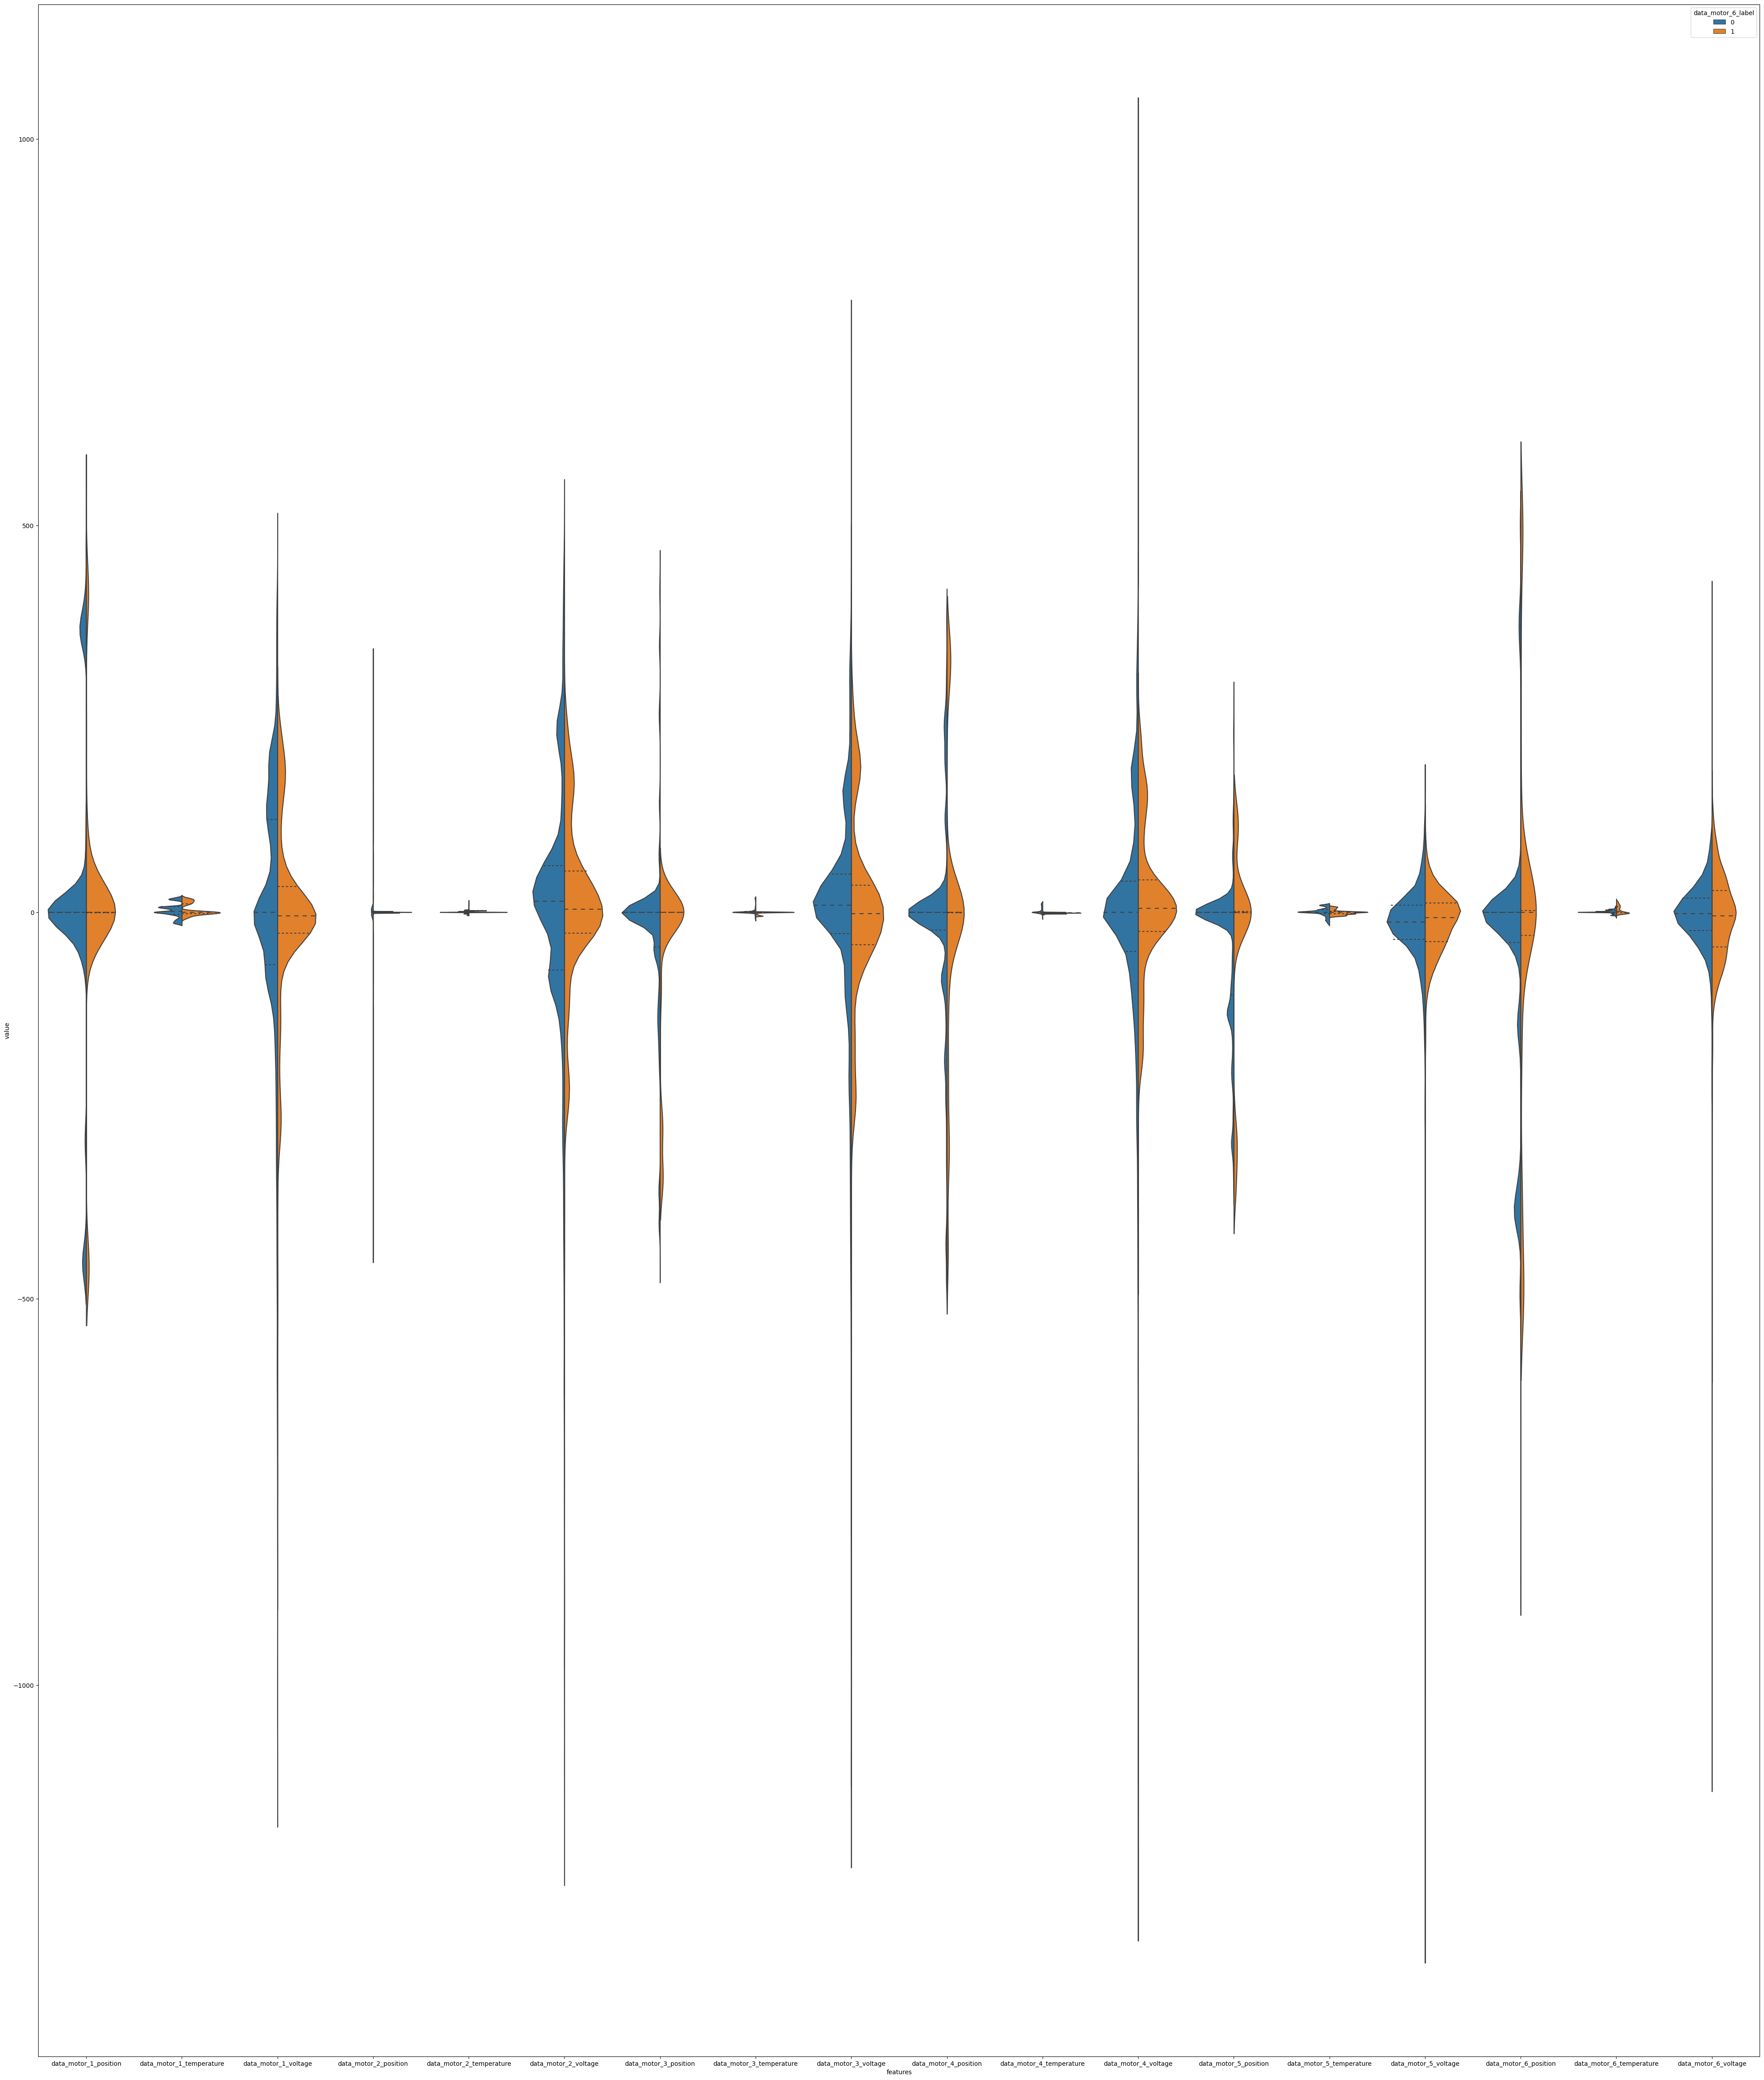

In [47]:
# For selecting the features, we analyze the violin plots related to motor 6 label

import seaborn as sns
import matplotlib.pyplot as plt

remove_columns = ['time', 'test_condition', 
                  'data_motor_1_label', 'data_motor_2_label', 'data_motor_3_label',
                  'data_motor_4_label', 'data_motor_5_label', 'data_motor_6_label', 
                  'data_motor_1_temperature_diff', 'data_motor_1_position_diff', 'data_motor_1_voltage_diff',
                  'data_motor_2_temperature_diff', 'data_motor_2_position_diff', 'data_motor_2_voltage_diff',
                  'data_motor_3_temperature_diff', 'data_motor_3_position_diff', 'data_motor_3_voltage_diff',
                  'data_motor_4_temperature_diff', 'data_motor_4_position_diff', 'data_motor_4_voltage_diff',
                  'data_motor_5_temperature_diff', 'data_motor_5_position_diff', 'data_motor_5_voltage_diff',
                  'data_motor_6_temperature_diff', 'data_motor_6_position_diff', 'data_motor_6_voltage_diff']

df_data_without_column = df_data.drop(columns=remove_columns, axis=1)
columns = df_data_without_column.columns.tolist()
y = df_data.data_motor_6_label
x = pd.DataFrame(df_data_without_column, columns=columns)
data = pd.concat([y, x],axis=1)
data = pd.melt(data, id_vars='data_motor_6_label', var_name="features", value_name='value')
plt.figure(figsize=(50, 60))
sns.violinplot(x="features", y="value", hue="data_motor_6_label", data=data,split=True, inner="quart")

Not Moving: 


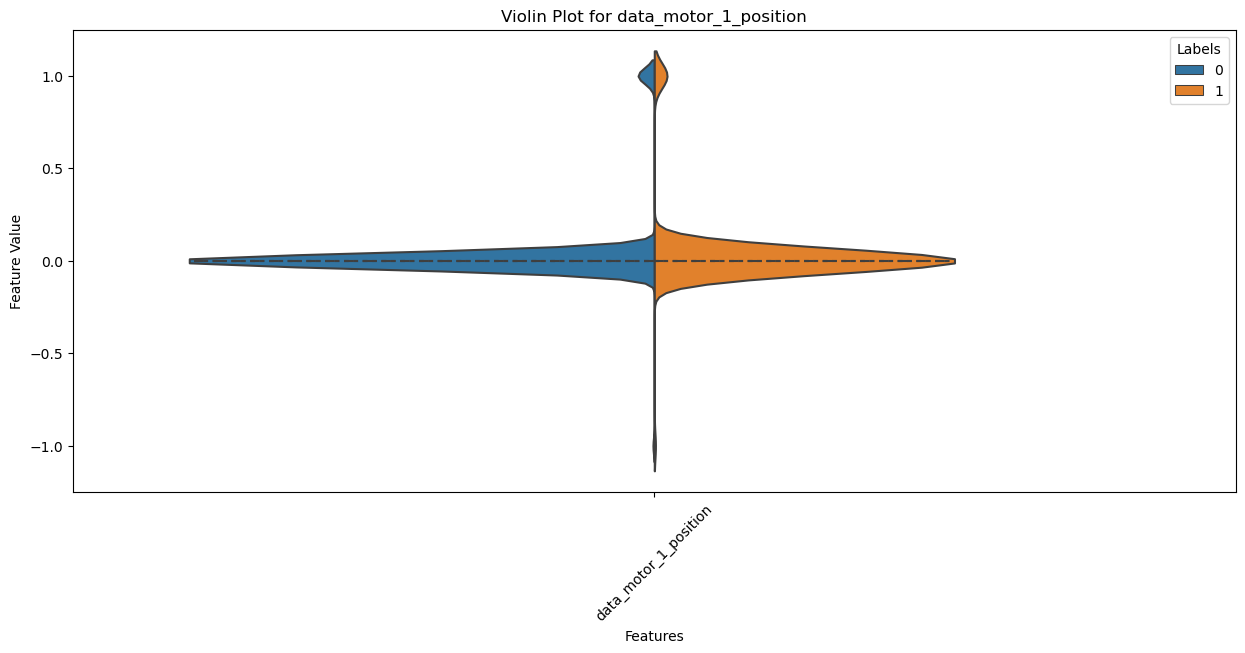

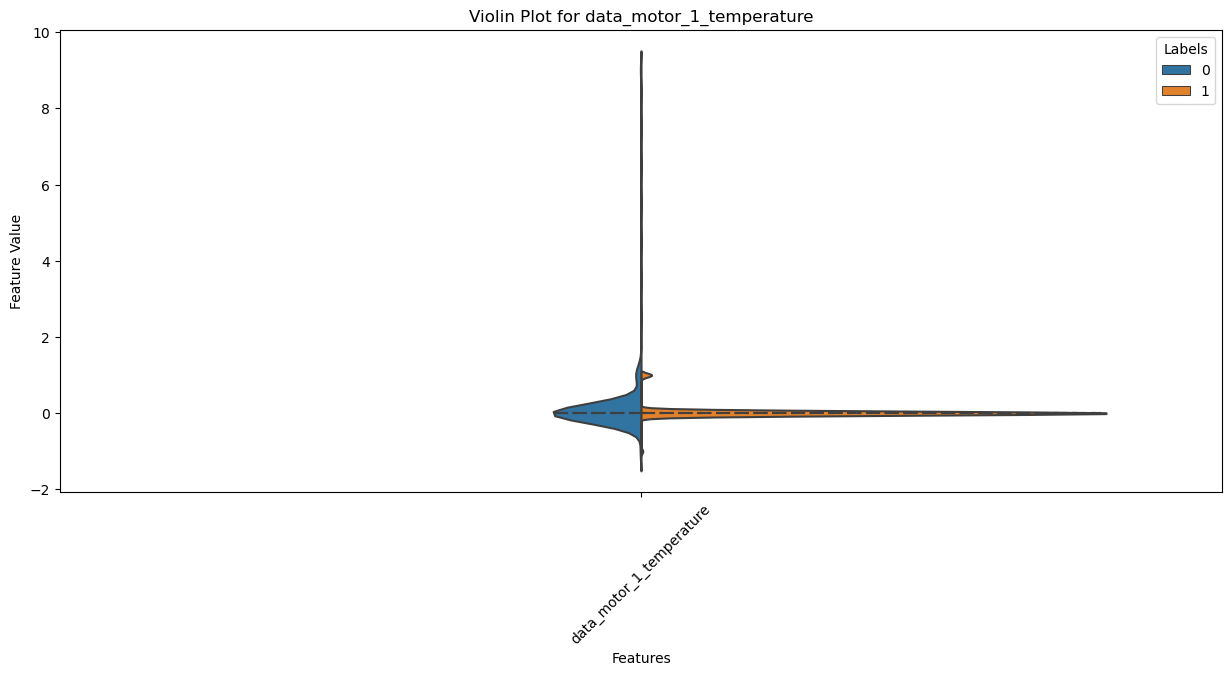

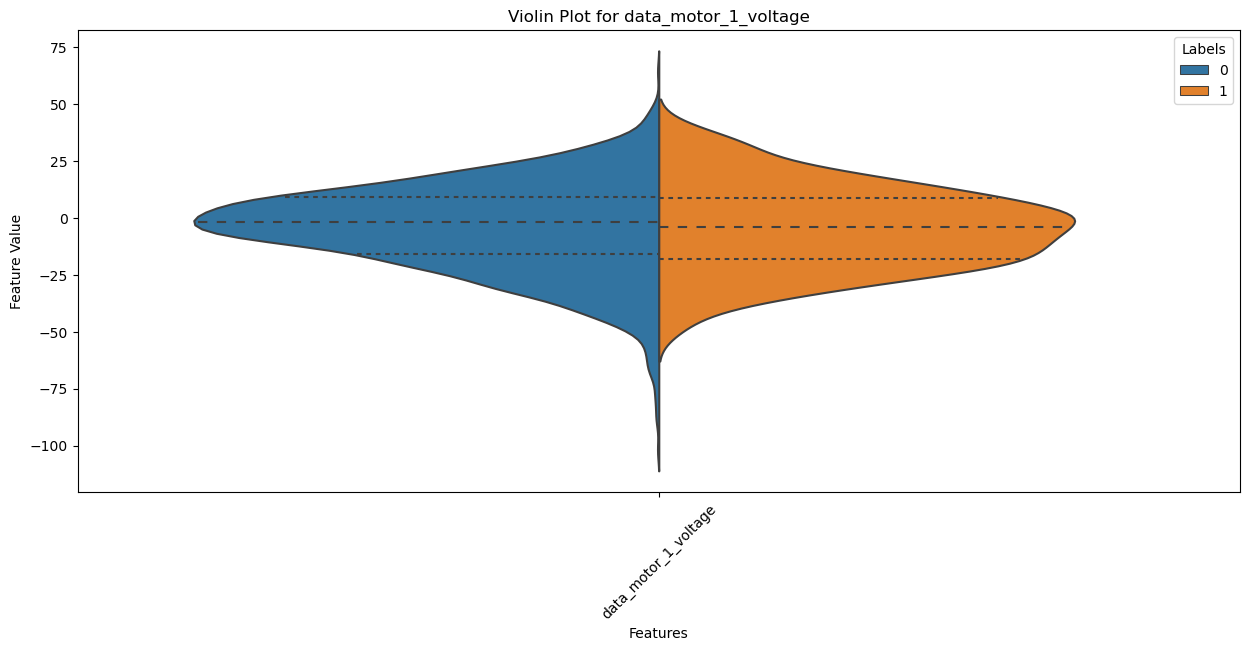

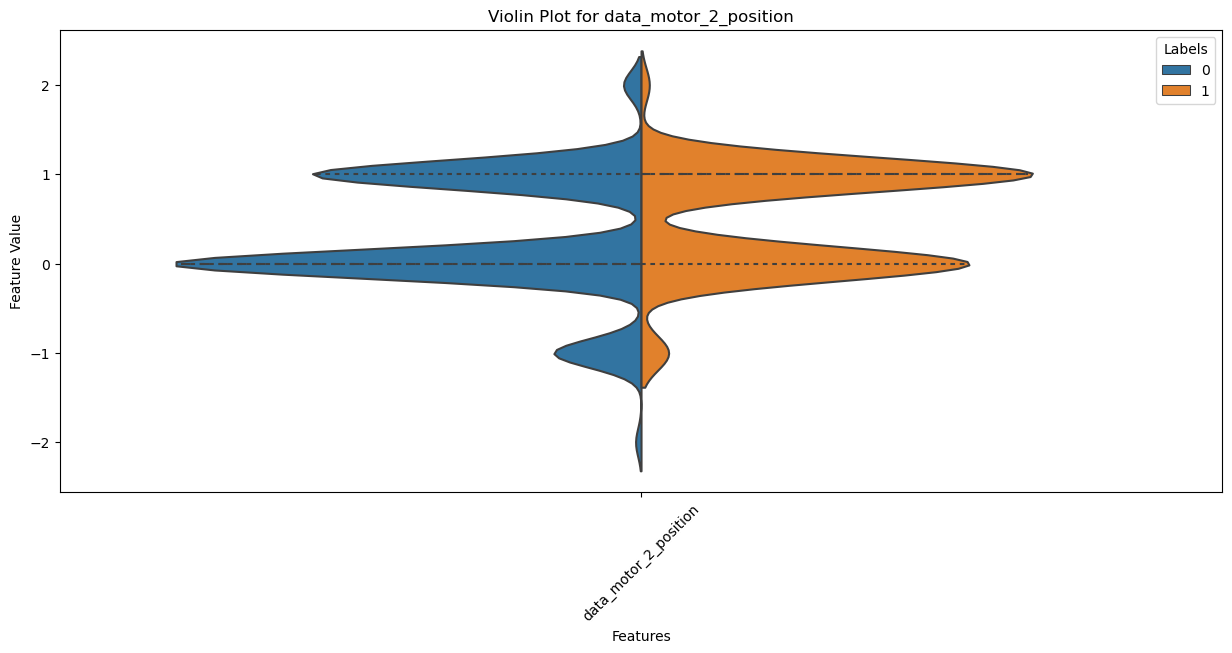

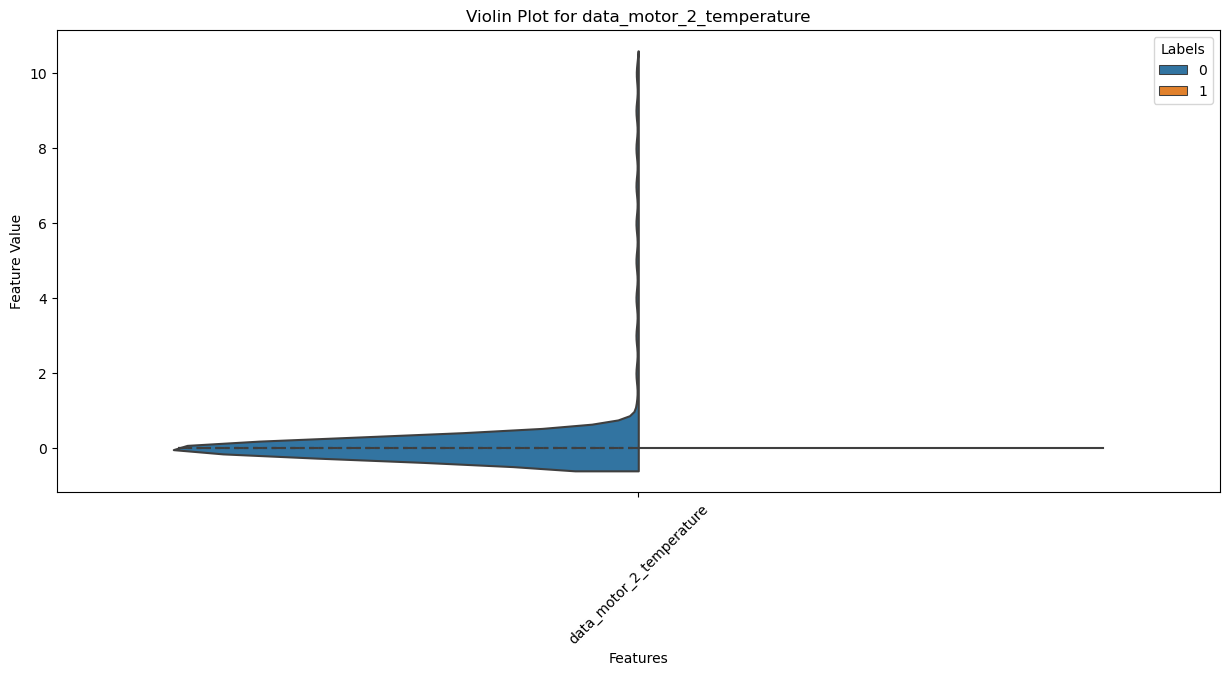

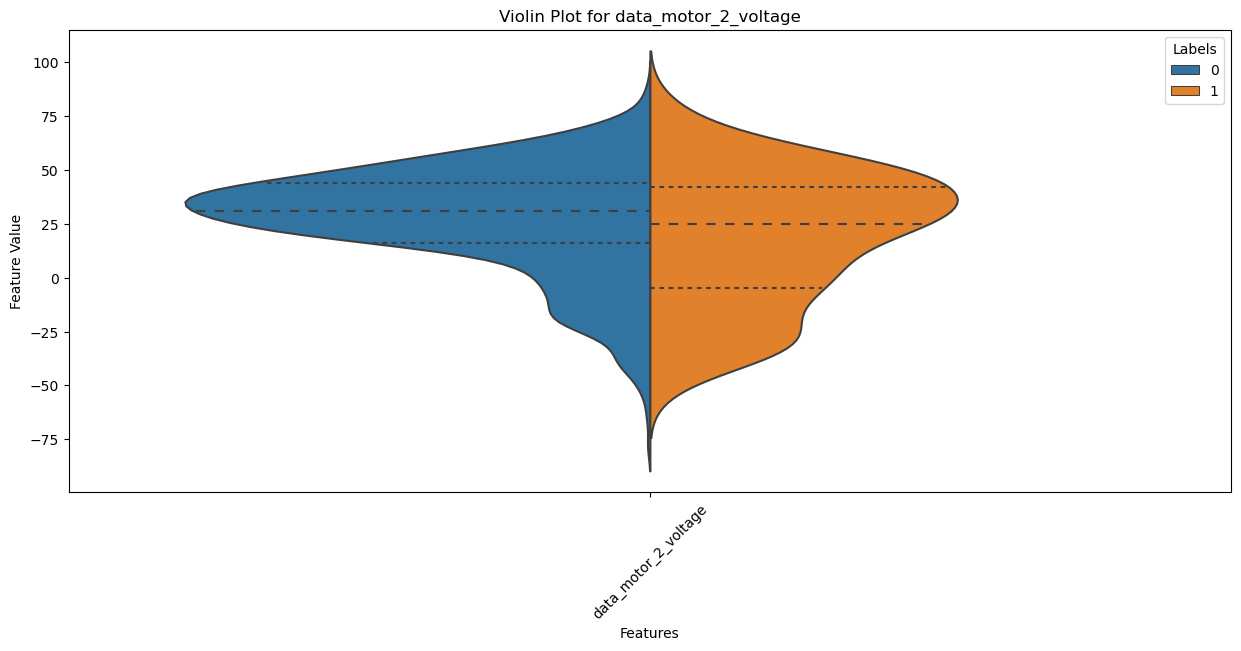

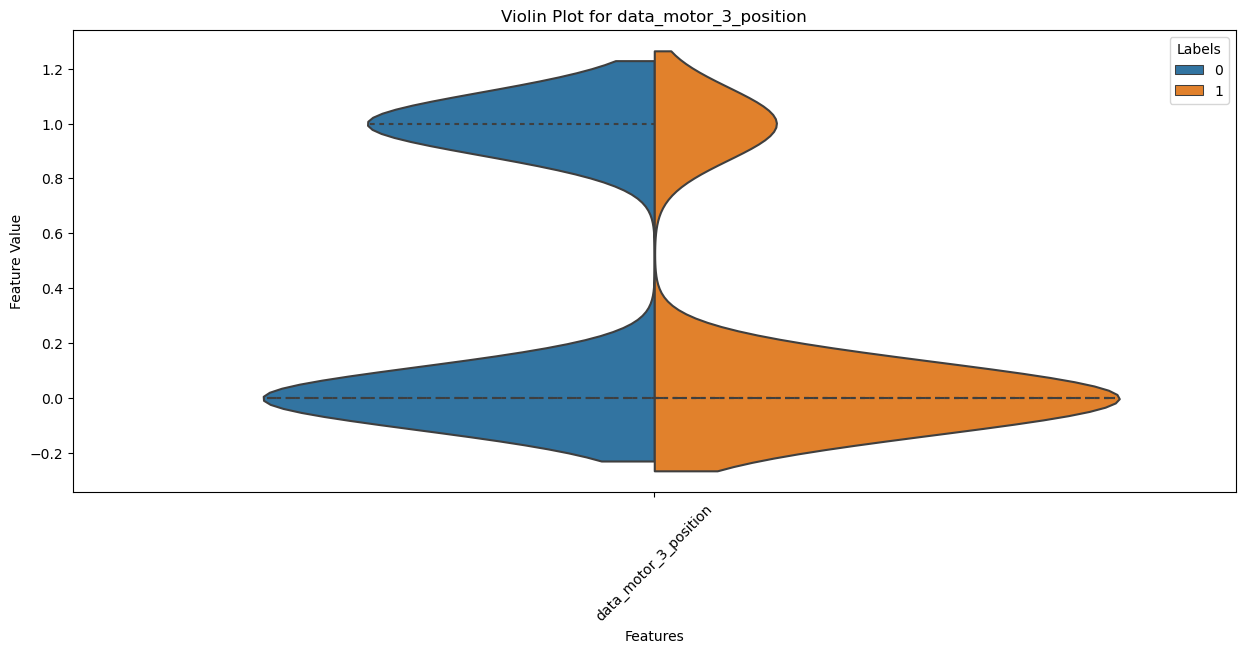

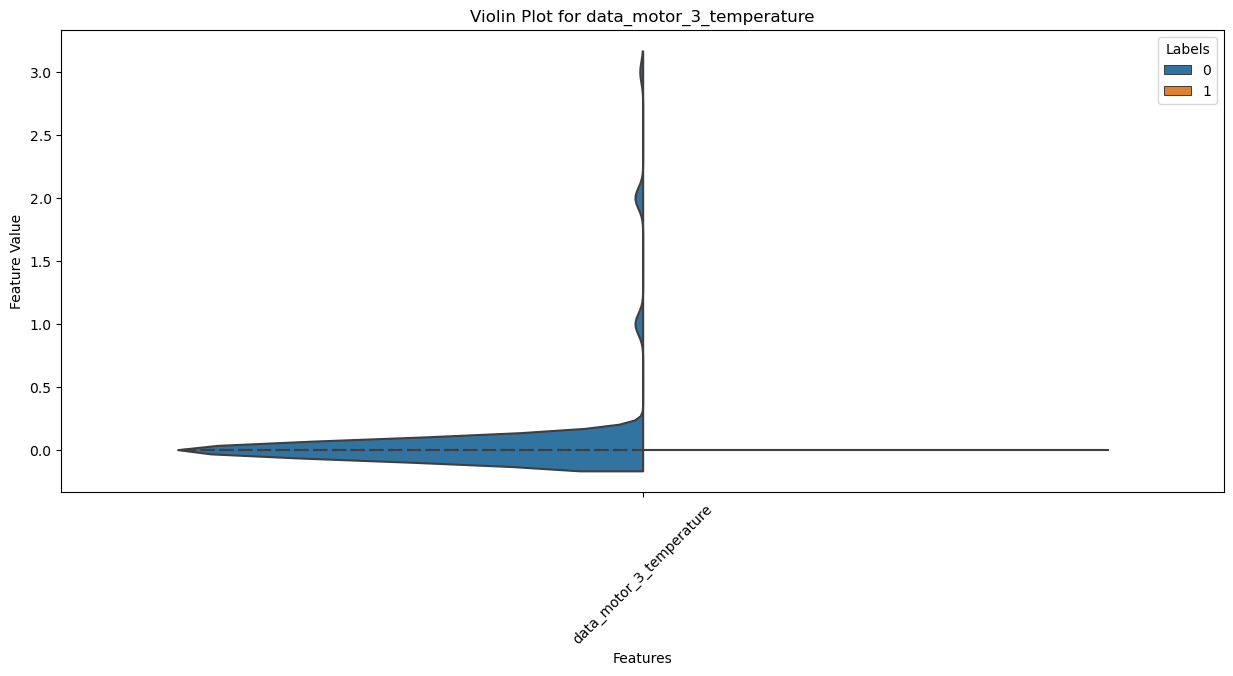

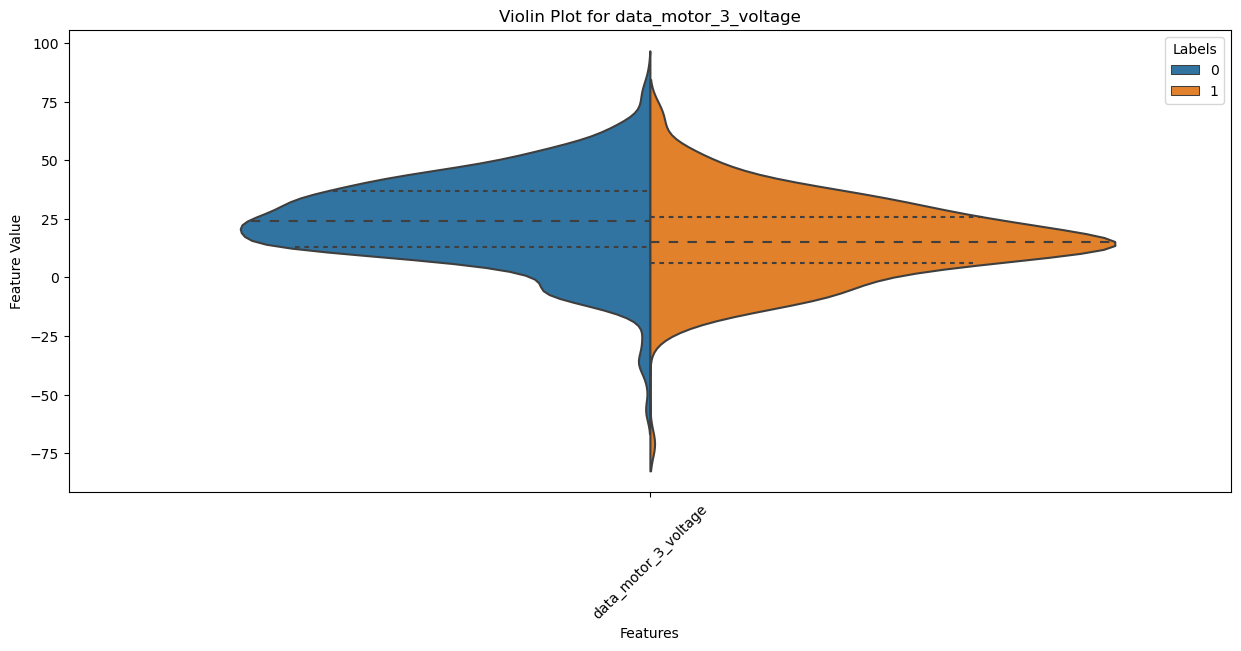

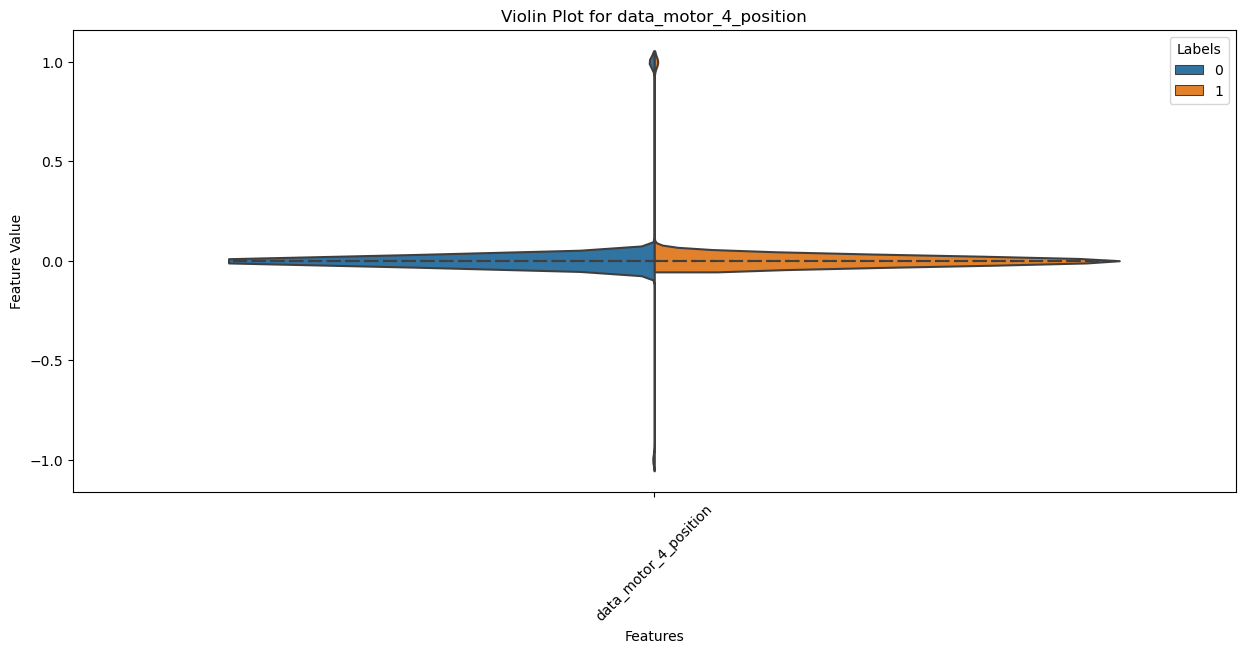

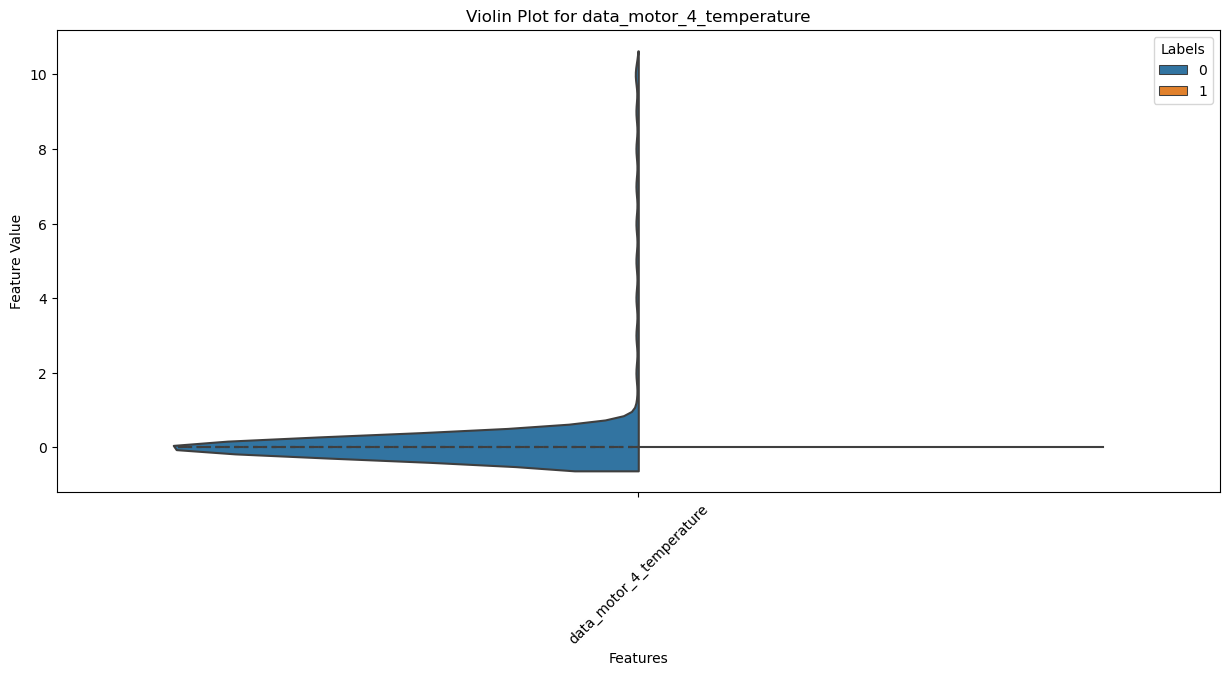

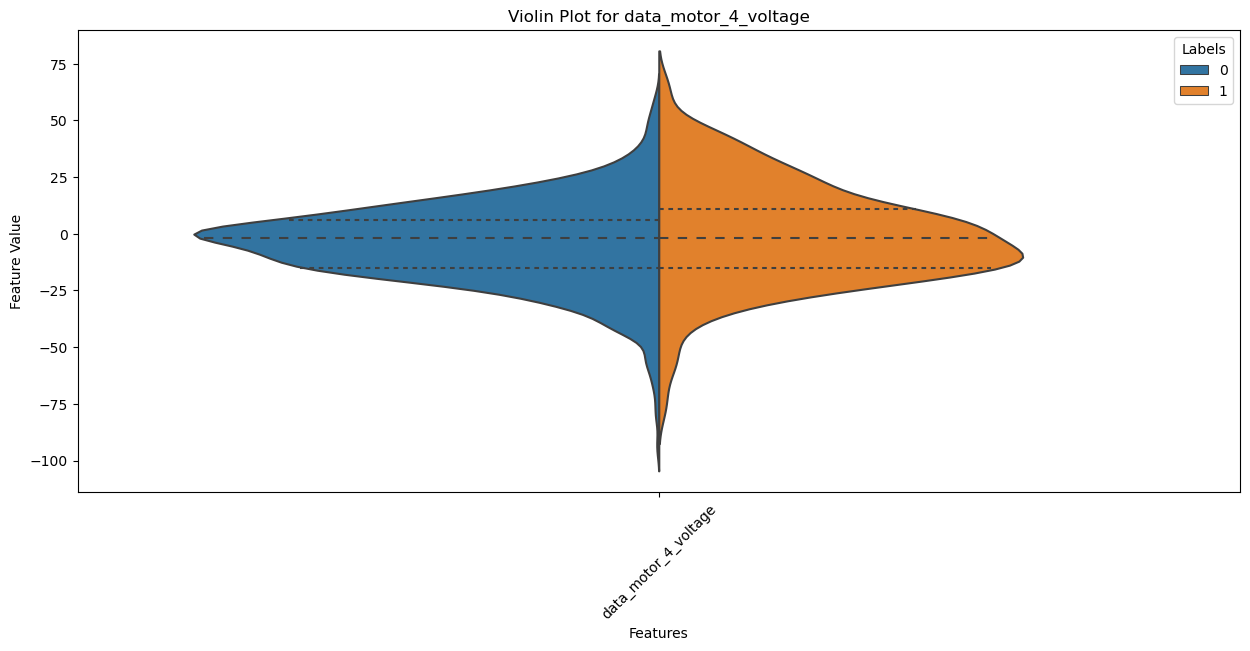

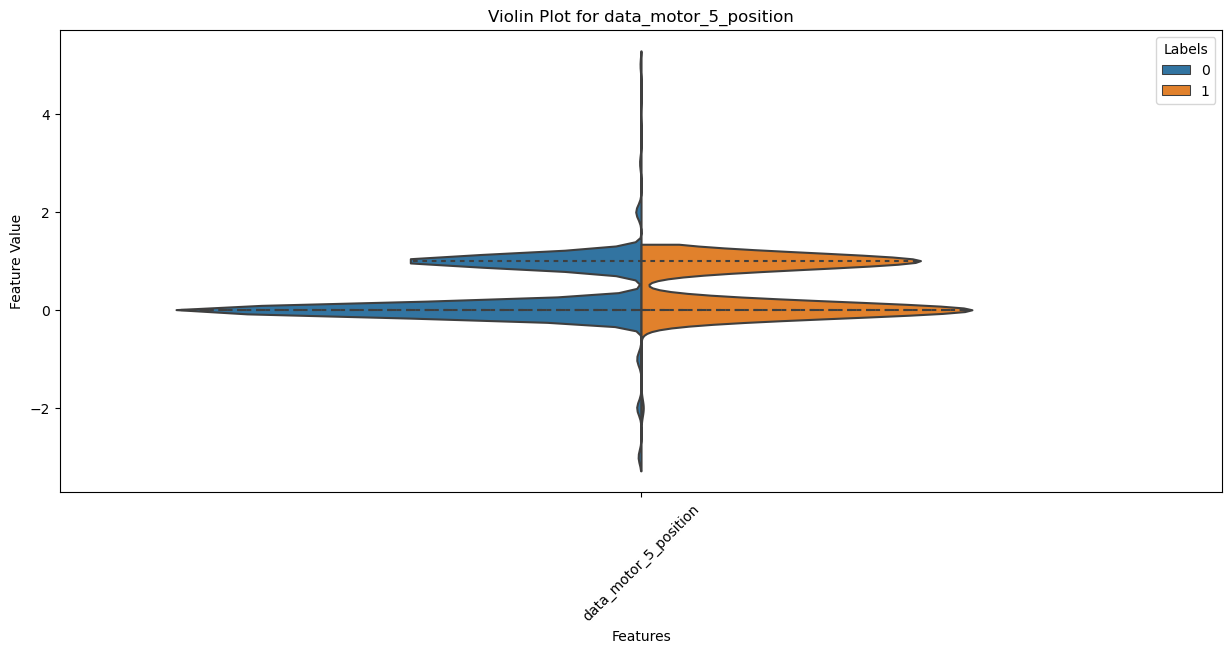

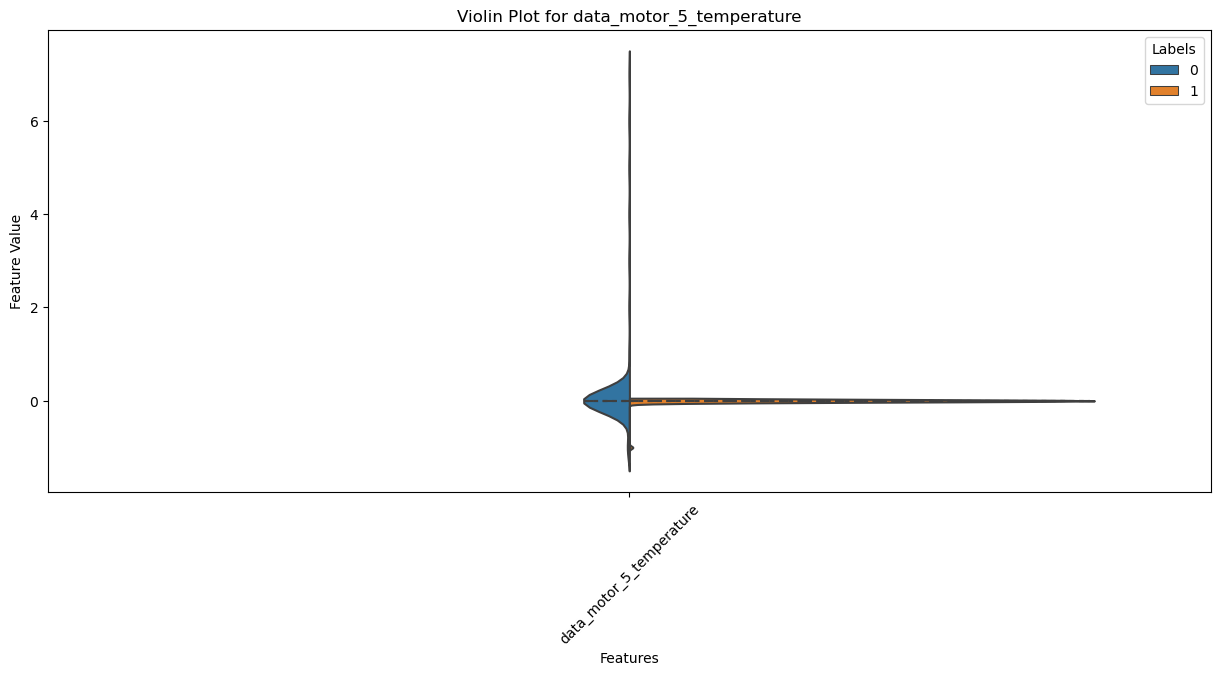

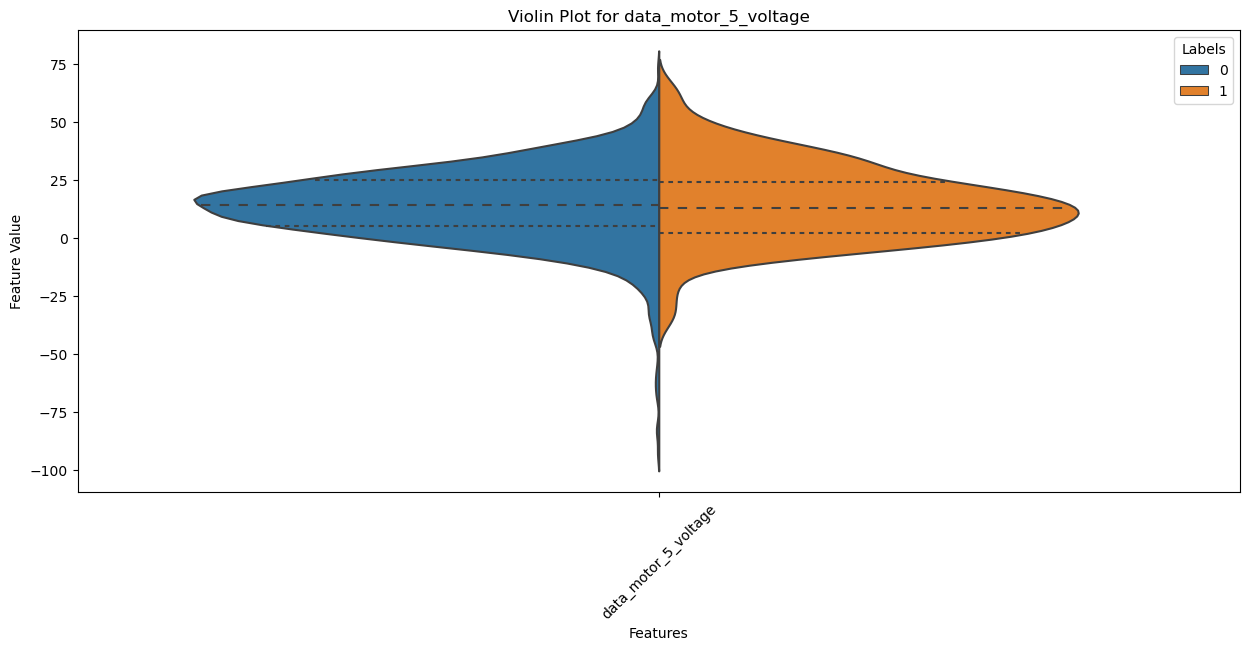

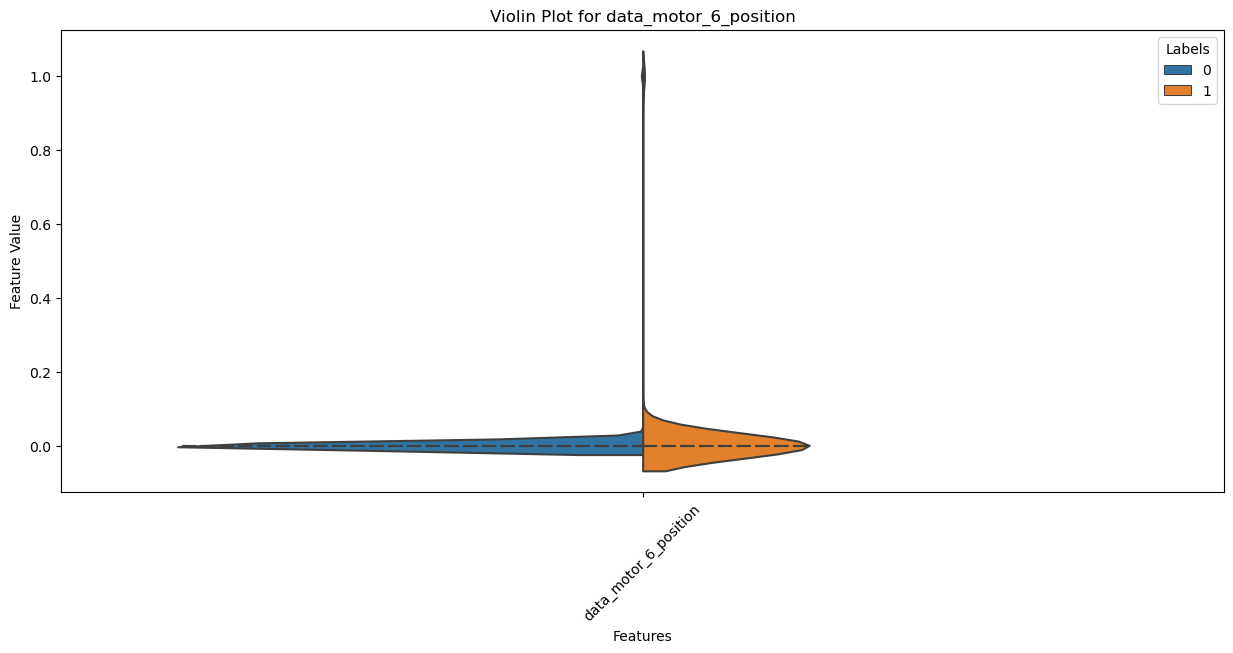

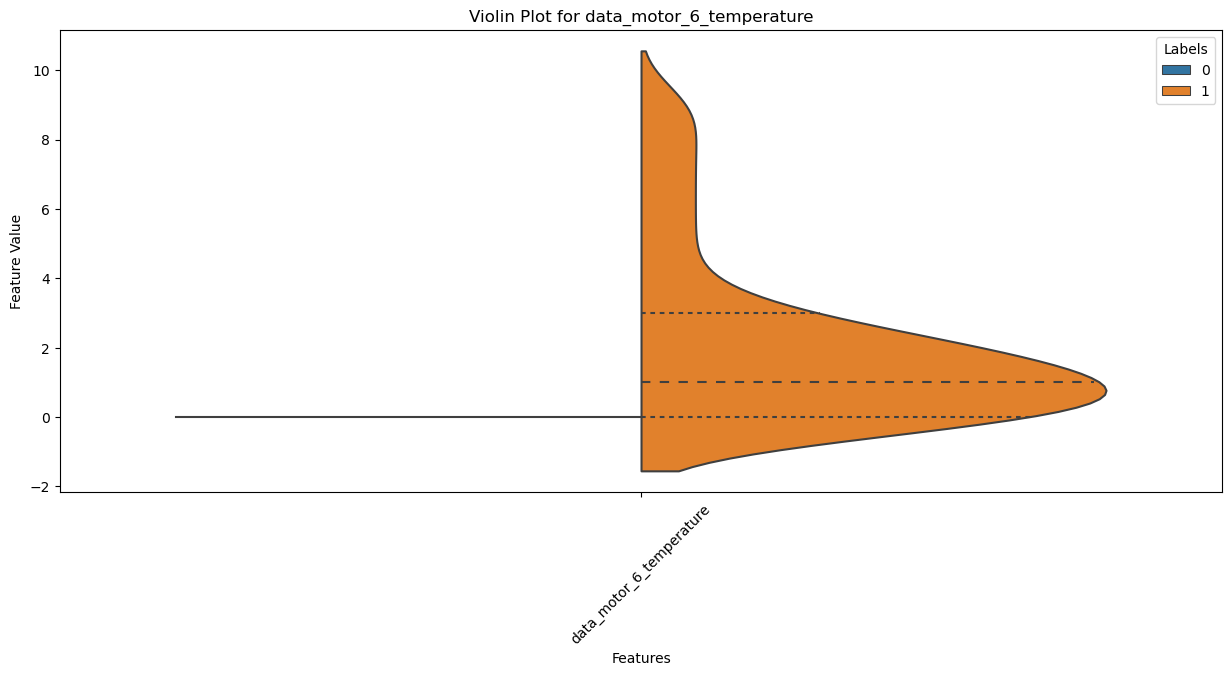

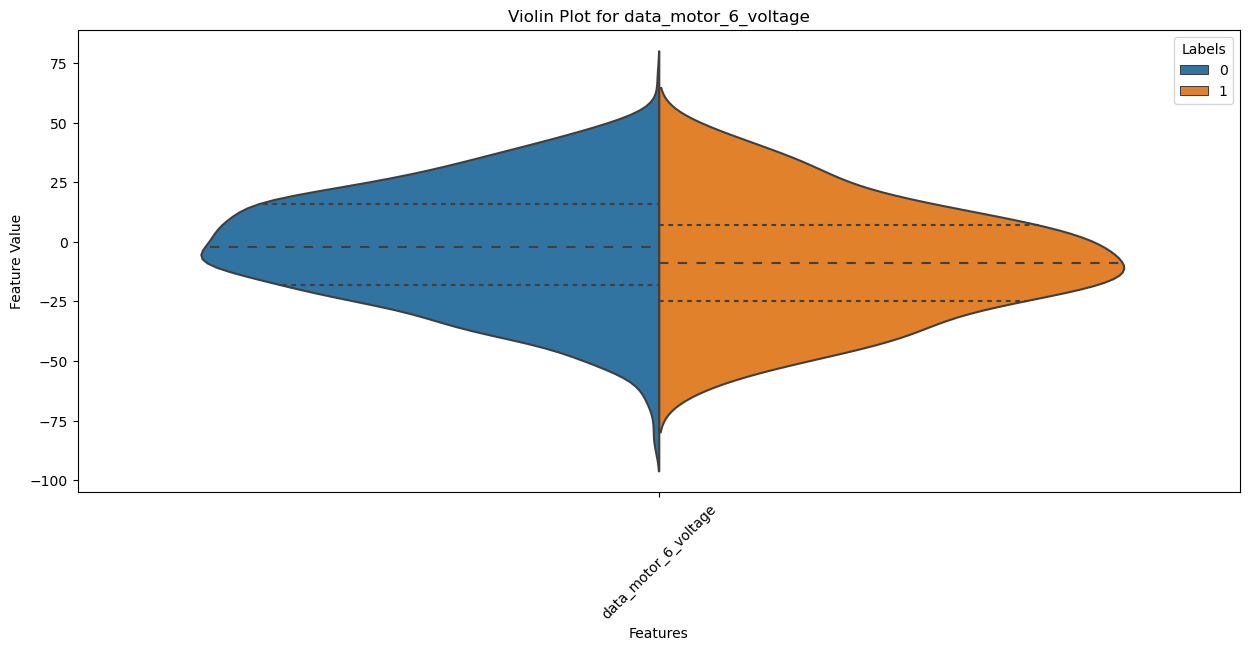


Move: 


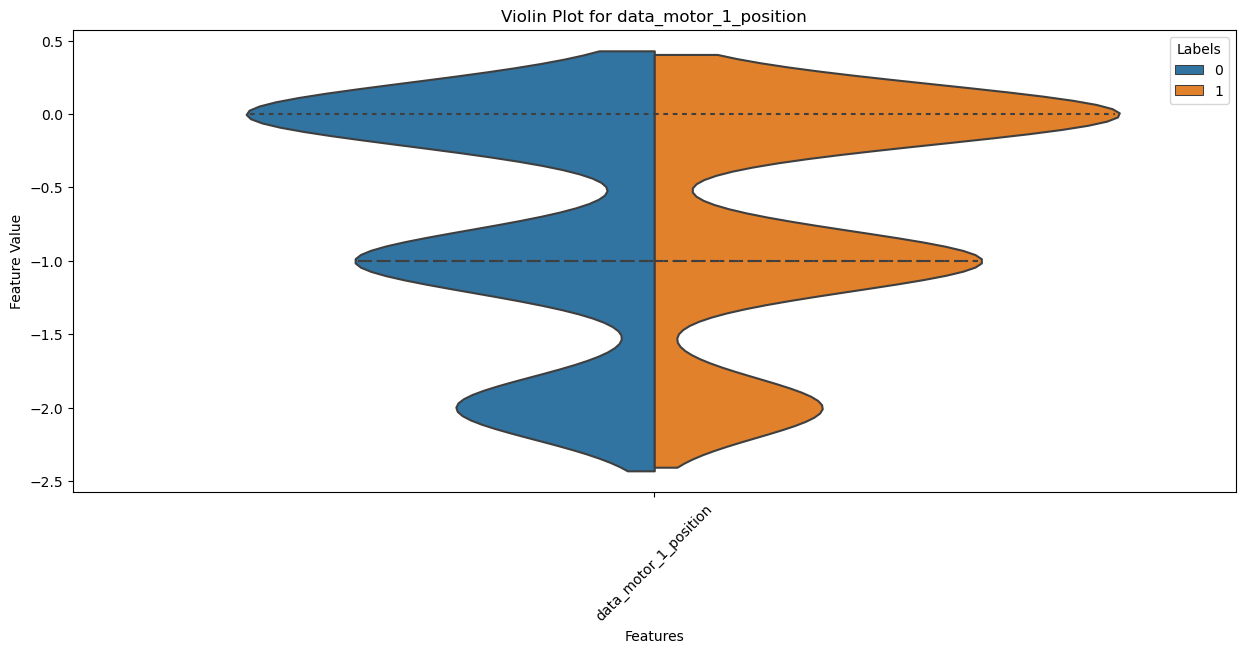

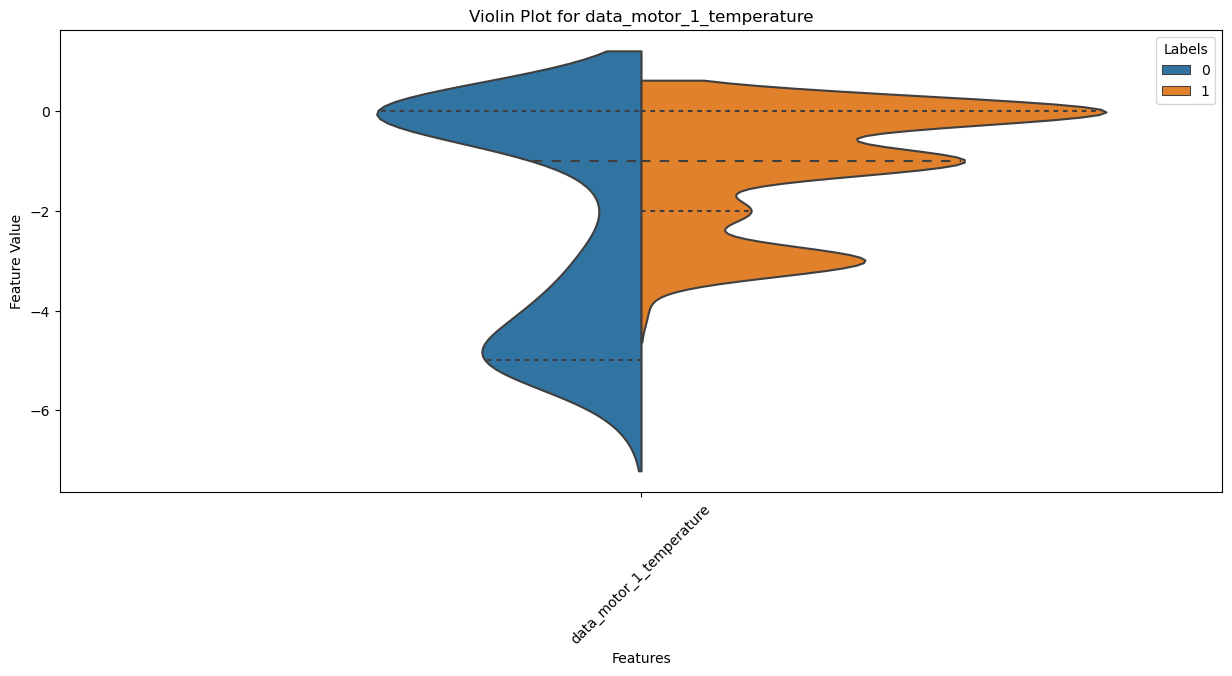

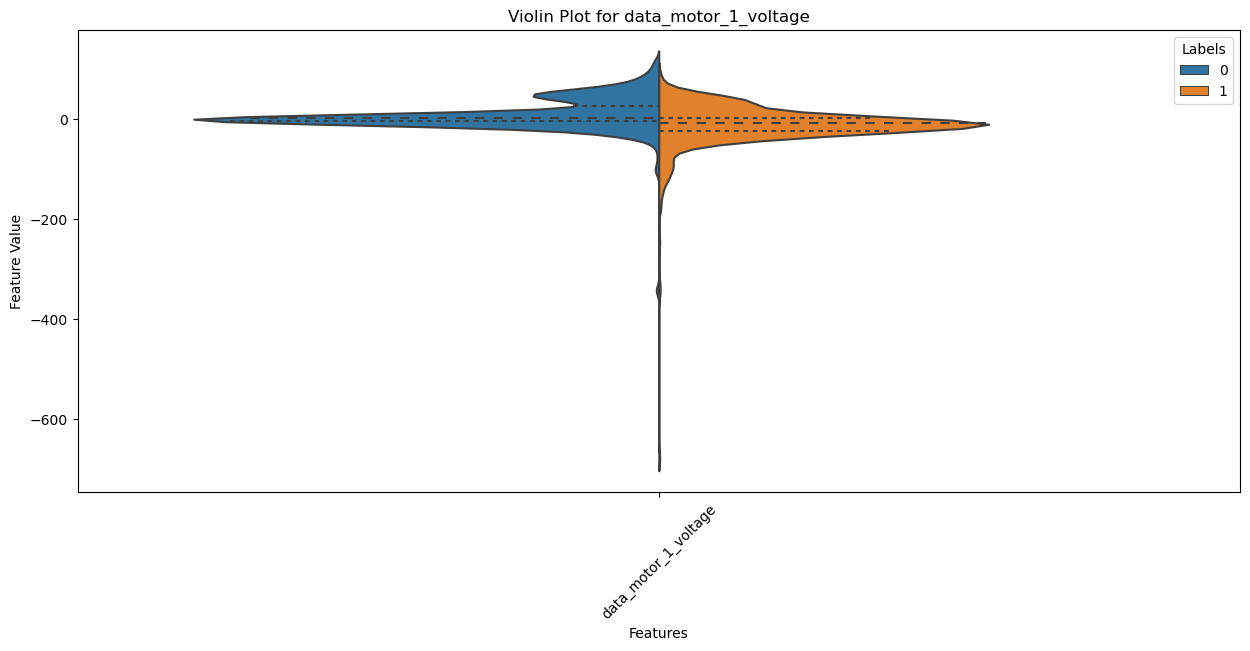

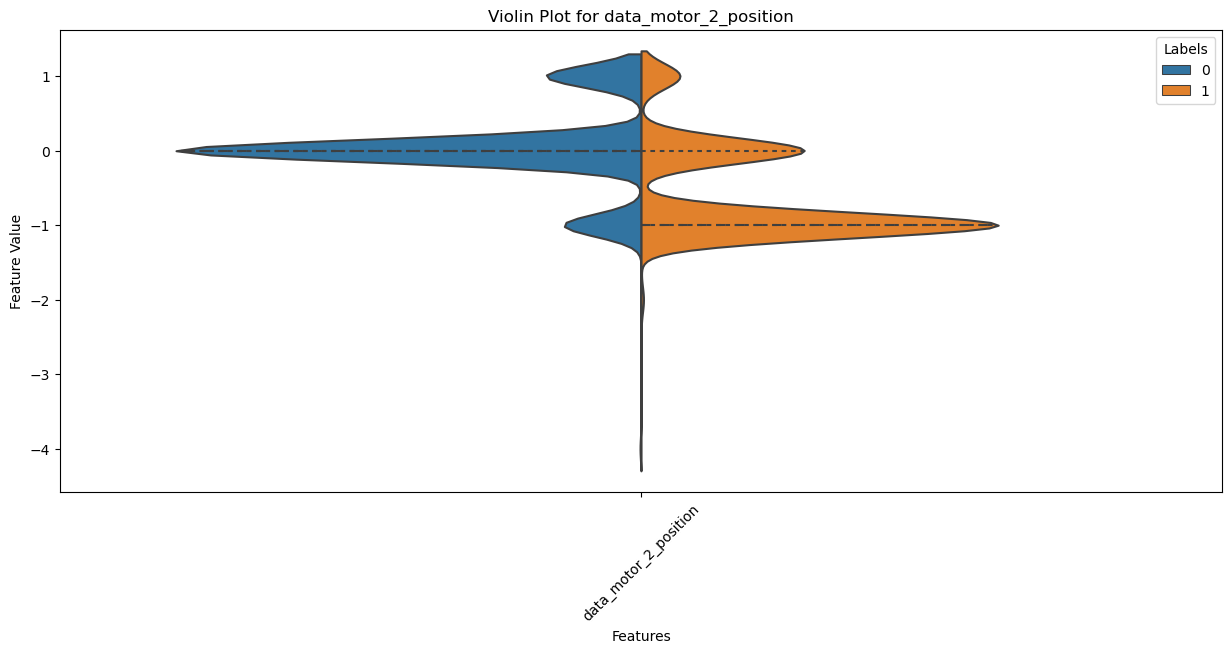

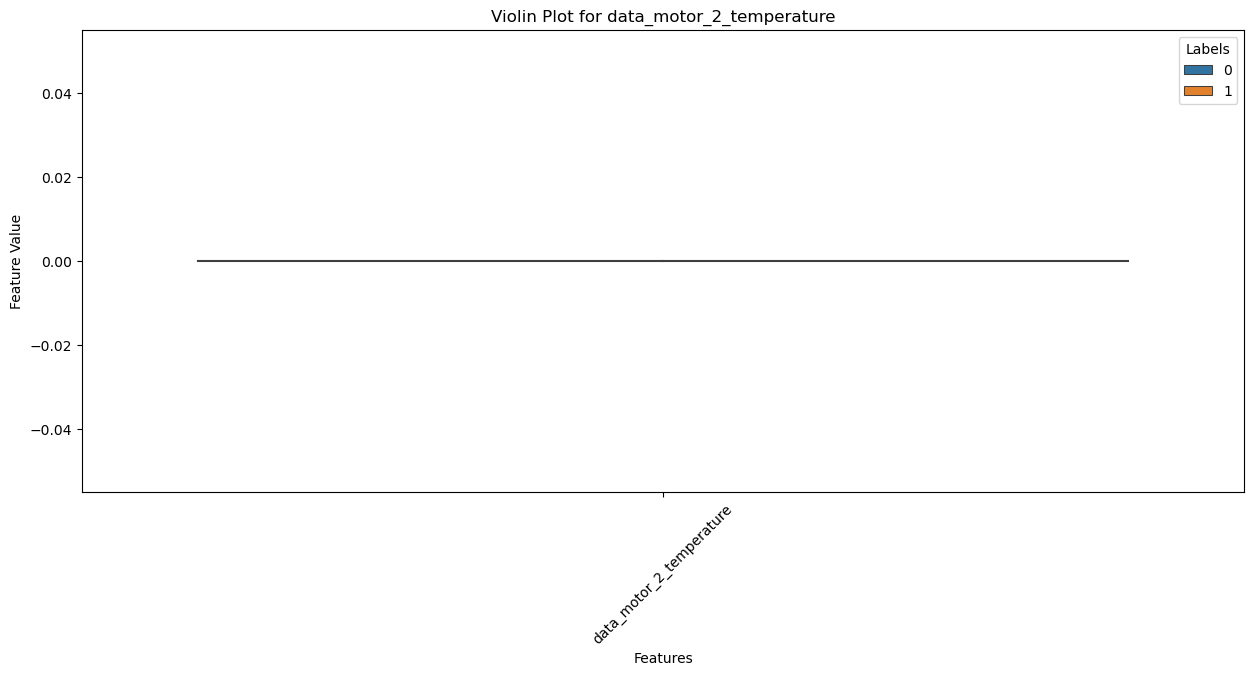

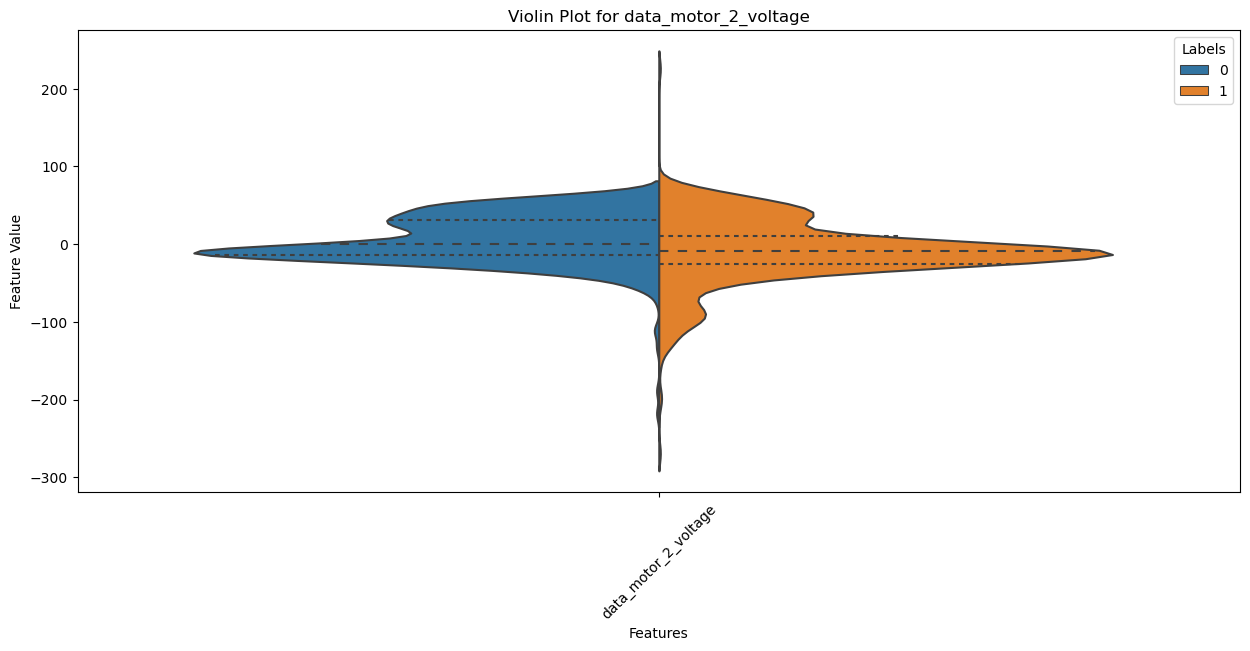

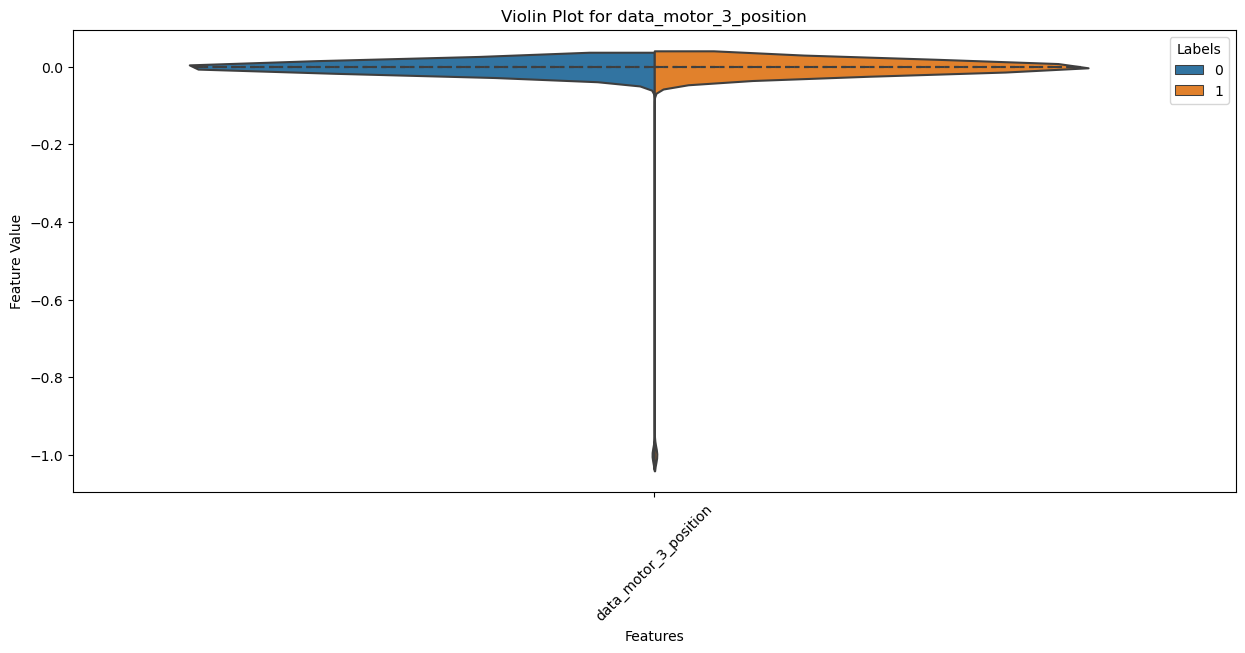

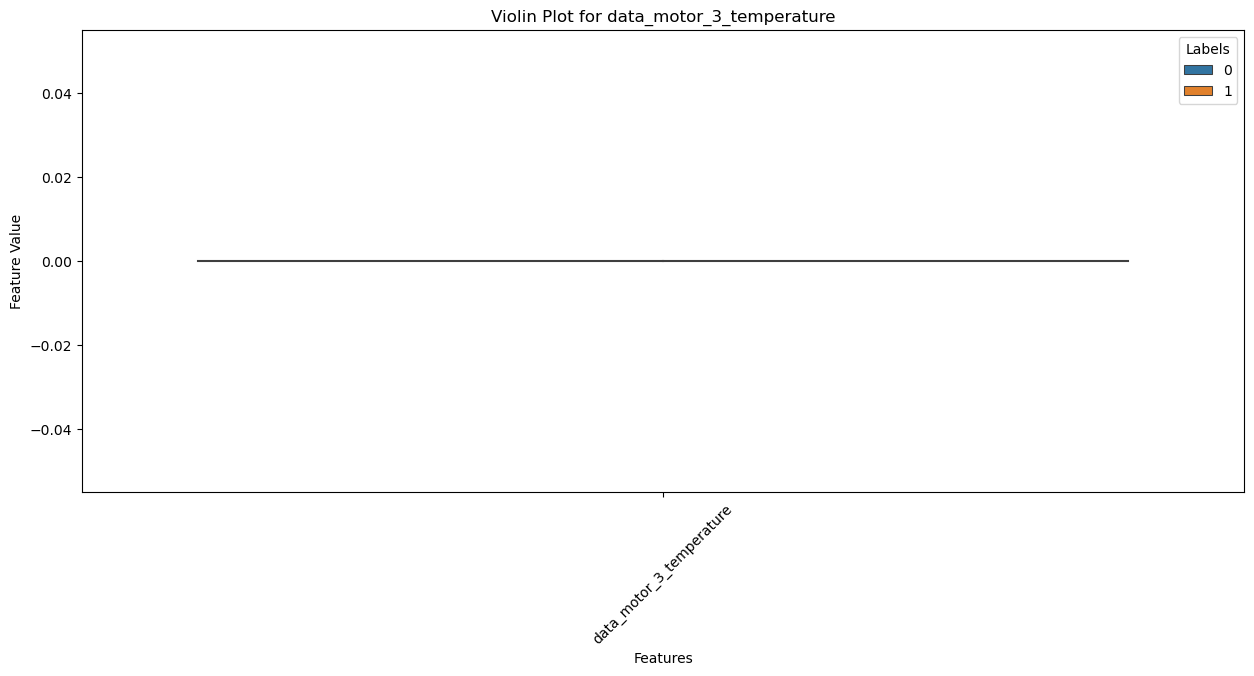

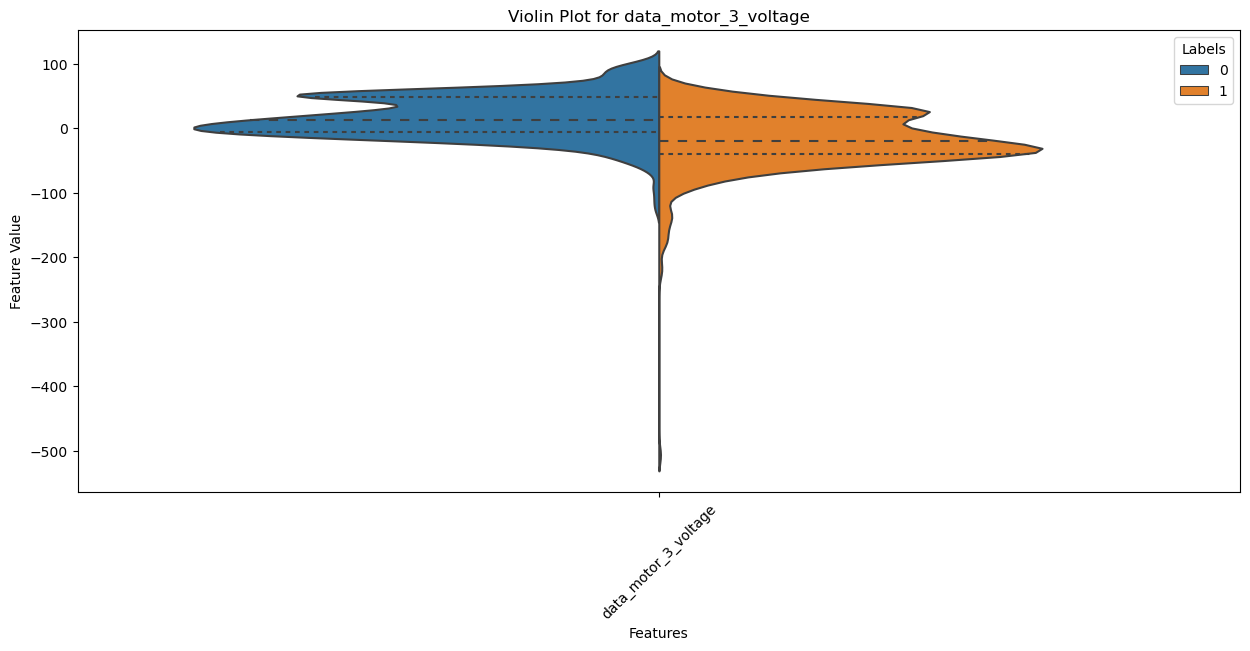

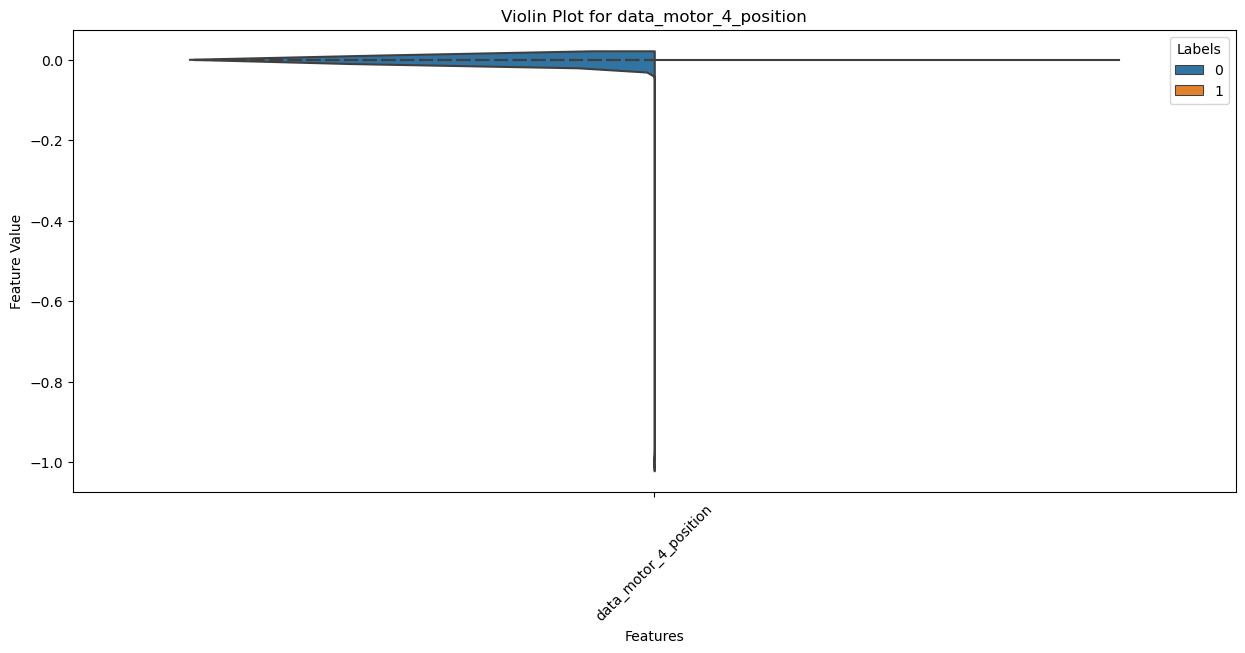

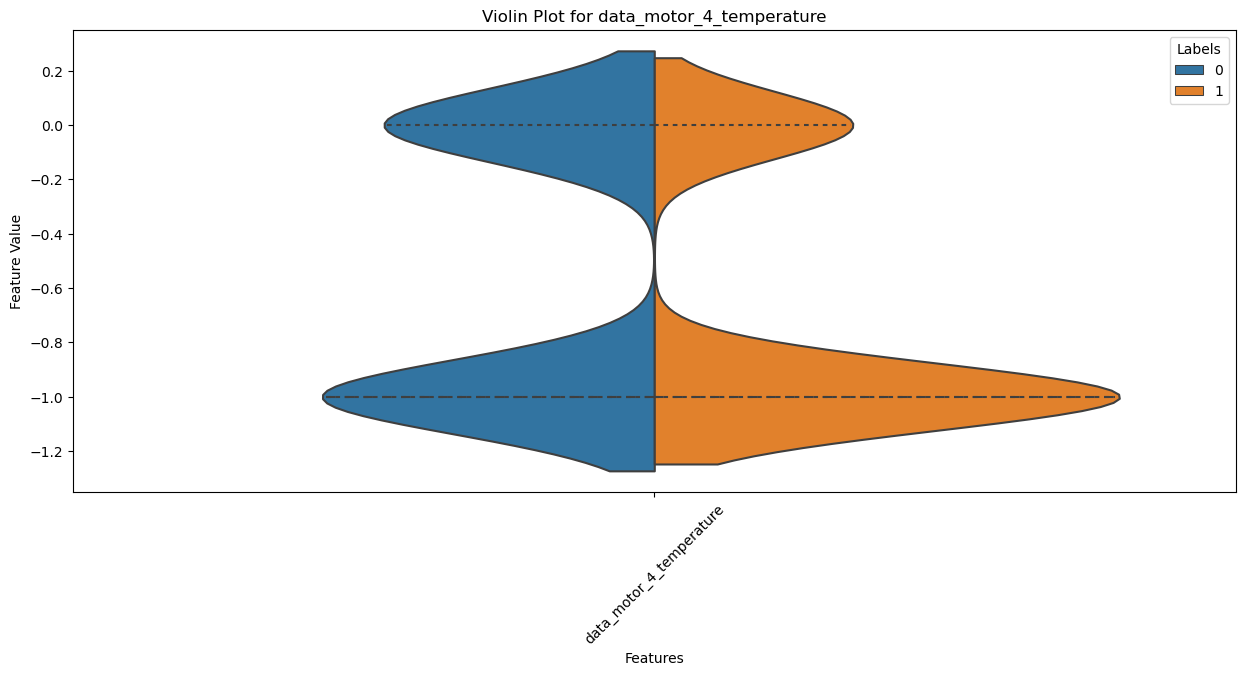

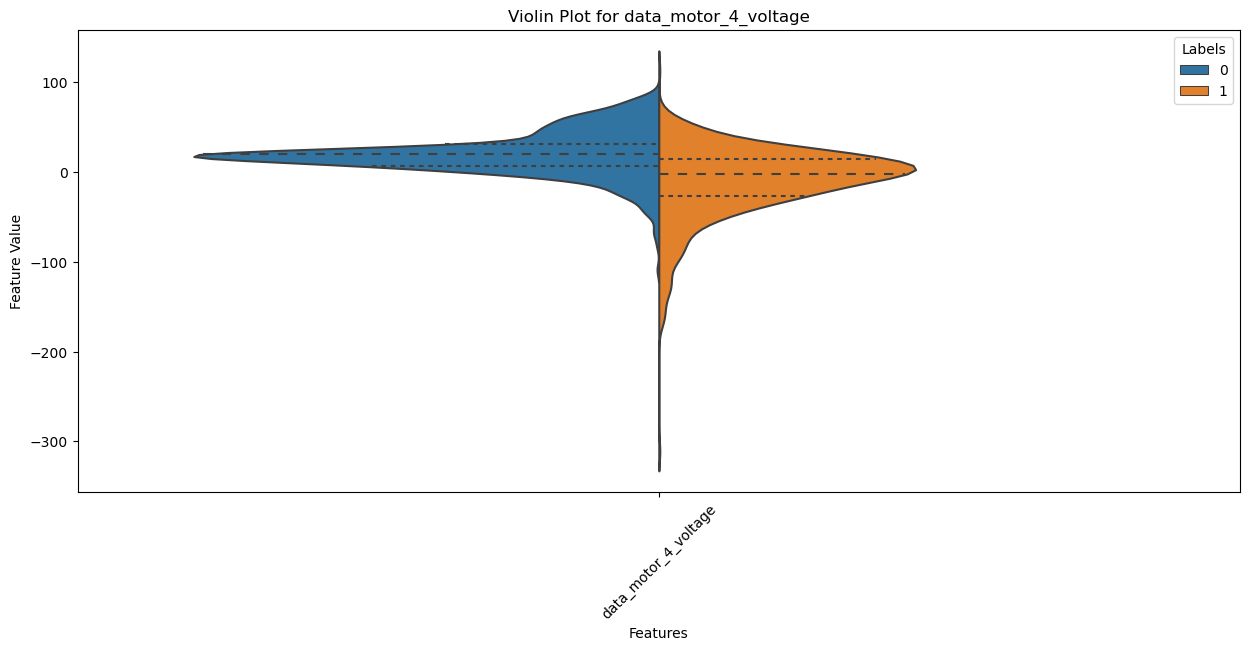

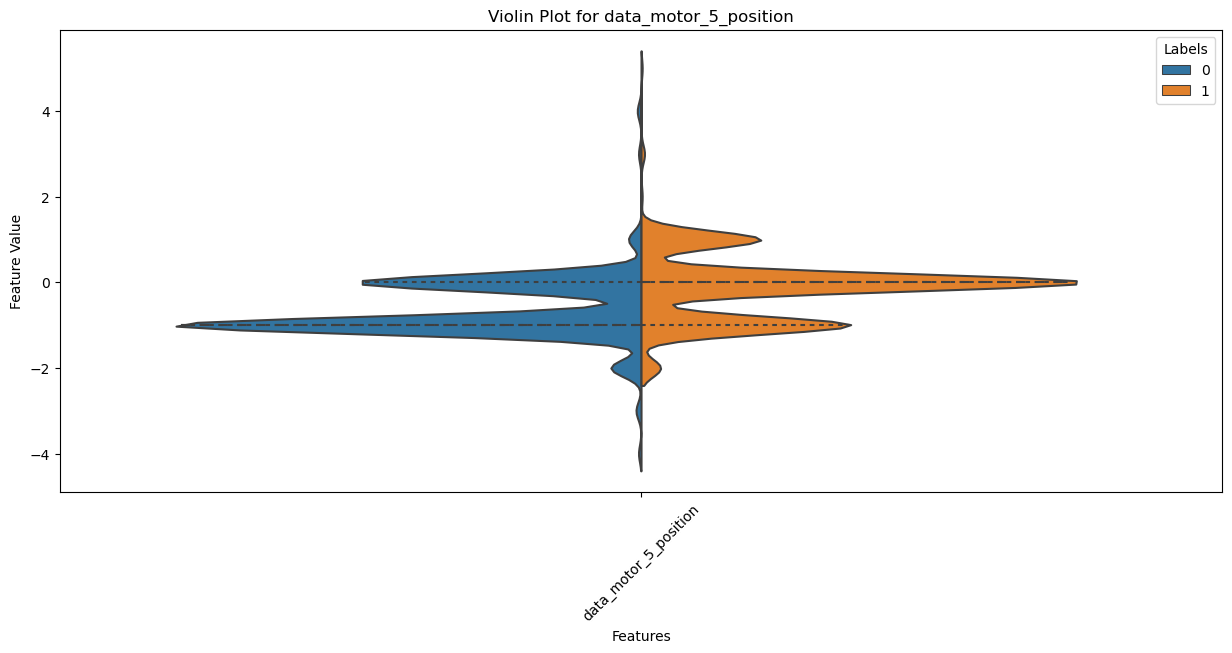

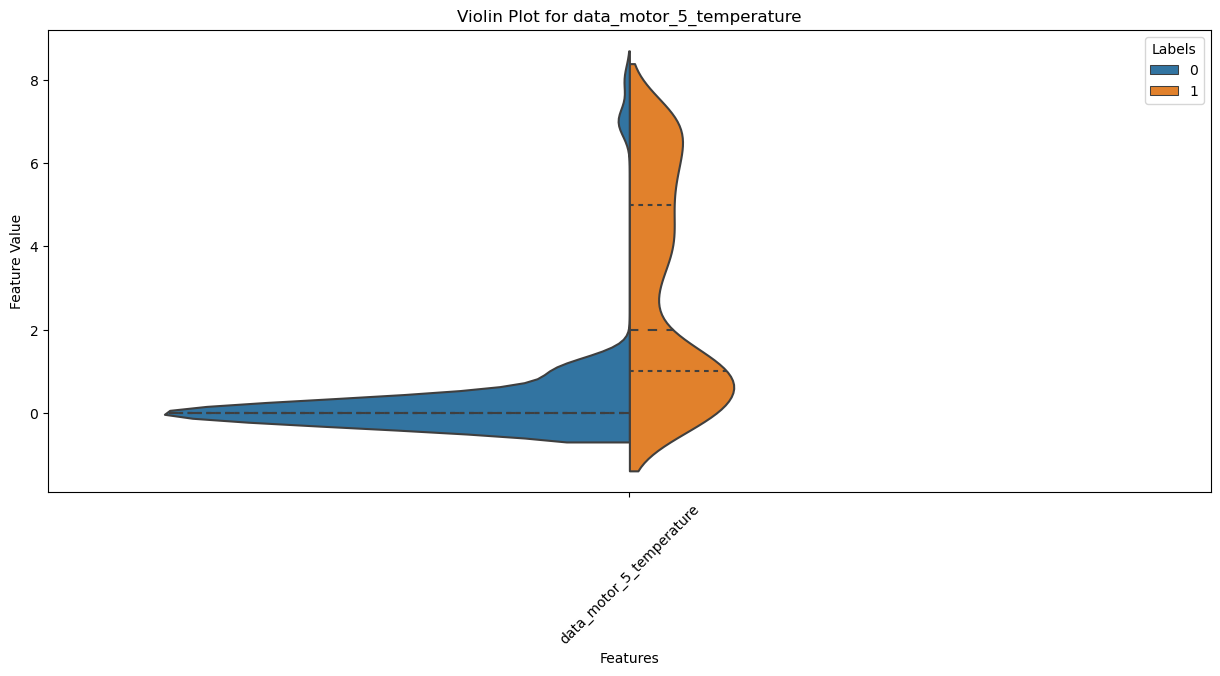

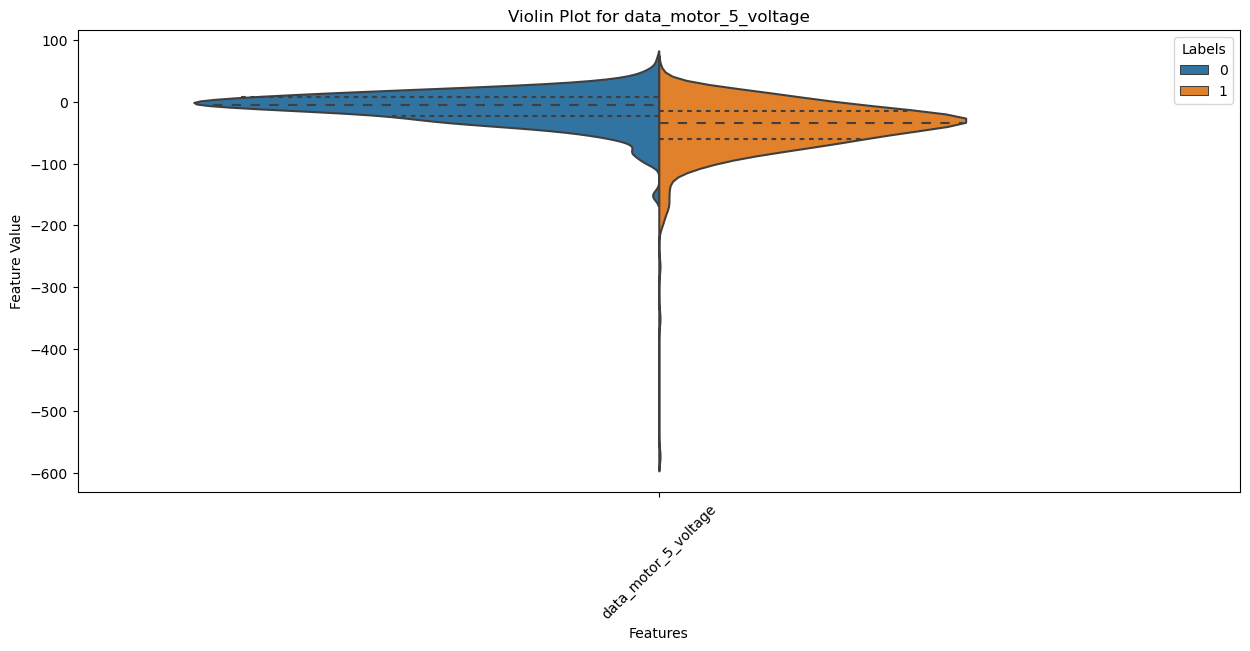

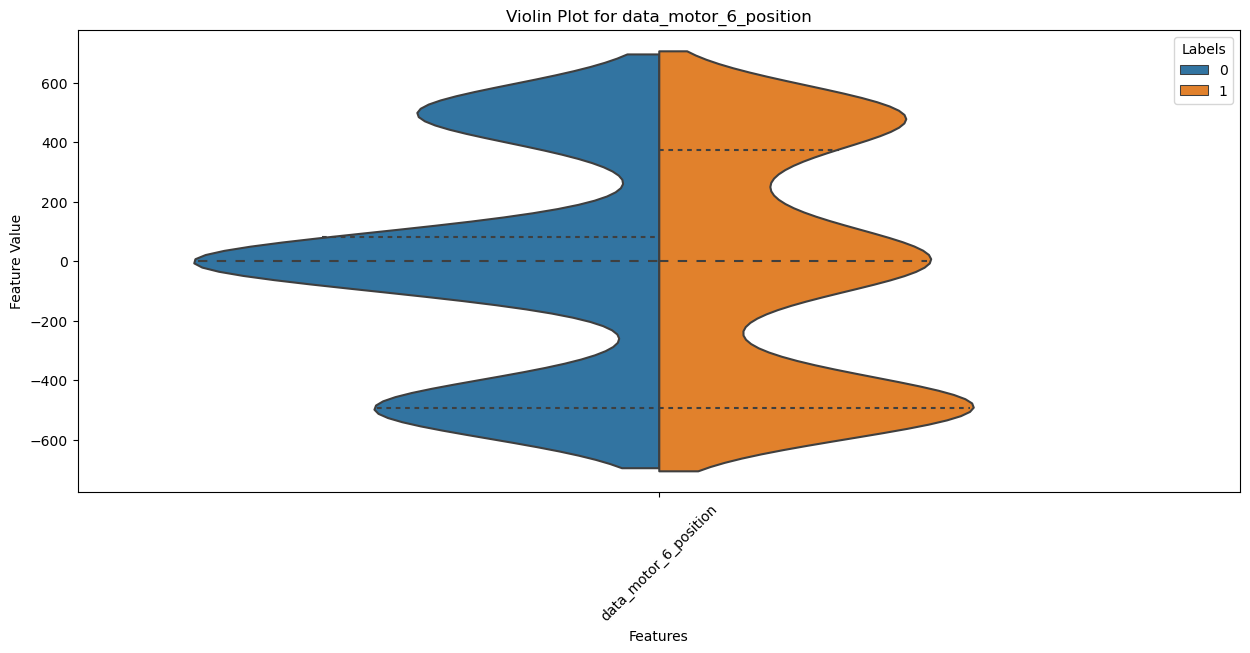

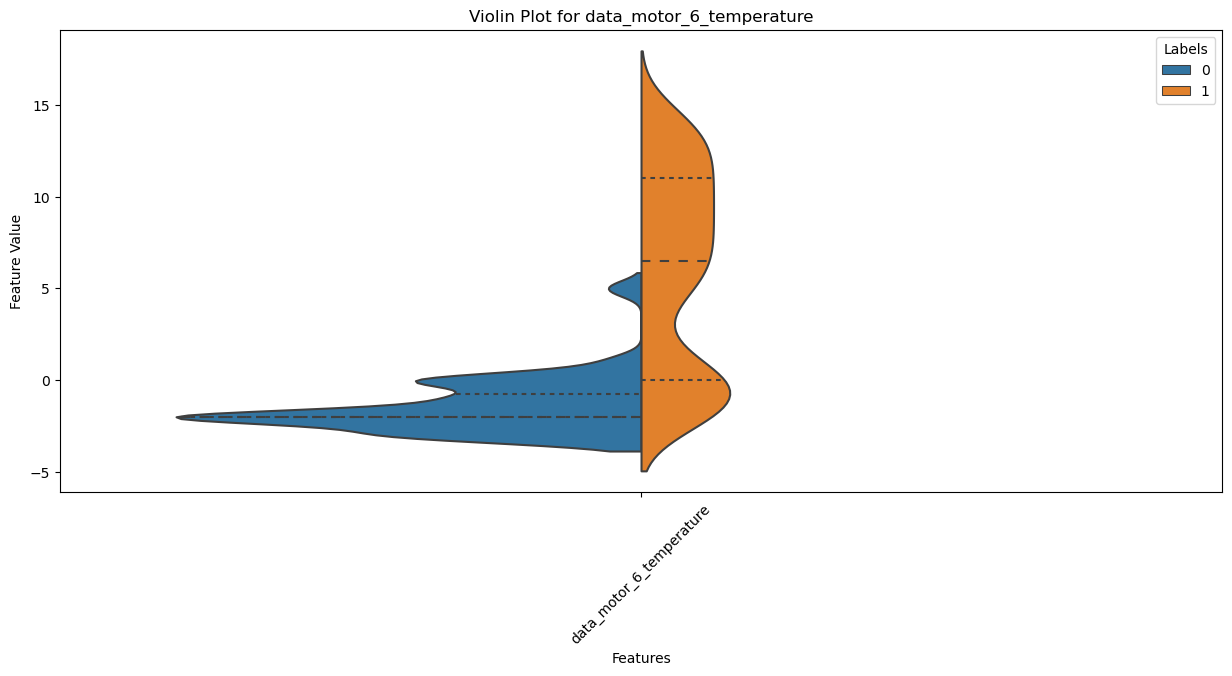

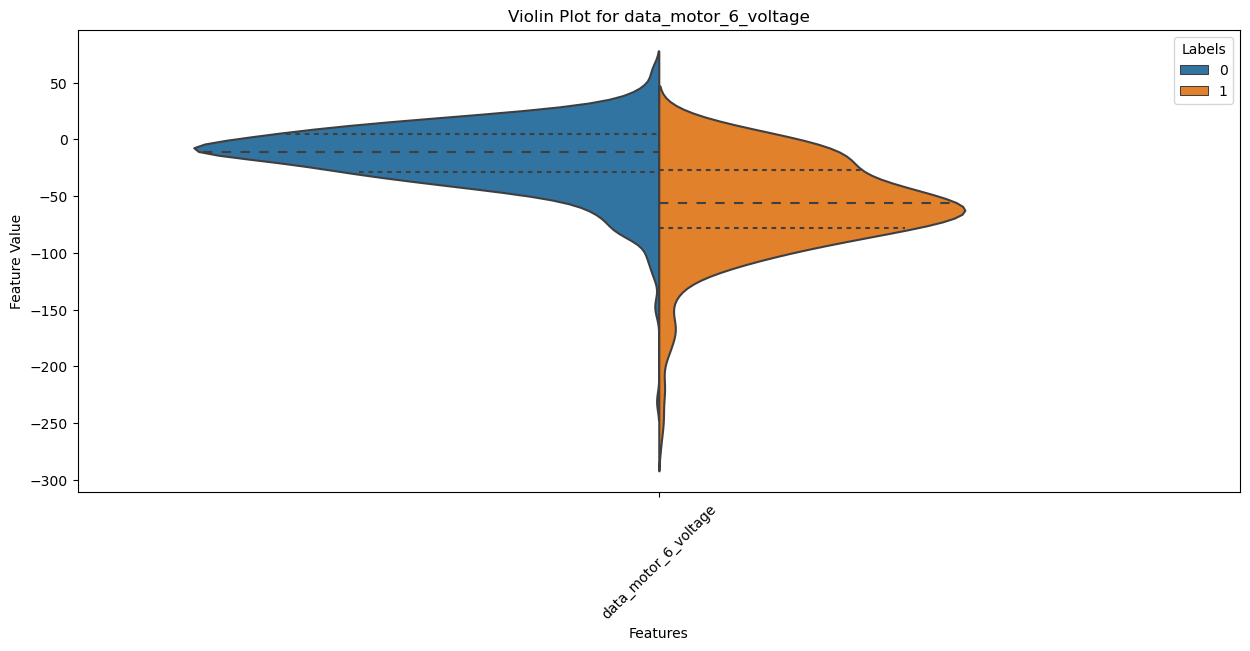


PickUpAndPlace: 


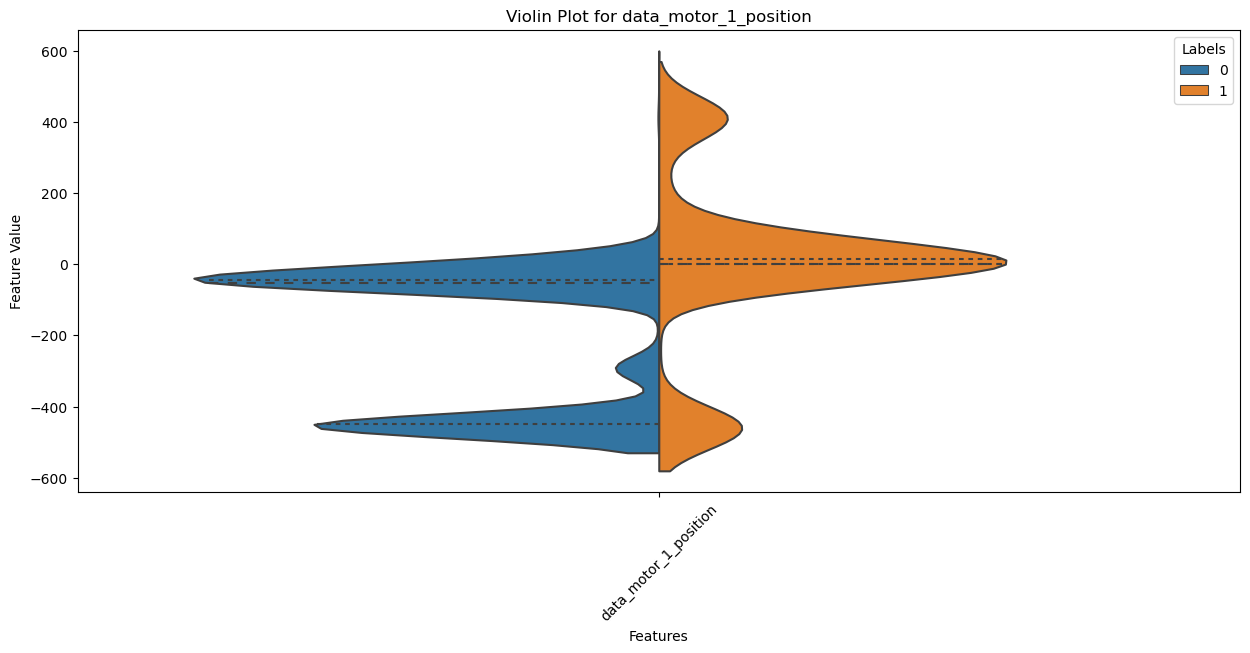

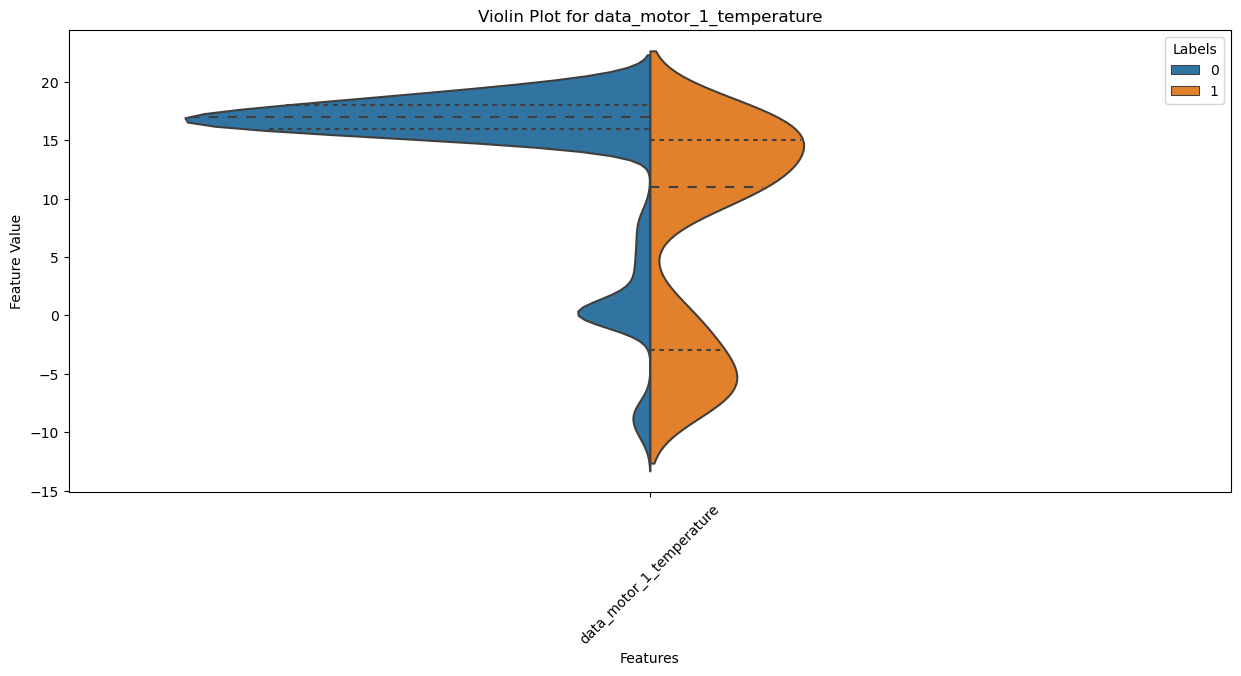

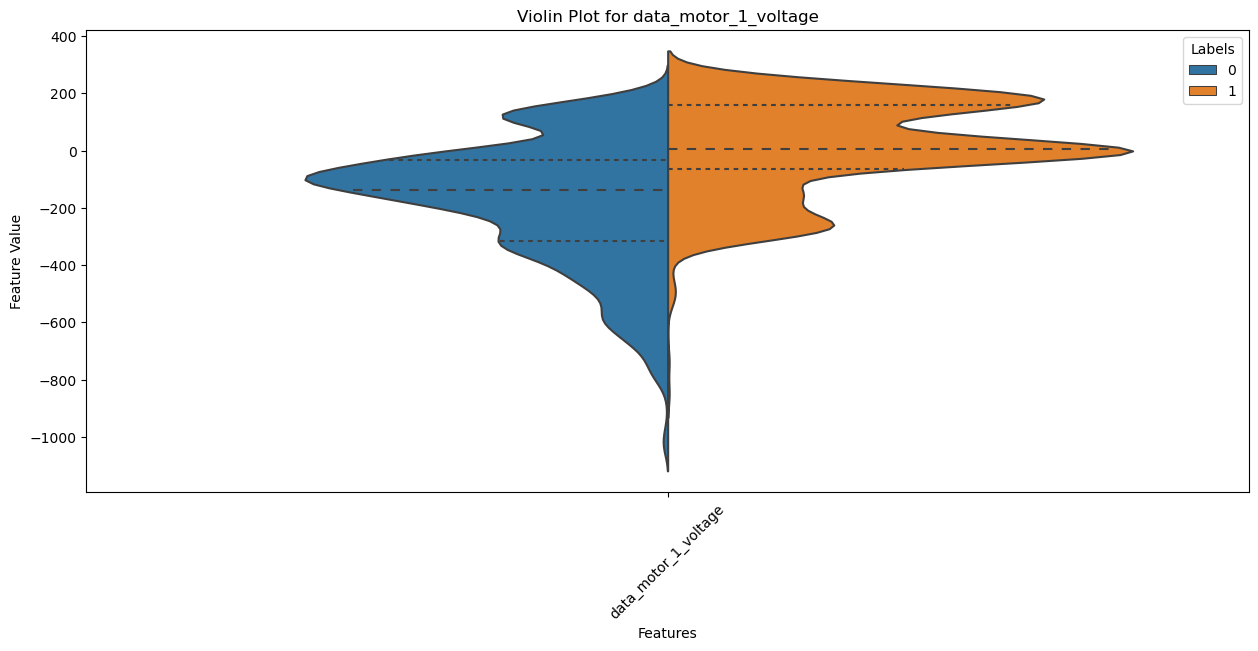

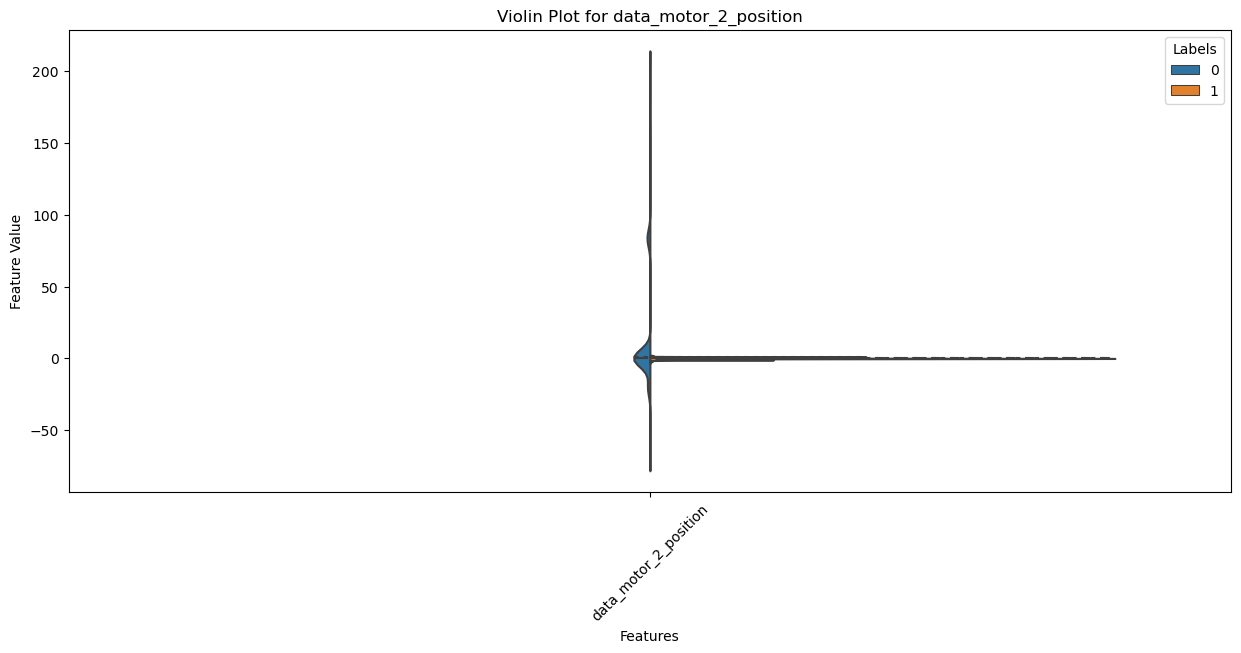

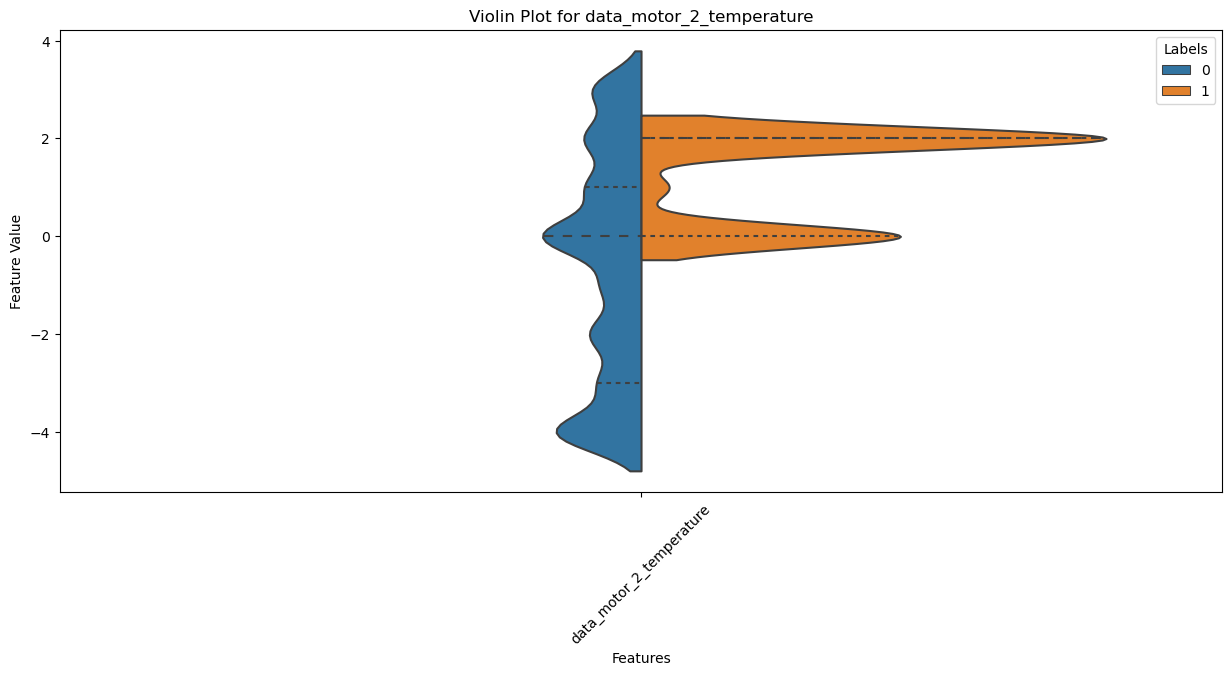

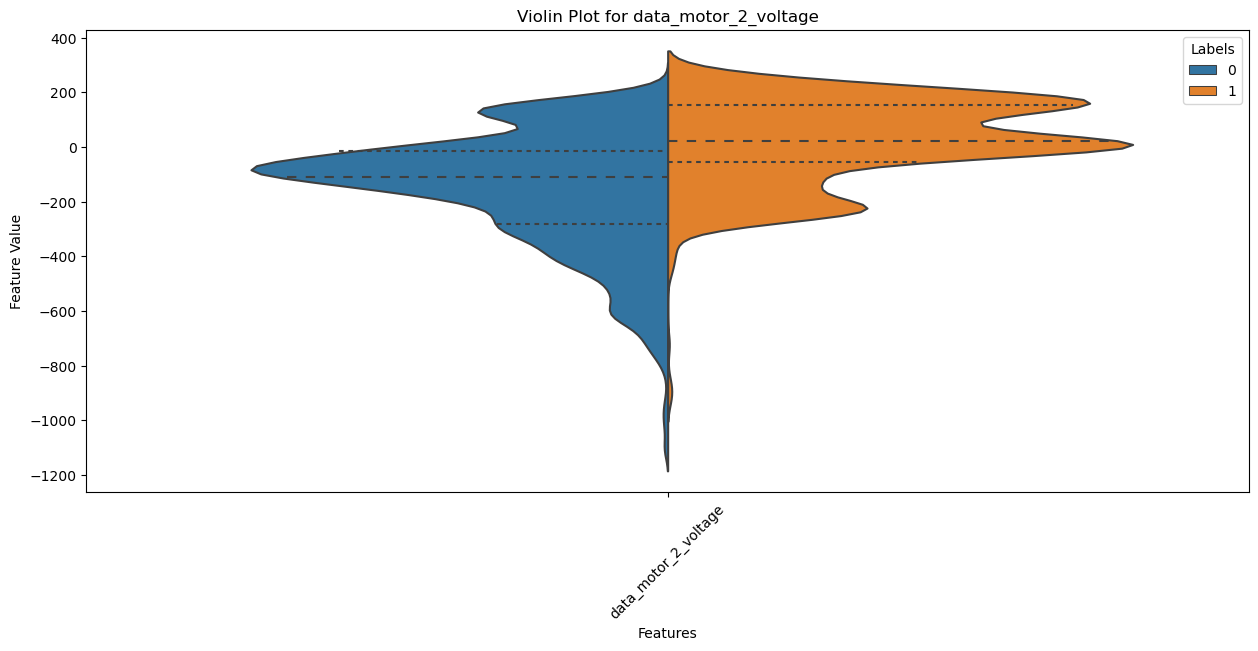

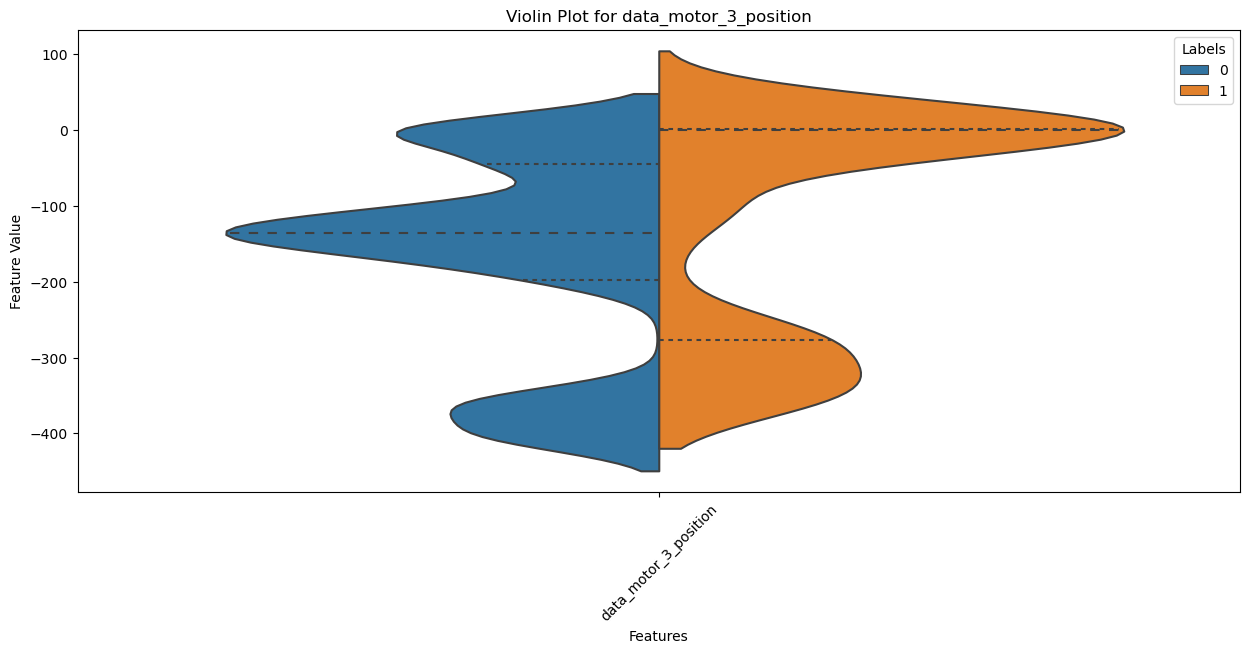

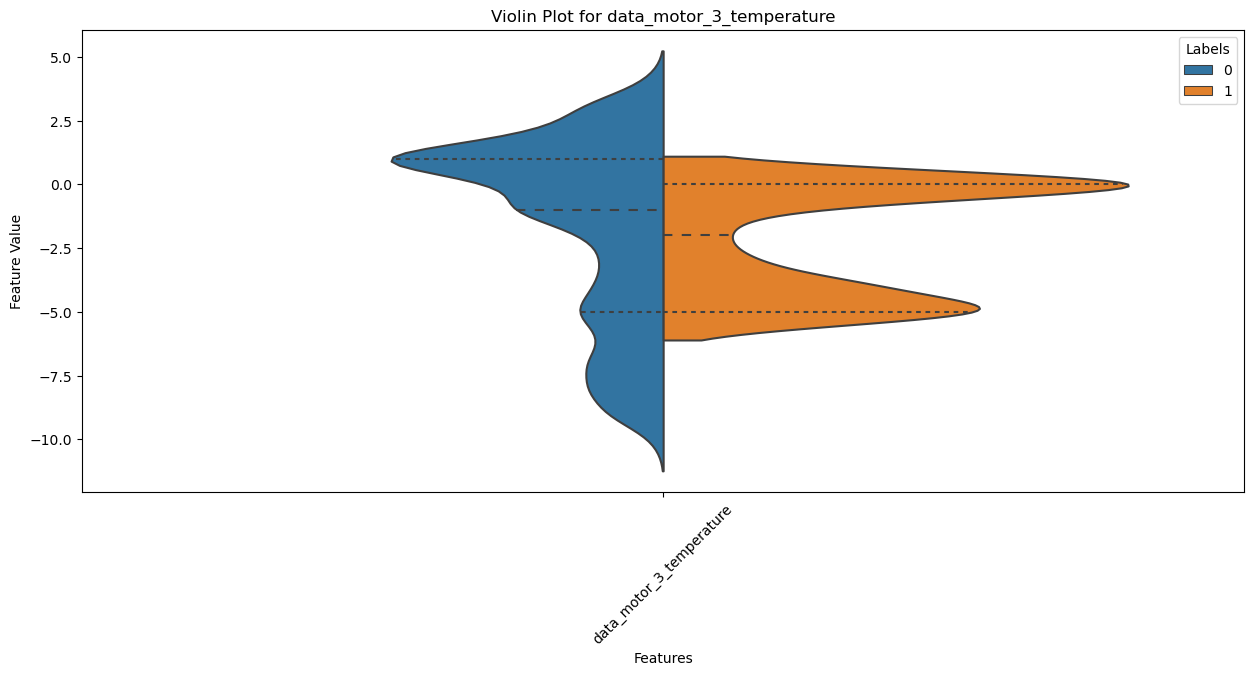

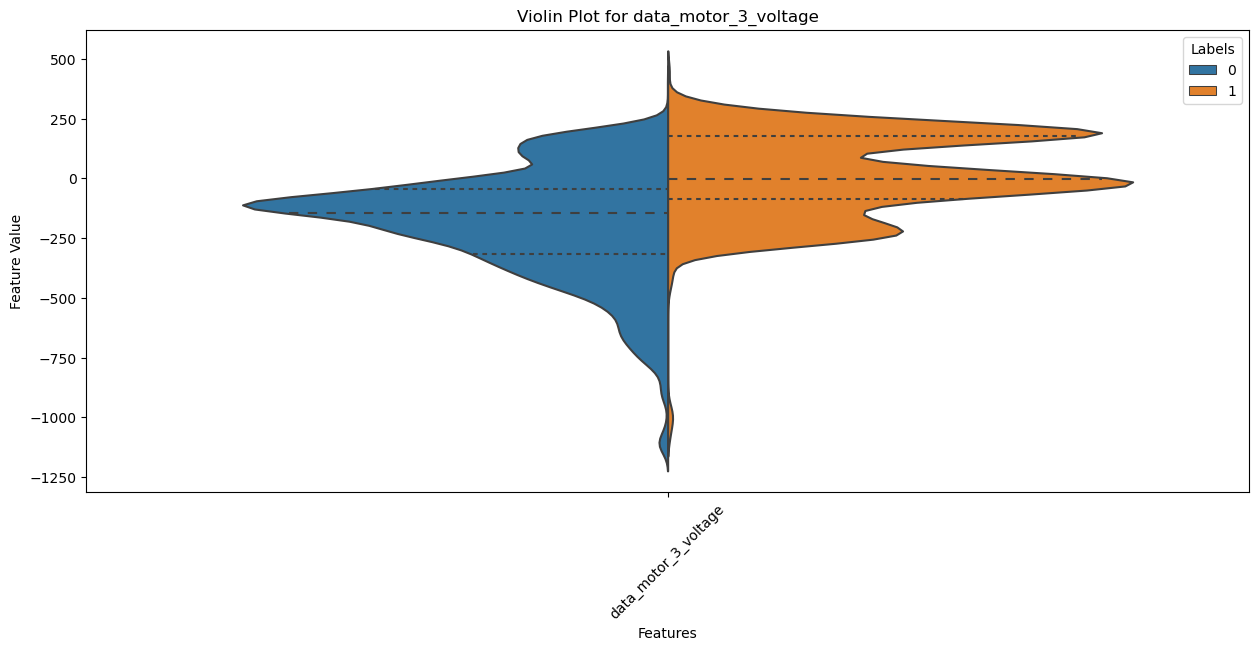

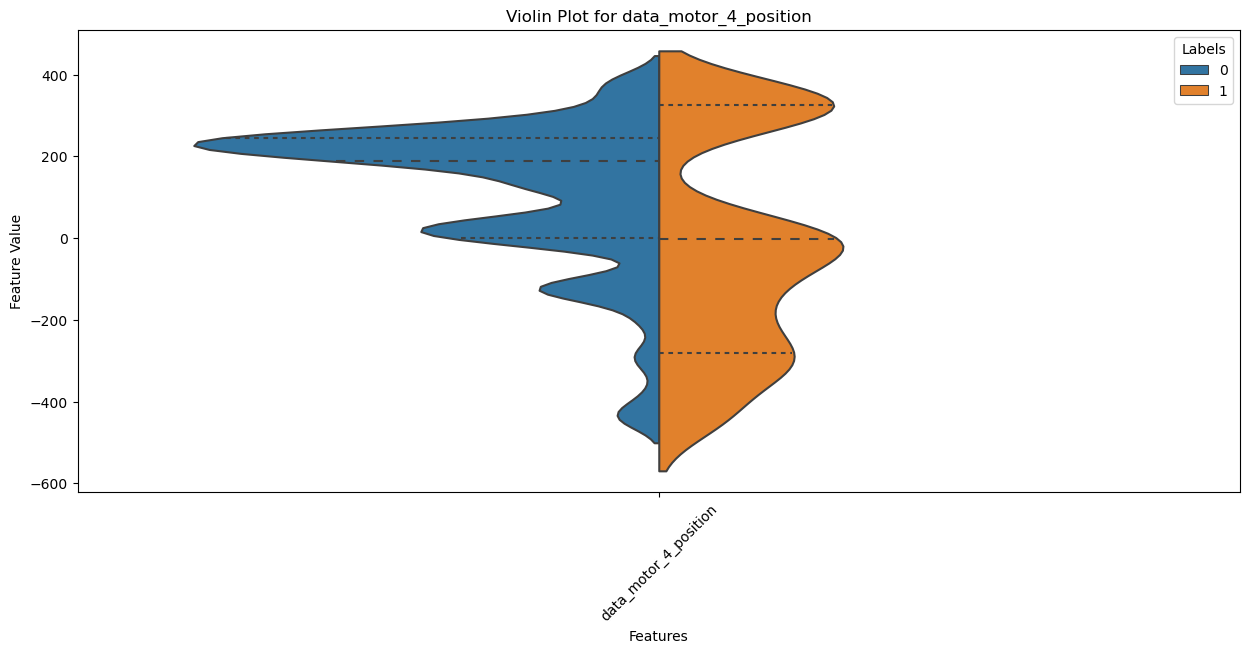

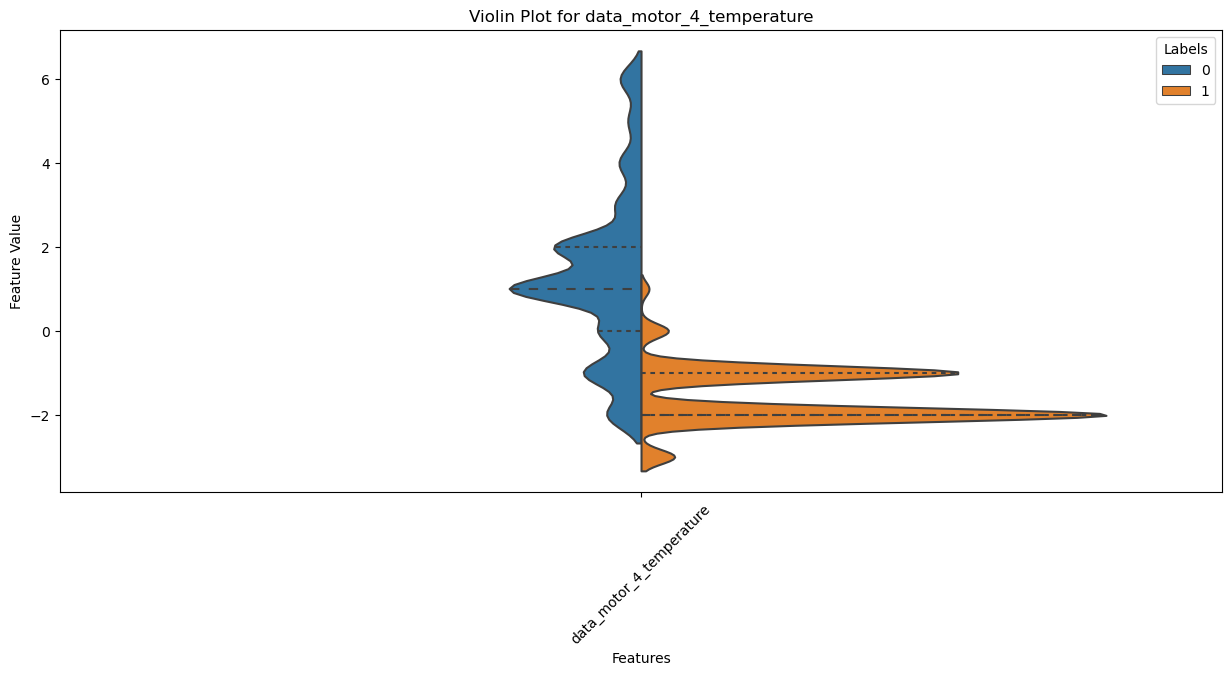

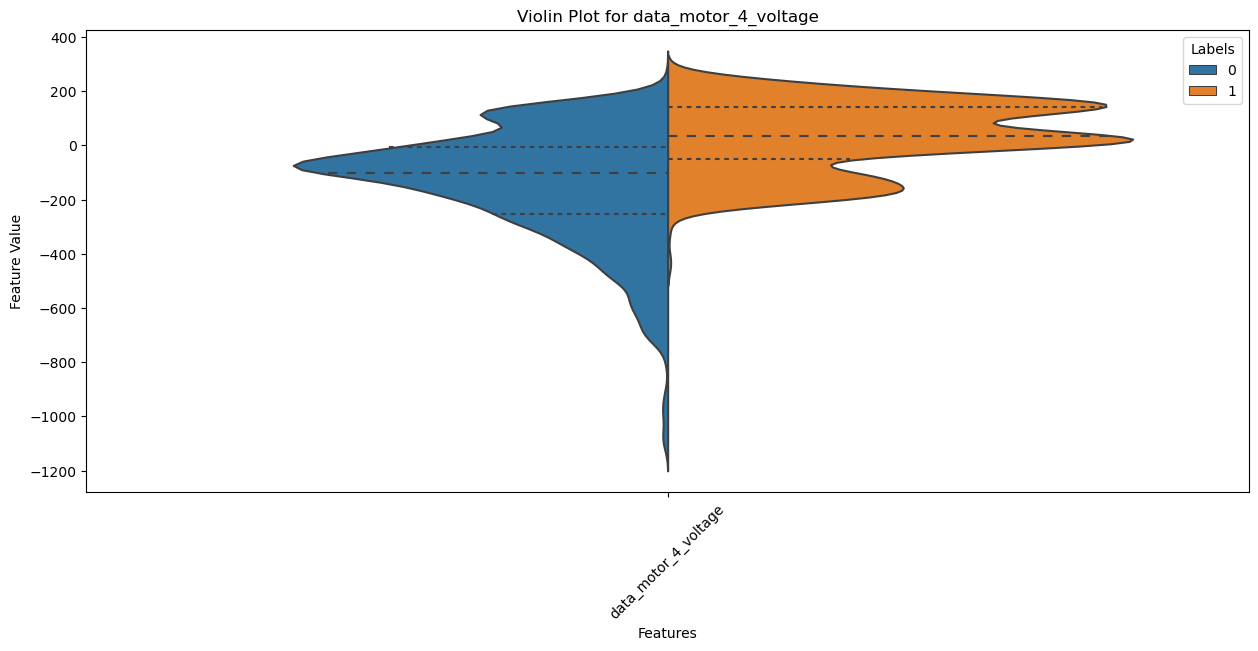

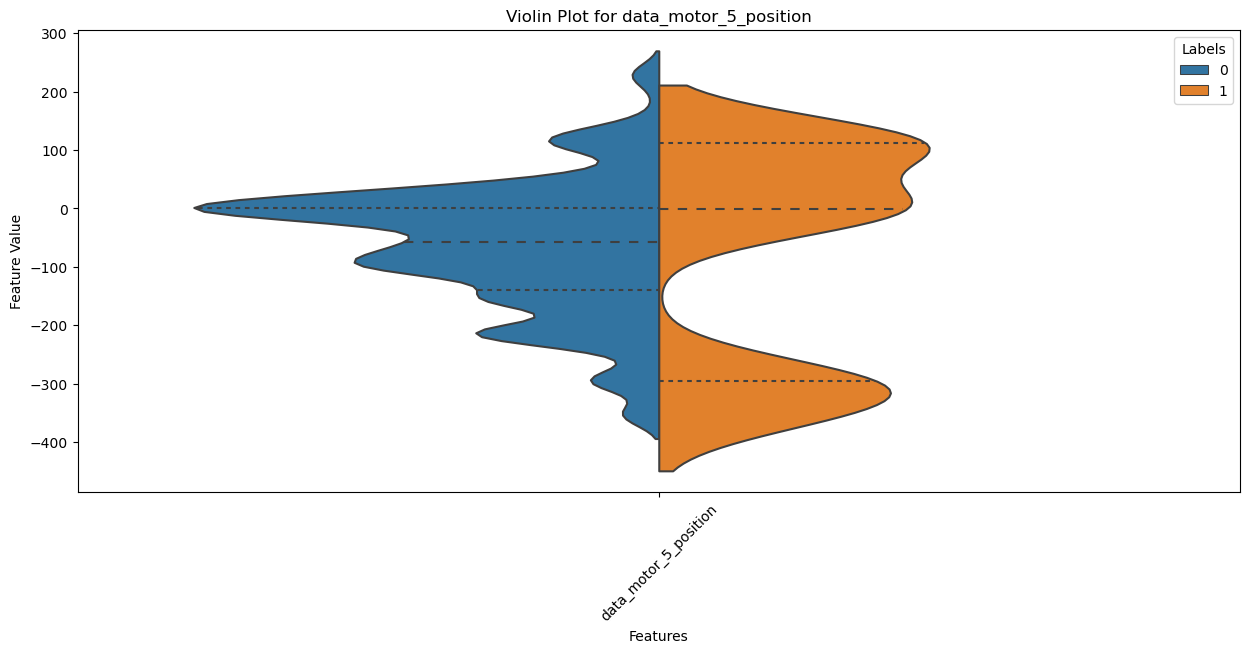

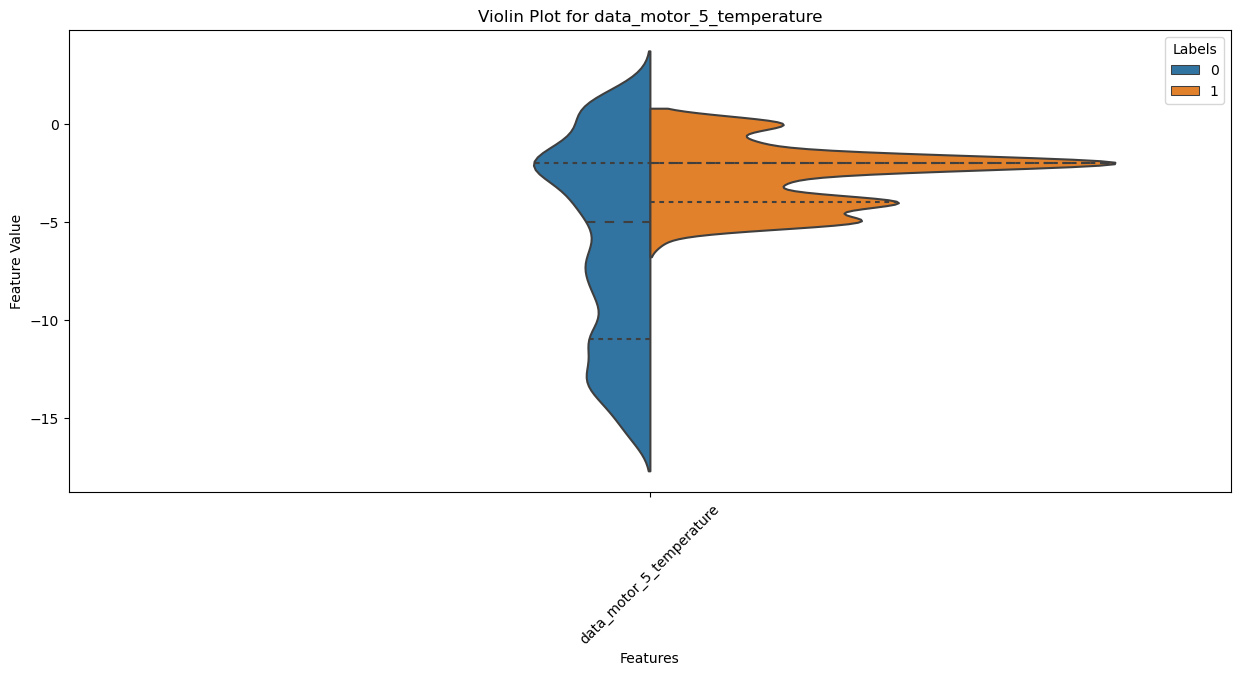

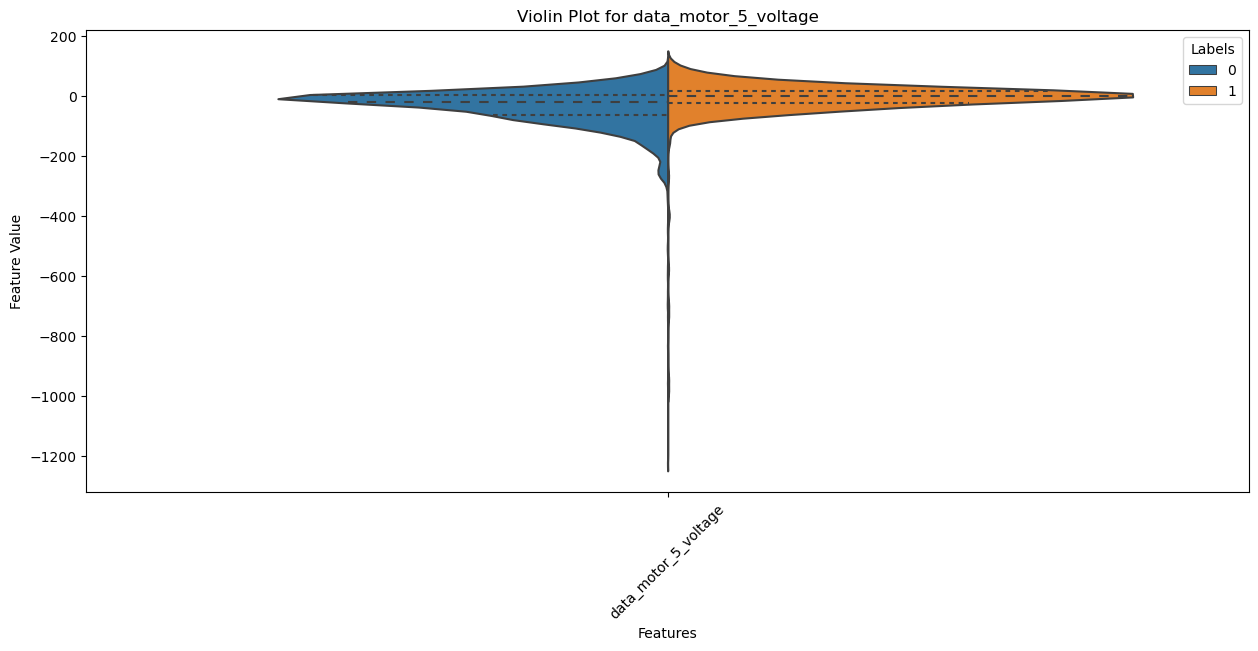

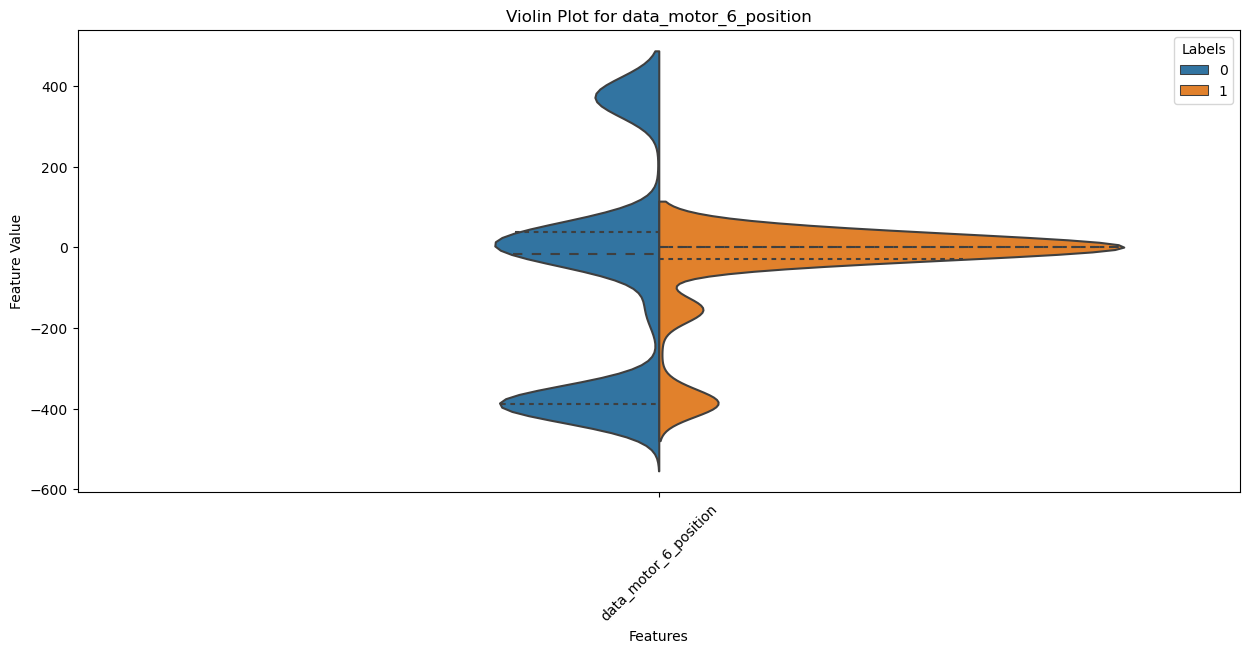

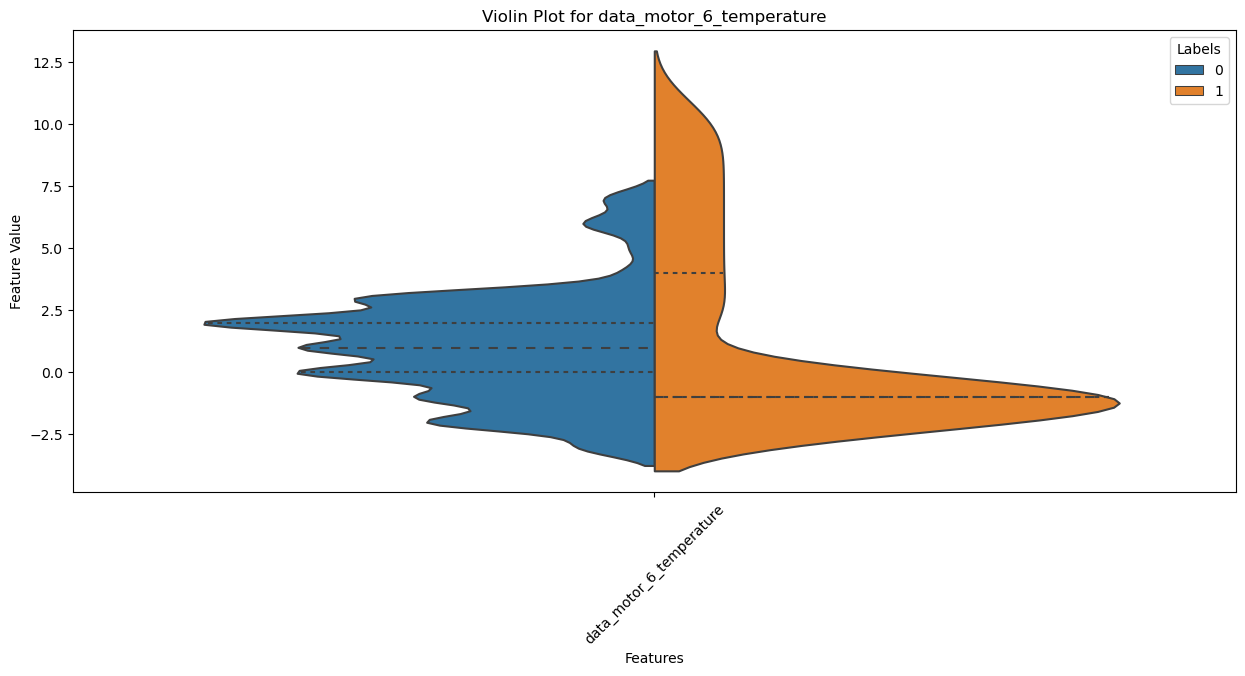

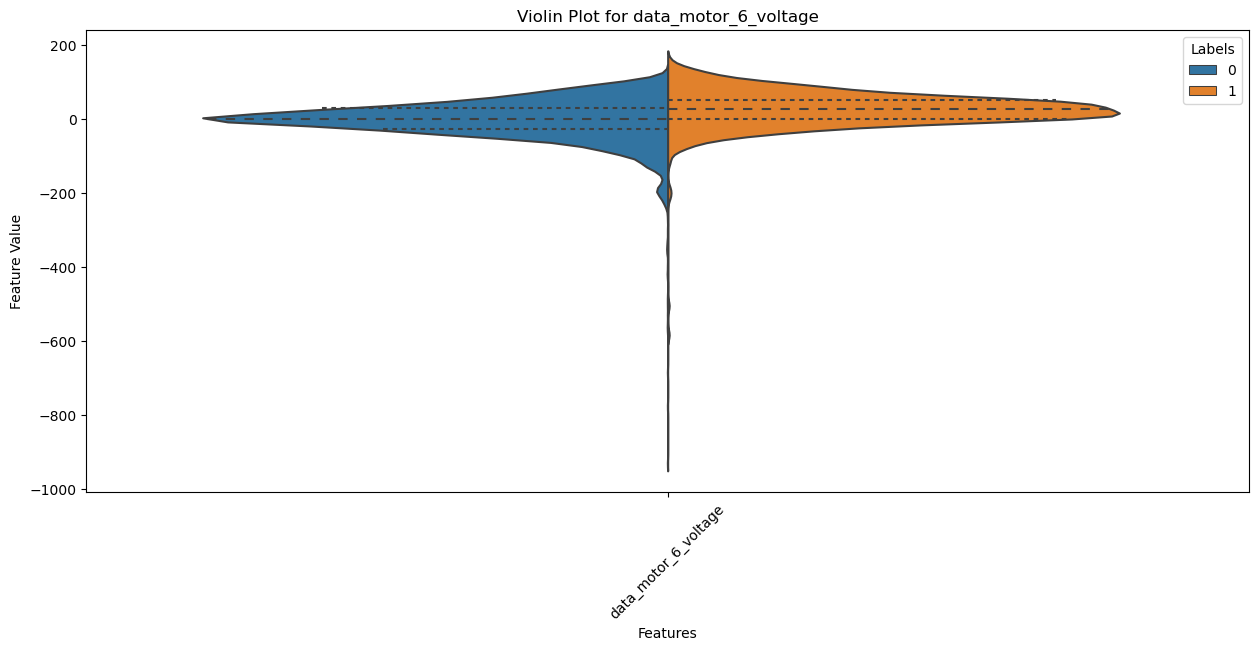

In [60]:
# For selecting the features, we analyze the violin plots related to motor 6 label

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def violplot(df):

    # Sample DataFrame
    # df_data_without_column = ...

    remove_columns = ['time', 'test_condition', 
                  'data_motor_1_label', 'data_motor_2_label', 'data_motor_3_label',
                  'data_motor_4_label', 'data_motor_5_label', 'data_motor_6_label', 
                  'data_motor_1_temperature_diff', 'data_motor_1_position_diff', 'data_motor_1_voltage_diff',
                  'data_motor_2_temperature_diff', 'data_motor_2_position_diff', 'data_motor_2_voltage_diff',
                  'data_motor_3_temperature_diff', 'data_motor_3_position_diff', 'data_motor_3_voltage_diff',
                  'data_motor_4_temperature_diff', 'data_motor_4_position_diff', 'data_motor_4_voltage_diff',
                  'data_motor_5_temperature_diff', 'data_motor_5_position_diff', 'data_motor_5_voltage_diff',
                  'data_motor_6_temperature_diff', 'data_motor_6_position_diff', 'data_motor_6_voltage_diff']

    df_data_without_column = df.drop(columns=remove_columns, axis=1)

    # Get list of columns
    columns = df_data_without_column.columns.tolist()

    # Separate y and x
    y = df.data_motor_6_label
    x = pd.DataFrame(df_data_without_column, columns=columns)
    data = pd.concat([y, x], axis=1)

    # Melt the DataFrame
    data = pd.melt(data, id_vars='data_motor_6_label', var_name="features", value_name='value')

    # Iterate over every feature and create violin plots
    for feature in columns:
        plt.figure(figsize=(15, 6))  # Adjust figure size as needed
        sns.violinplot(x="features", y="value", hue="data_motor_6_label", data=data[data['features'] == feature], split=True, inner="quart")
        plt.title(f"Violin Plot for {feature}")
        plt.xlabel("Features")
        plt.ylabel("Feature Value")
        plt.legend(title='Labels')
        plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
        plt.show()

print("Not Moving: ")
violplot(df_data_not_moving)
print("")

print("Move: ")
violplot(df_data_move)
print("")

print("PickUpAndPlace: ")
violplot(df_data_pickup_place)
print("")

In [72]:
# Function for comparing all the features with only the selected ones

def run_experiment(motor_id, df_data, all_features, selected_features, mdl, window_size=1, sample_step=1, n_fold=5):

    print(f'window_size={window_size}, sample_step={sample_step}, all the features.')
    _ = run_cv_one_motor(motor_id, df_data, mdl, all_features, n_fold=n_fold, window_size=window_size, 
        sample_step=sample_step, single_run_result=False, mdl_type='clf')

    print(f'window_size={window_size}, sample_step={sample_step}, selected features.')
    _ = run_cv_one_motor(motor_id, df_data, mdl, selected_features, n_fold=n_fold, window_size=window_size, 
        sample_step=sample_step, single_run_result=False, mdl_type='clf')
    
# Selected features

selected_features_not_moving = ['data_motor_1_temperature', 'data_motor_2_temperature', 'data_motor_3_temperature',
                                'data_motor_4_temperature', 'data_motor_5_temperature', 'data_motor_6_temperature', 'data_motor_6_position']

selected_features_move = ['data_motor_1_temperature', 'data_motor_2_temperature', 'data_motor_3_temperature',
                          'data_motor_5_temperature', 'data_motor_6_temperature', 'data_motor_6_position', 'data_motor_6_voltage']

selected_features_pickup_place = ['data_motor_1_position', 'data_motor_2_position', 'data_motor_3_position',
                                  'data_motor_4_position', 'data_motor_5_position', 'data_motor_6_position',
                                  'data_motor_1_temperature', 'data_motor_2_temperature', 'data_motor_3_temperature',
                                  'data_motor_4_temperature', 'data_motor_5_temperature', 'data_motor_6_temperature', 
                                  'data_motor_6_voltage']


## Logistic Regression

In [78]:
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('mdl', LogisticRegression(class_weight='balanced'))    # Step 2: Linear Regression
]

# Create the pipeline
pipeline = Pipeline(steps)

# Define hyperparameters to search
param_grid = {
    'mdl__C': [0.001, 0.01, 0.1, 1, 10, 100]  # Inverse of regularization strength
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='f1', cv=5)

# Results
result_not_moving = run_experiment(motor_id=6, df_data=df_data_not_moving, all_features=all_feature, 
                                   selected_features=selected_features_not_moving, mdl=grid_search, n_fold=n_cv_not_moving)
result_not_moving = run_experiment(motor_id=6, df_data=df_data_not_moving, all_features=all_feature, selected_features=selected_features_not_moving, 
                                   window_size=window_size, sample_step=sample_step, mdl=grid_search, n_fold=n_cv_not_moving)

result_move = run_experiment(motor_id=6, df_data=df_data_move, all_features=all_feature, 
                             selected_features=selected_features_move, mdl=grid_search, n_fold=n_cv_move)
result_move = run_experiment(motor_id=6, df_data=df_data_move, all_features=all_feature, selected_features=selected_features_move, 
                             window_size=window_size, sample_step=sample_step, mdl=grid_search, n_fold=n_cv_move)

result_pickup_place = run_experiment(motor_id=6, df_data=df_data_pickup_place, all_features=all_feature, 
                                   selected_features=selected_features_pickup_place, mdl=grid_search, n_fold=n_cv_pickup_place)
result_pickup_place = run_experiment(motor_id=6, df_data=df_data_pickup_place, all_features=all_feature, selected_features=selected_features_pickup_place, 
                                     window_size=window_size, sample_step=sample_step, mdl=grid_search, n_fold=n_cv_pickup_place)

window_size=1, sample_step=1, all the features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.957346   1.000000  0.890244  0.941935
1  0.925926   1.000000  0.689922  0.816514
2  0.958984   0.723404  0.539683  0.618182


Mean performance metric and standard error:
Accuracy: 0.9474 +- 0.0186
Precision: 0.9078 +- 0.1597
Recall: 0.7066 +- 0.1759
F1 score: 0.7922 +- 0.1632


window_size=1, sample_step=1, selected features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.957346   1.000000  0.890244  0.941935
1  0.918519   0.956989  0.689922  0.801802
2  0.972656   1.000000  0.555556  0.714286


Mean performance metric and standard error:
Accuracy: 0.9495 +- 0.0279
Precision: 0.9857 +- 0.0248
Recall: 0.7119 +- 0.1684
F1 score: 0.8193 +- 0.1148


window_size=50, sample_step=10, all the features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.851852   0.784314  0.975610  0.869565
1  0.898167   1.000000  0.612403  0.759615
2  0.575385  

## Support Vector Machine SVM

In [79]:
# Linear Kernel

steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('mdl', LinearSVC(max_iter=1000))    # Step 2: SVM
]

# Create the pipeline
pipeline = Pipeline(steps)

# Define hyperparameters to search
param_grid = {
    'mdl__C': [0.001, 0.01, 0.1, 1, 10, 100]  # Inverse of regularization strength
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='f1', cv=5)

# Results
result_not_moving = run_experiment(motor_id=6, df_data=df_data_not_moving, all_features=all_feature, 
                                   selected_features=selected_features_not_moving, mdl=grid_search, n_fold=n_cv_not_moving)
result_not_moving = run_experiment(motor_id=6, df_data=df_data_not_moving, all_features=all_feature, selected_features=selected_features_not_moving, 
                                   window_size=window_size, sample_step=sample_step, mdl=grid_search, n_fold=n_cv_not_moving)

result_move = run_experiment(motor_id=6, df_data=df_data_move, all_features=all_feature, 
                             selected_features=selected_features_move, mdl=grid_search, n_fold=n_cv_move)
result_move = run_experiment(motor_id=6, df_data=df_data_move, all_features=all_feature, selected_features=selected_features_move, 
                             window_size=window_size, sample_step=sample_step, mdl=grid_search, n_fold=n_cv_move)

result_pickup_place = run_experiment(motor_id=6, df_data=df_data_pickup_place, all_features=all_feature, 
                                   selected_features=selected_features_pickup_place, mdl=grid_search, n_fold=n_cv_pickup_place)
result_pickup_place = run_experiment(motor_id=6, df_data=df_data_pickup_place, all_features=all_feature, selected_features=selected_features_pickup_place, 
                                     window_size=window_size, sample_step=sample_step, mdl=grid_search, n_fold=n_cv_pickup_place)

window_size=1, sample_step=1, all the features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.957346        1.0  0.890244  0.941935
1  0.925926        1.0  0.689922  0.816514
2  0.972656        1.0  0.555556  0.714286


Mean performance metric and standard error:
Accuracy: 0.9520 +- 0.0238
Precision: 1.0000 +- 0.0000
Recall: 0.7119 +- 0.1684
F1 score: 0.8242 +- 0.1140


window_size=1, sample_step=1, selected features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.957346        1.0  0.890244  0.941935
1  0.925926        1.0  0.689922  0.816514
2  0.972656        1.0  0.555556  0.714286


Mean performance metric and standard error:
Accuracy: 0.9520 +- 0.0238
Precision: 1.0000 +- 0.0000
Recall: 0.7119 +- 0.1684
F1 score: 0.8242 +- 0.1140


window_size=50, sample_step=10, all the features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.858025   0.792079  0.975610  0.874317
1  0.898167   1.000000  0.612403  0.759615
2  0.728205  

In [80]:
# Polynomial Kernel

steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('mdl', SVC(kernel='poly', max_iter=1000))    # Step 2: SVM
]

# Create the pipeline
pipeline = Pipeline(steps)

# Define hyperparameters to search
param_grid = {
    'mdl__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'mdl__degree': [2, 3, 4],
    'mdl__gamma': ['scale', 'auto']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='f1', cv=5)

# Results
result_not_moving = run_experiment(motor_id=6, df_data=df_data_not_moving, all_features=all_feature, 
                                   selected_features=selected_features_not_moving, mdl=grid_search, n_fold=n_cv_not_moving)
result_not_moving = run_experiment(motor_id=6, df_data=df_data_not_moving, all_features=all_feature, selected_features=selected_features_not_moving, 
                                   window_size=window_size, sample_step=sample_step, mdl=grid_search, n_fold=n_cv_not_moving)

result_move = run_experiment(motor_id=6, df_data=df_data_move, all_features=all_feature, 
                             selected_features=selected_features_move, mdl=grid_search, n_fold=n_cv_move)
result_move = run_experiment(motor_id=6, df_data=df_data_move, all_features=all_feature, selected_features=selected_features_move, 
                             window_size=window_size, sample_step=sample_step, mdl=grid_search, n_fold=n_cv_move)

result_pickup_place = run_experiment(motor_id=6, df_data=df_data_pickup_place, all_features=all_feature, 
                                   selected_features=selected_features_pickup_place, mdl=grid_search, n_fold=n_cv_pickup_place)
result_pickup_place = run_experiment(motor_id=6, df_data=df_data_pickup_place, all_features=all_feature, selected_features=selected_features_pickup_place, 
                                     window_size=window_size, sample_step=sample_step, mdl=grid_search, n_fold=n_cv_pickup_place)

window_size=1, sample_step=1, all the features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.957346   1.000000  0.890244  0.941935
1  0.892593   0.908046  0.612403  0.731481
2  0.758789   0.132000  0.523810  0.210863


Mean performance metric and standard error:
Accuracy: 0.8696 +- 0.1013
Precision: 0.6800 +- 0.4768
Recall: 0.6755 +- 0.1912
F1 score: 0.6281 +- 0.3763


window_size=1, sample_step=1, selected features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.957346   1.000000  0.890244  0.941935
1  0.918519   0.956989  0.689922  0.801802
2  0.971680   1.000000  0.539683  0.701031


Mean performance metric and standard error:
Accuracy: 0.9492 +- 0.0275
Precision: 0.9857 +- 0.0248
Recall: 0.7066 +- 0.1759
F1 score: 0.8149 +- 0.1210


window_size=50, sample_step=10, all the features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.833333   0.772277  0.951220  0.852459
1  0.733198   0.250000  0.007752  0.015038
2  0.819487  

In [81]:
# Radial Kernel

steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('mdl', SVC(kernel='rbf', max_iter=1000))    # Step 2: SVM
]

# Create the pipeline
pipeline = Pipeline(steps)

# Define hyperparameters to search
param_grid = {
    'mdl__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'mdl__gamma': ['scale', 'auto']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='f1', cv=5)

# Results
result_not_moving = run_experiment(motor_id=6, df_data=df_data_not_moving, all_features=all_feature, 
                                   selected_features=selected_features_not_moving, mdl=grid_search, n_fold=n_cv_not_moving)
result_not_moving = run_experiment(motor_id=6, df_data=df_data_not_moving, all_features=all_feature, selected_features=selected_features_not_moving, 
                                   window_size=window_size, sample_step=sample_step, mdl=grid_search, n_fold=n_cv_not_moving)

result_move = run_experiment(motor_id=6, df_data=df_data_move, all_features=all_feature, 
                             selected_features=selected_features_move, mdl=grid_search, n_fold=n_cv_move)
result_move = run_experiment(motor_id=6, df_data=df_data_move, all_features=all_feature, selected_features=selected_features_move, 
                             window_size=window_size, sample_step=sample_step, mdl=grid_search, n_fold=n_cv_move)

result_pickup_place = run_experiment(motor_id=6, df_data=df_data_pickup_place, all_features=all_feature, 
                                   selected_features=selected_features_pickup_place, mdl=grid_search, n_fold=n_cv_pickup_place)
result_pickup_place = run_experiment(motor_id=6, df_data=df_data_pickup_place, all_features=all_feature, selected_features=selected_features_pickup_place, 
                                     window_size=window_size, sample_step=sample_step, mdl=grid_search, n_fold=n_cv_pickup_place)

window_size=1, sample_step=1, all the features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.710900   1.000000  0.256098  0.407767
1  0.909259   0.987805  0.627907  0.767773
2  0.936523   0.468750  0.238095  0.315789


Mean performance metric and standard error:
Accuracy: 0.8522 +- 0.1231
Precision: 0.8189 +- 0.3033
Recall: 0.3740 +- 0.2200
F1 score: 0.4971 +- 0.2389


window_size=1, sample_step=1, selected features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.725118        1.0  0.292683  0.452830
1  0.925926        1.0  0.689922  0.816514
2  0.971680        1.0  0.539683  0.701031


Mean performance metric and standard error:
Accuracy: 0.8742 +- 0.1312
Precision: 1.0000 +- 0.0000
Recall: 0.5074 +- 0.2006
F1 score: 0.6568 +- 0.1858


window_size=50, sample_step=10, all the features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.493827        0.5  0.158537  0.240741
1  0.871690        1.0  0.511628  0.676923
2  0.931282  

## Random Forest

In [82]:
# Radial Kernel

steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('mdl', RandomForestClassifier())    # Step 2: SVM
]

# Create the pipeline
pipeline = Pipeline(steps)

# Define hyperparameters to search
param_grid = {
    'mdl__n_estimators': [100, 200, 300],
    'mdl__max_depth': [None, 10, 20],
    'mdl__min_samples_split': [2, 5, 10]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='f1', cv=5)

# Results
result_not_moving = run_experiment(motor_id=6, df_data=df_data_not_moving, all_features=all_feature, 
                                   selected_features=selected_features_not_moving, mdl=grid_search, n_fold=n_cv_not_moving)
result_not_moving = run_experiment(motor_id=6, df_data=df_data_not_moving, all_features=all_feature, selected_features=selected_features_not_moving, 
                                   window_size=window_size, sample_step=sample_step, mdl=grid_search, n_fold=n_cv_not_moving)

result_move = run_experiment(motor_id=6, df_data=df_data_move, all_features=all_feature, 
                             selected_features=selected_features_move, mdl=grid_search, n_fold=n_cv_move)
result_move = run_experiment(motor_id=6, df_data=df_data_move, all_features=all_feature, selected_features=selected_features_move, 
                             window_size=window_size, sample_step=sample_step, mdl=grid_search, n_fold=n_cv_move)

result_pickup_place = run_experiment(motor_id=6, df_data=df_data_pickup_place, all_features=all_feature, 
                                   selected_features=selected_features_pickup_place, mdl=grid_search, n_fold=n_cv_pickup_place)
result_pickup_place = run_experiment(motor_id=6, df_data=df_data_pickup_place, all_features=all_feature, selected_features=selected_features_pickup_place, 
                                     window_size=window_size, sample_step=sample_step, mdl=grid_search, n_fold=n_cv_pickup_place)

window_size=1, sample_step=1, all the features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.957346        1.0  0.890244  0.941935
1  0.925926        1.0  0.689922  0.816514
2  0.972656        1.0  0.555556  0.714286


Mean performance metric and standard error:
Accuracy: 0.9520 +- 0.0238
Precision: 1.0000 +- 0.0000
Recall: 0.7119 +- 0.1684
F1 score: 0.8242 +- 0.1140


window_size=1, sample_step=1, selected features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.957346        1.0  0.890244  0.941935
1  0.925926        1.0  0.689922  0.816514
2  0.972656        1.0  0.555556  0.714286


Mean performance metric and standard error:
Accuracy: 0.9520 +- 0.0238
Precision: 1.0000 +- 0.0000
Recall: 0.7119 +- 0.1684
F1 score: 0.8242 +- 0.1140


window_size=50, sample_step=10, all the features.
Model for motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.864198   0.800000  0.975610  0.879121
1  0.959267   1.000000  0.844961  0.915966
2  0.985641  

## Summary of the results

Please add a table in the end, summarying the results from all the models (including the unsupervised learning models). Please write a few texts to explain what is the best model you got, its performance, and how could you further improve it.

| Model   | Accuracy | Precision | Recall | F1   |
|---------|----------|-----------|--------|------|
| Model 1 |   XX.X%  |   XX.X%   |  XX.X% | XX.X%|
| Model 2 |   XX.X%  |   XX.X%   |  XX.X% | XX.X%|
| Model 3 |   XX.X%  |   XX.X%   |  XX.X% | XX.X%|
